In [1]:
import subprocess 
import torch as ch
from torch import Tensor
import torch.linalg as LA
from torch.distributions import Uniform, Laplace
from torch.distributions.multivariate_normal import MultivariateNormal
import pandas as pd
import numpy as np
import csv
import json
from cox.utils import Parameters
from cox.store import Store

from cox.readers import CollectionReader
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import math 

import sys 
sys.path.append('../..')
from delphi.stats.linear_regression import TruncatedRegression
from delphi import oracle
from delphi.utils import constants as consts
from delphi.utils.helpers import setup_store_with_metadata


OUT_DIR = '/home/gridsan/stefanou/Regression/'
TABLE_NAME = 'logs'

# set environment variable so that stores can create output files
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

In [2]:
args = Parameters({
    "bias": True,
    "samples": 1000,
    "c": 0,
    "batch_size": 5,
    "lr": 1e-1,
    "var_": 1,
    "trials": 3,
    "steps": 1000,
    "x_lower": -10,
    "x_upper": 10,
    "lower": -1,
    "upper": 1,
})
mse_loss = ch.nn.MSELoss()

I will start by generating the ground-truth for our expriment.

In [141]:
args.__setattr__('bs', 10)
args.__setattr__('steps', 2500)
args.__setattr__('step_lr', 100)
args.__setattr__('step_lr_gamma', .9)
args.__setattr__('tol', 1e-2)
args.__setattr__('trials', 20)
args.__setattr__('n', 100)


EXP = 'SimpleExp5'

In [142]:
def run_trial(kwargs, X, y):
    """
    Runs a trial of a truncated regression experiment. Runs a maximum 
    of three trials of an experiment. The experiment terminates when either 
    the norm of teh score is less than 3e-1, or when three trials is up. After 
    three trials it returns the best truncated regression experiment.
    :param kwargs: keyword arguments for experiment 
    :param X: independent variable
    :param y: dependent variable
    :return: truncated regression experiment and time that experiment took
    """
    st = datetime.datetime.now()        
    # run procedure until get reasonable score
    attempt, score, best_trunc_reg = 0, None, None
    while (score is None or score.norm() > 3e-1) and attempt < 3:
        trunc_reg = TruncatedRegression(**kwargs)
        trunc_reg.fit(X, y)
        grad = trunc_reg.score()
        if score is None or grad.norm() < score.norm(): 
            score, best_trunc_reg = grad, trunc_reg
        attempt += 1
    total_time = int((datetime.datetime.now() - st).total_seconds())
    return best_trunc_reg, total_time  

In [153]:
 # expriment parameters
w_lower, w_upper = -1, 1
d, k = 10, 1

# distribution for generating feature vectors
dist = MultivariateNormal(ch.zeros(d), ch.eye(d)/d)
# dist = Uniform(0, 5)
samples = [10, 25, 50, 100, 125, 150, 175, 200, 225, 250, 275, 300, 400, 500, 750, 1000, 1500, 2000, 2500, 3000, 5000]
# samples = [1500]
intervals = [(3.0, float('inf'))]
phi = oracle.KIntervalUnion(intervals)
phi = oracle.Left(1.0)
noise_var = Tensor([1.0])

stand_intervals = [(int_[0]/float(ch.sqrt(noise_var)), int_[1]/float(ch.sqrt(noise_var))) for int_ in intervals]
scaled_kinterval = oracle.KIntervalUnion(stand_intervals)

# generate ground truth
gt = ch.nn.Linear(in_features=d, out_features=k)
gt.weight = ch.nn.Parameter(ch.ones(k, d))
gt.bias = ch.nn.Parameter(ch.ones(1, 1)) if args.bias else None

# generate data until max number of samples fall within the truncation set
X, noised = Tensor([]), Tensor([])
all_x_trunc, all_y_trunc = Tensor([]), Tensor([])
with ch.no_grad():
    while all_x_trunc.size(0) < samples[-1]: 
        x_ = dist.sample(ch.Size([samples[-1], d])) if isinstance(dist, Uniform) else dist.sample(ch.Size([samples[-1]]))
        new_noised = gt(x_) + ch.sqrt(noise_var) * ch.randn(samples[-1], 1)
        # add noise to ground-truth pedictions
        # truncate based off of the standardized data
        indices = phi(new_noised).flatten().nonzero(as_tuple=False).flatten()
        all_y_trunc, all_x_trunc = ch.cat([all_y_trunc, new_noised[indices]]), ch.cat([all_x_trunc, x_[indices]])
        X, noised = ch.cat([X, x_]), ch.cat([noised, new_noised])
        
alpha = Tensor([all_y_trunc.size(0) / noised.size(0)])
print("alpha: ", alpha)

for i in range(args.trials):
    # create store and add table
    store = Store(OUT_DIR + EXP)
    store.add_table(TABLE_NAME, { 
        'ols_r2': float,
        'ols_param_mse': float,
        'ols_var_l1': float,
        'known_r2': float,
        'known_param_mse': float,
        'known_time': int,
        'unknown_r2': float, 
        'unknown_param_mse': float,
        'unknown_var_l1': float,
        'unknown_time': int,
        'alpha': float, 
        'num_samples': int,
        'noise_var': float, 
    })
            
    # shuffle x_trunc, y_trunc
    rand_perm = ch.randperm(all_y_trunc.size(0))
    x_trunc_pool, y_trunc_pool = all_x_trunc[rand_perm], all_y_trunc[rand_perm]
                
    # alpha is constant across all trials

    
    # iterate over samples
    for s in samples: 
        # take s truncated samples
        x_trunc, y_trunc = x_trunc_pool[:s], y_trunc_pool[:s]

        # 10% of truncated data is validation data
        val = int(.1*s)
        
        # normalize x features so that ||x_{i}||_{2}^{2} <= 1
        l_inf = LA.norm(x_trunc, dim=-1, ord=float('inf')).max() # find max l_inf
        # calculate normalizing constant
        beta = l_inf*math.sqrt(d)
        """
        Divide input features by normalizing constant. By doing so, 
        the weights will be increased by a magnitude of beta.
        """
        x_trunc_norm = x_trunc / beta
         # normalize entire dataset by beta
        x_norm = X / beta
        
        # ground-truth ols
        gt_ols = LinearRegression()
        gt_ols.fit(X, noised)
        gt_params = ch.cat([Tensor(gt_ols.coef_).T, Tensor(gt_ols.intercept_)[..., None]]).flatten()
        
        # empirical linear regression
        ols = LinearRegression() 
        ols.fit(x_trunc, y_trunc)
        ols_var = ch.var(Tensor(ols.predict(x_trunc)) - y_trunc, dim=0)[..., None]
        ols_params = ch.cat([Tensor(ols.coef_).T, Tensor(ols.intercept_)[..., None]]).flatten()
        # check r2 for entire dataset
        ols_pred = ols.predict(X)

        # ols results
        store[TABLE_NAME].update_row({
            'ols_r2': r2_score(noised.flatten(), ols_pred.flatten()), 
            'ols_var_l1': ch.abs(ols_var - noise_var),
            'ols_param_mse': mse_loss(ols_params, gt_params),
        })
        
        """
        Run dataset on truncated regression with unknown variance. 
        This means that we want to standardize our dependent variable 
        by the empirical noise variance. 
        """
        # variance of the residuals
        emp_noise_var = (y_trunc - ols.predict(x_trunc)).var(0)
        emp_stand_intervals = [(int_[0]/math.sqrt(float(emp_noise_var)), int_[1]/math.sqrt(float(emp_noise_var))) for int_ in intervals]
        emp_scaled_kinterval = oracle.KIntervalUnion(emp_stand_intervals)
        # standardize y trunc by the empirical noise variance
        emp_stand_y_trunc = y_trunc / ch.sqrt(emp_noise_var)        

        # truncated regression with unknown variance
        unknown_kwargs = { 
            'phi': oracle.Left(phi.left / ch.sqrt(emp_noise_var)), 

            'alpha': alpha, 
            'bias': args.bias, 
            'unknown': True, 
            'bs': args.bs, 
            'n': args.n, 
            'tol': args.tol, 
            'steps': args.steps, 
            'val': val
        }
        unknown_trunc_reg, total_time = run_trial(unknown_kwargs, x_trunc_norm, emp_stand_y_trunc)
        unknown_var = unknown_trunc_reg.variance * emp_noise_var
        w, w0 = (((unknown_trunc_reg.weight * unknown_trunc_reg.variance) * ch.sqrt(emp_noise_var)) / beta).detach(), ((unknown_trunc_reg.intercept * unknown_trunc_reg.variance * ch.sqrt(emp_noise_var)))
        unknown_params = ch.cat([w, w0]).flatten()

        # known emp results
        store[TABLE_NAME].update_row({
            'unknown_r2': r2_score(noised.flatten(), X@w + w0), 
            'unknown_param_mse': mse_loss(unknown_params, gt_params),
            'unknown_var_l1': float(ch.abs(unknown_var - noise_var)),
            'unknown_time': total_time, 
        })
        
        # add additional exp data to store
        store[TABLE_NAME].update_row({ 
            'alpha': float(alpha.flatten()),
            'num_samples': x_trunc.size(0),
            'noise_var': noise_var, 
        })

        # append row to table
        store[TABLE_NAME].flush_row()
    store.close()    

new noised:  tensor([[-0.4039],
        [ 1.3911],
        [ 3.4449],
        ...,
        [ 0.3038],
        [ 1.1033],
        [ 2.3085]])
new noised:  tensor([[-1.5369],
        [ 1.6154],
        [-2.1316],
        ...,
        [ 0.9904],
        [ 2.3542],
        [ 1.0174]])
alpha:  tensor([0.5019])
Logging in: /home/gridsan/stefanou/Regression/SimpleExp5/e9565633-3a4c-4ba3-8724-1d9dc39f1c96
Iteration: 0.0 | Score: [-0.8762205839157104]
Iteration: 1.0 | Score: [-0.43637847900390625]
Iteration: 2.0 | Score: [-0.38729429244995117]
Iteration: 3.0 | Score: [-0.2969508171081543]
Iteration: 4.0 | Score: [-0.04423666000366211]
Iteration: 5.0 | Score: [-0.4204111099243164]
Iteration: 6.0 | Score: [-0.15738749504089355]
Iteration: 7.0 | Score: [-0.20601105690002441]
Iteration: 8.0 | Score: [-0.12213253974914551]
Iteration: 9.0 | Score: [-0.006386995315551758]
Iteration: 0.0 | Score: [3386720.0, -14429960798208.0]
Iteration: 1.0 | Score: [702911.25, -2051687055360.0]
Iteration: 2.0 | Score

Iteration: 3.0 | Score: [0.11553248018026352]
Iteration: 4.0 | Score: [0.06614023447036743]
Iteration: 5.0 | Score: [0.11100535839796066]
Iteration: 6.0 | Score: [0.06452807784080505]
Iteration: 7.0 | Score: [0.06171579658985138]
Iteration: 8.0 | Score: [0.07283110916614532]
Iteration: 9.0 | Score: [0.08256851136684418]
Iteration: 10.0 | Score: [0.011337697505950928]
Iteration: 11.0 | Score: [0.0845121368765831]
Iteration: 12.0 | Score: [-0.012335702776908875]
Iteration: 13.0 | Score: [0.12860874831676483]
Iteration: 14.0 | Score: [0.04013404995203018]
Iteration: 15.0 | Score: [0.1049867570400238]
Iteration: 16.0 | Score: [-0.004380658268928528]
Iteration: 0.0 | Score: [0.04320922866463661, -0.05202209949493408]
Iteration: 1.0 | Score: [0.029021402820944786, -0.09388110041618347]
Iteration: 2.0 | Score: [0.12582270801067352, -0.5374542474746704]
Iteration: 3.0 | Score: [0.23692062497138977, -0.8768539428710938]
Iteration: 4.0 | Score: [0.13210660219192505, -0.6577634811401367]
Iteratio

Iteration: 24.0 | Score: [-0.28676337003707886]
Iteration: 25.0 | Score: [-0.33317750692367554]
Iteration: 0.0 | Score: [-0.05249645560979843, 0.3275739550590515]
Iteration: 1.0 | Score: [-0.13476485013961792, 0.5103904008865356]
Iteration: 2.0 | Score: [-0.3864378333091736, 1.4174686670303345]
Iteration: 3.0 | Score: [-0.5258874297142029, 1.7871466875076294]
Iteration: 4.0 | Score: [-0.314581036567688, 1.0740293264389038]
Iteration: 5.0 | Score: [-0.4113064110279083, 1.4063758850097656]
Iteration: 6.0 | Score: [-0.10309441387653351, 0.282411128282547]
Iteration: 7.0 | Score: [-0.3719690144062042, 1.2088829278945923]
Iteration: 8.0 | Score: [-0.20125530660152435, 0.6764101982116699]
Iteration: 9.0 | Score: [-0.17437343299388885, 0.5288578867912292]
Iteration: 10.0 | Score: [-0.1480100303888321, 0.40099549293518066]
Iteration: 11.0 | Score: [-0.3770618438720703, 1.2435708045959473]
Iteration: 12.0 | Score: [-0.5001918077468872, 1.6511762142181396]
Iteration: 13.0 | Score: [-0.4657574892

Iteration: 23.0 | Score: [-0.5517170429229736, 1.808127522468567]
Iteration: 24.0 | Score: [-0.5678036212921143, 1.8832499980926514]
Iteration: 25.0 | Score: [-0.636618435382843, 2.072005033493042]
Iteration: 0.0 | Score: [0.6340314745903015, -1.7431461811065674]
Iteration: 1.0 | Score: [0.03513183444738388, 0.30643168091773987]
Iteration: 2.0 | Score: [0.17245854437351227, -0.1727929562330246]
Iteration: 3.0 | Score: [0.886387825012207, -2.989912271499634]
Iteration: 4.0 | Score: [0.11117163300514221, 0.06302963197231293]
Iteration: 5.0 | Score: [0.16895708441734314, -0.22288015484809875]
Iteration: 6.0 | Score: [0.9388550519943237, -3.389338493347168]
Iteration: 7.0 | Score: [0.15583454072475433, -0.18505963683128357]
Iteration: 8.0 | Score: [0.36331015825271606, -0.914423406124115]
Iteration: 9.0 | Score: [0.7846041321754456, -2.685983896255493]
Iteration: 10.0 | Score: [0.28741031885147095, -0.6854470372200012]
Iteration: 11.0 | Score: [0.42498692870140076, -1.2533297538757324]
Ite

Iteration: 25.0 | Score: [0.20984193682670593, -0.6313509941101074]
Iteration: 0.0 | Score: [0.07278560847043991, 0.029689759016036987]
Iteration: 1.0 | Score: [-0.045777611434459686, 0.39747464656829834]
Iteration: 2.0 | Score: [-0.09428254514932632, 0.5481144785881042]
Iteration: 3.0 | Score: [-0.16640540957450867, 0.8124599456787109]
Iteration: 4.0 | Score: [1.1533749103546143, -5.406838893890381]
Iteration: 5.0 | Score: [-0.1915111094713211, 0.8153368234634399]
Iteration: 6.0 | Score: [0.29852500557899475, -1.2357335090637207]
Iteration: 7.0 | Score: [0.0476999469101429, -0.14366677403450012]
Iteration: 8.0 | Score: [-0.053848233073949814, 0.17078952491283417]
Iteration: 9.0 | Score: [-0.1209966167807579, 0.5104326009750366]
Iteration: 10.0 | Score: [0.0026082054246217012, 0.04373958706855774]
Iteration: 11.0 | Score: [0.4822153151035309, -2.235398292541504]
Iteration: 12.0 | Score: [-0.008918165229260921, 0.023186981678009033]
Iteration: 13.0 | Score: [0.060358013957738876, -0.361

Iteration: 25.0 | Score: [-0.14702926576137543, 1.115209698677063]
Iteration: 0.0 | Score: [0.5016388893127441]
Iteration: 1.0 | Score: [0.24059312045574188]
Iteration: 2.0 | Score: [0.25417089462280273]
Iteration: 3.0 | Score: [0.20938292145729065]
Iteration: 4.0 | Score: [0.25084981322288513]
Iteration: 5.0 | Score: [0.2055090367794037]
Iteration: 6.0 | Score: [0.2776584327220917]
Iteration: 7.0 | Score: [0.22331315279006958]
Iteration: 8.0 | Score: [0.22478999197483063]
Iteration: 9.0 | Score: [0.20857356488704681]
Iteration: 10.0 | Score: [0.24655786156654358]
Iteration: 11.0 | Score: [0.21307767927646637]
Iteration: 12.0 | Score: [0.2073861062526703]
Iteration: 13.0 | Score: [0.22962847352027893]
Iteration: 14.0 | Score: [0.22174064815044403]
Iteration: 15.0 | Score: [0.22399674355983734]
Iteration: 16.0 | Score: [0.22214090824127197]
Iteration: 17.0 | Score: [0.23471853137016296]
Iteration: 18.0 | Score: [0.2506921887397766]
Iteration: 19.0 | Score: [0.18165916204452515]
Iteratio

Iteration: 7.0 | Score: [-0.5560604333877563, 1.884310007095337]
Iteration: 8.0 | Score: [-0.21246391534805298, 0.582542359828949]
Iteration: 9.0 | Score: [-0.3481961190700531, 1.1462416648864746]
Iteration: 10.0 | Score: [-0.4421786963939667, 1.5034515857696533]
Iteration: 11.0 | Score: [-0.4528321921825409, 1.5264352560043335]
Iteration: 12.0 | Score: [-0.44280746579170227, 1.4829870462417603]
Iteration: 13.0 | Score: [-0.3739699721336365, 1.248118281364441]
Iteration: 14.0 | Score: [-0.441592812538147, 1.4773503541946411]
Iteration: 15.0 | Score: [-0.47649502754211426, 1.6170600652694702]
Iteration: 16.0 | Score: [-0.30941474437713623, 0.9852292537689209]
Iteration: 17.0 | Score: [-0.2965243458747864, 0.9136650562286377]
Iteration: 18.0 | Score: [-0.5467813611030579, 1.8299505710601807]
Iteration: 19.0 | Score: [-0.4307517111301422, 1.4255859851837158]
Iteration: 20.0 | Score: [-0.35876885056495667, 1.162699580192566]
Iteration: 21.0 | Score: [-0.3871796429157257, 1.2627133131027222

Iteration: 16.0 | Score: [0.5022274255752563, -1.4561944007873535]
Iteration: 17.0 | Score: [0.47927263379096985, -1.3544590473175049]
Iteration: 18.0 | Score: [0.46426475048065186, -1.2792491912841797]
Iteration: 19.0 | Score: [0.5407150983810425, -1.5716602802276611]
Iteration: 20.0 | Score: [0.45787593722343445, -1.2464509010314941]
Iteration: 21.0 | Score: [0.42523595690727234, -1.1582010984420776]
Iteration: 22.0 | Score: [0.43828535079956055, -1.2317211627960205]
Iteration: 23.0 | Score: [0.3893786370754242, -1.0361357927322388]
Iteration: 24.0 | Score: [0.3760632872581482, -1.0212708711624146]
Iteration: 25.0 | Score: [0.38867583870887756, -1.0232290029525757]
Iteration: 0.0 | Score: [-0.04486354440450668, 0.045623719692230225]
Iteration: 1.0 | Score: [-0.03597267344594002, -0.02492225170135498]
Iteration: 2.0 | Score: [-0.06814005970954895, 0.010593235492706299]
Iteration: 3.0 | Score: [-0.06648199260234833, -0.03895285725593567]
Iteration: 4.0 | Score: [-0.16381968557834625, 0

Iteration: 23.0 | Score: [-0.16160964965820312]
Iteration: 24.0 | Score: [-0.1733924299478531]
Iteration: 25.0 | Score: [-0.15232715010643005]
Iteration: 0.0 | Score: [-0.08883178234100342, 0.42626264691352844]
Iteration: 1.0 | Score: [-0.9916169047355652, 3.1741232872009277]
Iteration: 2.0 | Score: [-0.12891612946987152, 0.5155372023582458]
Iteration: 3.0 | Score: [-0.5348687171936035, 1.8368479013442993]
Iteration: 4.0 | Score: [-0.4027661681175232, 1.3955693244934082]
Iteration: 5.0 | Score: [-0.5268972516059875, 1.7638187408447266]
Iteration: 6.0 | Score: [-0.32711073756217957, 1.0956401824951172]
Iteration: 7.0 | Score: [-0.40812018513679504, 1.3378005027770996]
Iteration: 8.0 | Score: [-0.46230754256248474, 1.534195899963379]
Iteration: 9.0 | Score: [-0.312591552734375, 0.9894740581512451]
Iteration: 10.0 | Score: [-0.3472268581390381, 1.1617661714553833]
Iteration: 11.0 | Score: [-0.33381015062332153, 1.0760095119476318]
Iteration: 12.0 | Score: [-0.3055901825428009, 0.929283499

Iteration: 11.0 | Score: [-0.199652299284935, 0.7285689115524292]
Iteration: 12.0 | Score: [0.24988527595996857, -1.0297479629516602]
Iteration: 13.0 | Score: [-0.1552830934524536, 0.5942665338516235]
Iteration: 14.0 | Score: [-0.23768509924411774, 0.9070927500724792]
Iteration: 15.0 | Score: [-0.008838686160743237, 0.01797717809677124]
Iteration: 16.0 | Score: [-0.19413599371910095, 0.7130144238471985]
Iteration: 17.0 | Score: [-0.2156558632850647, 0.7950249910354614]
Iteration: 18.0 | Score: [-0.01537385769188404, 0.04370565712451935]
Iteration: 19.0 | Score: [0.06401396542787552, -0.27758732438087463]
Iteration: 20.0 | Score: [-0.039083369076251984, 0.12487272918224335]
Iteration: 21.0 | Score: [-0.11371272802352905, 0.3852922320365906]
Iteration: 22.0 | Score: [-0.1453707218170166, 0.5220484733581543]
Iteration: 23.0 | Score: [-0.13902008533477783, 0.5102814435958862]
Iteration: 24.0 | Score: [-0.17822399735450745, 0.6301138401031494]
Iteration: 25.0 | Score: [-0.043397560715675354

Iteration: 23.0 | Score: [-0.01731569692492485, 0.15011675655841827]
Iteration: 24.0 | Score: [-0.10317138582468033, 0.481580913066864]
Iteration: 25.0 | Score: [-0.035970140248537064, 0.1836770474910736]
Iteration: 0.0 | Score: [0.13028739392757416, -0.371038556098938]
Iteration: 1.0 | Score: [0.23490820825099945, -0.804662823677063]
Iteration: 2.0 | Score: [-0.5616889595985413, 1.8044471740722656]
Iteration: 3.0 | Score: [-0.27057400345802307, 0.8954538702964783]
Iteration: 4.0 | Score: [0.14704103767871857, -0.644430935382843]
Iteration: 5.0 | Score: [-0.041910018771886826, 0.05056516081094742]
Iteration: 6.0 | Score: [-0.35951751470565796, 1.1221905946731567]
Iteration: 7.0 | Score: [-0.10671786218881607, 0.2437310814857483]
Iteration: 8.0 | Score: [-0.06223321706056595, 0.07108500599861145]
Iteration: 9.0 | Score: [0.2587221562862396, -1.1990280151367188]
Iteration: 10.0 | Score: [-0.04091331735253334, -0.009609002619981766]
Iteration: 11.0 | Score: [-0.20954374969005585, 0.600686

Iteration: 5.0 | Score: [0.01825389266014099, 0.12679415941238403]
Iteration: 6.0 | Score: [-0.2697541415691376, 1.106874942779541]
Iteration: 7.0 | Score: [0.2585197985172272, -0.8145847320556641]
Iteration: 8.0 | Score: [0.12050284445285797, -0.285745233297348]
Iteration: 9.0 | Score: [0.01316165179014206, 0.08213746547698975]
Iteration: 10.0 | Score: [-0.15350286662578583, 0.6932151317596436]
Iteration: 11.0 | Score: [0.053242988884449005, -0.053221266716718674]
Iteration: 12.0 | Score: [0.22291994094848633, -0.7171437740325928]
Iteration: 13.0 | Score: [-0.02161933295428753, 0.21785469353199005]
Iteration: 14.0 | Score: [0.04717099666595459, -0.03798884153366089]
Iteration: 15.0 | Score: [-0.13344214856624603, 0.608960747718811]
Iteration: 16.0 | Score: [0.11158659309148788, -0.29927587509155273]
Iteration: 17.0 | Score: [0.08354252576828003, -0.19988340139389038]
Iteration: 18.0 | Score: [-0.014369101263582706, 0.17089363932609558]
Iteration: 19.0 | Score: [-0.11518748104572296, 0

Iteration: 15.0 | Score: [0.029247775673866272]
Iteration: 16.0 | Score: [0.020421061664819717]
Iteration: 17.0 | Score: [0.02462390437722206]
Iteration: 18.0 | Score: [0.03211594745516777]
Iteration: 19.0 | Score: [0.06035427749156952]
Iteration: 20.0 | Score: [0.042850643396377563]
Iteration: 21.0 | Score: [0.037026919424533844]
Iteration: 22.0 | Score: [0.045610543340444565]
Iteration: 23.0 | Score: [0.04696253687143326]
Iteration: 24.0 | Score: [0.0348152257502079]
Iteration: 25.0 | Score: [0.041221827268600464]
Iteration: 26.0 | Score: [0.043099597096443176]
Iteration: 27.0 | Score: [0.04131694510579109]
Iteration: 0.0 | Score: [0.23637646436691284, -0.5855838060379028]
Iteration: 1.0 | Score: [-0.09706568717956543, 0.4796273112297058]
Iteration: 2.0 | Score: [-0.1259586066007614, 0.540835976600647]
Iteration: 3.0 | Score: [0.014092179015278816, 0.060018524527549744]
Iteration: 4.0 | Score: [-0.3410196006298065, 1.1871358156204224]
Iteration: 5.0 | Score: [0.31224876642227173, -1.

Iteration: 4.0 | Score: [0.005448877811431885]
Iteration: 0.0 | Score: [-0.5787065625190735, 1.8776257038116455]
Iteration: 1.0 | Score: [-0.08049892634153366, -0.03244471549987793]
Iteration: 2.0 | Score: [-0.6553840637207031, 2.26853084564209]
Iteration: 3.0 | Score: [-1.2249637842178345, 4.214146614074707]
Iteration: 4.0 | Score: [-0.36887645721435547, 0.8222842216491699]
Iteration: 5.0 | Score: [-0.6440269947052002, 2.157987594604492]
Iteration: 6.0 | Score: [-1.1526612043380737, 3.905102252960205]
Iteration: 7.0 | Score: [-0.5123049020767212, 1.4726001024246216]
Iteration: 8.0 | Score: [-0.47236835956573486, 1.2221720218658447]
Iteration: 9.0 | Score: [-1.0460015535354614, 3.48368501663208]
Iteration: 10.0 | Score: [-0.3771737813949585, 0.8841817378997803]
Iteration: 11.0 | Score: [-0.6512349247932434, 2.0460238456726074]
Iteration: 12.0 | Score: [-0.8605848550796509, 2.820671558380127]
Iteration: 13.0 | Score: [-0.5452386140823364, 1.3941105604171753]
Iteration: 14.0 | Score: [-0

Iteration: 1.0 | Score: [-0.059671759605407715, 0.2904151678085327]
Iteration: 2.0 | Score: [-0.213832288980484, 0.8490782976150513]
Iteration: 3.0 | Score: [-0.24098357558250427, 1.0041478872299194]
Iteration: 4.0 | Score: [-0.293590247631073, 1.14592444896698]
Iteration: 5.0 | Score: [-0.21422860026359558, 0.7912126779556274]
Iteration: 6.0 | Score: [-0.2101651132106781, 0.7719769477844238]
Iteration: 7.0 | Score: [-0.3003110885620117, 1.1547609567642212]
Iteration: 8.0 | Score: [-0.20745769143104553, 0.7453432679176331]
Iteration: 9.0 | Score: [-0.27835142612457275, 0.9760622978210449]
Iteration: 10.0 | Score: [-0.21245168149471283, 0.7899351119995117]
Iteration: 11.0 | Score: [-0.12545184791088104, 0.48357218503952026]
Iteration: 12.0 | Score: [-0.18720746040344238, 0.6556999683380127]
Iteration: 13.0 | Score: [-0.11730458587408066, 0.4047258496284485]
Iteration: 14.0 | Score: [-0.16520808637142181, 0.5460805296897888]
Iteration: 15.0 | Score: [-0.16993051767349243, 0.6256706118583

Iteration: 4.0 | Score: [0.02058684080839157]
Iteration: 5.0 | Score: [-0.0007723979651927948]
Iteration: 0.0 | Score: [0.04026157036423683, -0.022053882479667664]
Iteration: 1.0 | Score: [-0.1991654634475708, 0.8429809212684631]
Iteration: 2.0 | Score: [-0.3356492817401886, 1.3746168613433838]
Iteration: 3.0 | Score: [0.08894211053848267, -0.2748502492904663]
Iteration: 4.0 | Score: [-0.007141840178519487, 0.006044961512088776]
Iteration: 0.0 | Score: [0.5759766697883606]
Iteration: 1.0 | Score: [0.23468148708343506]
Iteration: 2.0 | Score: [0.1976509541273117]
Iteration: 3.0 | Score: [0.21219806373119354]
Iteration: 4.0 | Score: [0.2723163366317749]
Iteration: 5.0 | Score: [0.21576984226703644]
Iteration: 6.0 | Score: [0.23299305140972137]
Iteration: 7.0 | Score: [0.23348891735076904]
Iteration: 8.0 | Score: [0.23263177275657654]
Iteration: 9.0 | Score: [0.23533840477466583]
Iteration: 10.0 | Score: [0.23745812475681305]
Iteration: 11.0 | Score: [0.24353264272212982]
Iteration: 12.0 

Iteration: 4.0 | Score: [0.5486449003219604, -1.8116915225982666]
Iteration: 5.0 | Score: [0.7943165302276611, -2.7273683547973633]
Iteration: 6.0 | Score: [0.3188869059085846, -1.0442863702774048]
Iteration: 7.0 | Score: [0.2947315573692322, -0.9775650501251221]
Iteration: 8.0 | Score: [0.4703807234764099, -1.5800608396530151]
Iteration: 9.0 | Score: [0.8201822638511658, -2.8455777168273926]
Iteration: 10.0 | Score: [0.39612263441085815, -1.3198643922805786]
Iteration: 11.0 | Score: [0.43312108516693115, -1.4594064950942993]
Iteration: 12.0 | Score: [0.4163791835308075, -1.4165403842926025]
Iteration: 13.0 | Score: [0.7874662280082703, -2.7595996856689453]
Iteration: 14.0 | Score: [0.4728129804134369, -1.617706298828125]
Iteration: 15.0 | Score: [0.5526503324508667, -1.9291858673095703]
Iteration: 16.0 | Score: [0.49475619196891785, -1.6767568588256836]
Iteration: 17.0 | Score: [0.7207083702087402, -2.544982671737671]
Iteration: 18.0 | Score: [0.5320649743080139, -1.8566019535064697]


Iteration: 8.0 | Score: [-0.6165048480033875, 2.4349112510681152]
Iteration: 9.0 | Score: [-0.49857398867607117, 2.01238751411438]
Iteration: 10.0 | Score: [-0.39089182019233704, 1.6254396438598633]
Iteration: 11.0 | Score: [-0.4775626063346863, 1.9478739500045776]
Iteration: 12.0 | Score: [-0.464936763048172, 1.9159235954284668]
Iteration: 13.0 | Score: [-0.5490655303001404, 2.17637300491333]
Iteration: 14.0 | Score: [-0.4599689245223999, 1.9016432762145996]
Iteration: 15.0 | Score: [-0.5125514268875122, 2.059429168701172]
Iteration: 16.0 | Score: [-0.5197434425354004, 2.077993869781494]
Iteration: 17.0 | Score: [-0.4074718952178955, 1.6737589836120605]
Iteration: 18.0 | Score: [-0.4975135326385498, 2.014986038208008]
Iteration: 19.0 | Score: [-0.5543272495269775, 2.1632425785064697]
Iteration: 20.0 | Score: [-0.421050488948822, 1.7159817218780518]
Iteration: 21.0 | Score: [-0.3626246750354767, 1.4571802616119385]
Iteration: 22.0 | Score: [-0.4311343729496002, 1.7396982908248901]
Iter

Iteration: 13.0 | Score: [0.17279045283794403]
Iteration: 14.0 | Score: [0.20730574429035187]
Iteration: 15.0 | Score: [0.1955617368221283]
Iteration: 16.0 | Score: [0.1653015911579132]
Iteration: 17.0 | Score: [0.2327958047389984]
Iteration: 18.0 | Score: [0.18715310096740723]
Iteration: 19.0 | Score: [0.19306479394435883]
Iteration: 20.0 | Score: [0.2132483571767807]
Iteration: 21.0 | Score: [0.19107958674430847]
Iteration: 22.0 | Score: [0.22457946836948395]
Iteration: 23.0 | Score: [0.22667980194091797]
Iteration: 24.0 | Score: [0.19576120376586914]
Iteration: 25.0 | Score: [0.18293356895446777]
Iteration: 0.0 | Score: [0.2731720805168152, -0.7273983955383301]
Iteration: 1.0 | Score: [0.23568440973758698, -0.7143675684928894]
Iteration: 2.0 | Score: [0.0504348948597908, -0.0843377560377121]
Iteration: 3.0 | Score: [0.09312738478183746, -0.24092316627502441]
Iteration: 4.0 | Score: [0.2357984185218811, -0.818723201751709]
Iteration: 5.0 | Score: [-0.06934479624032974, 0.296784639358

Iteration: 7.0 | Score: [-0.10539428144693375, 0.08158804476261139]
Iteration: 8.0 | Score: [-0.23626840114593506, 0.6290184855461121]
Iteration: 9.0 | Score: [-0.029637468978762627, -0.280059278011322]
Iteration: 10.0 | Score: [-0.5355461835861206, 1.743572473526001]
Iteration: 11.0 | Score: [-0.4647837281227112, 1.4821441173553467]
Iteration: 12.0 | Score: [-0.4118305444717407, 1.2860033512115479]
Iteration: 13.0 | Score: [-0.09085629135370255, -0.05351525545120239]
Iteration: 14.0 | Score: [-0.28074225783348083, 0.7495154738426208]
Iteration: 15.0 | Score: [-0.32152050733566284, 0.9171436429023743]
Iteration: 16.0 | Score: [-0.21137084066867828, 0.47037333250045776]
Iteration: 17.0 | Score: [-0.2151384800672531, 0.4576432406902313]
Iteration: 18.0 | Score: [-0.189529687166214, 0.3589931130409241]
Iteration: 19.0 | Score: [-0.426074355840683, 1.3256003856658936]
Iteration: 20.0 | Score: [-0.37452462315559387, 1.1223483085632324]
Iteration: 21.0 | Score: [-0.3601948022842407, 1.039843

Iteration: 5.0 | Score: [0.2207995057106018, -0.7216575145721436]
Iteration: 6.0 | Score: [-0.08883173763751984, 0.47343915700912476]
Iteration: 7.0 | Score: [-0.0034144290257245302, 0.1241559088230133]
Iteration: 8.0 | Score: [0.06737320870161057, -0.1619972586631775]
Iteration: 9.0 | Score: [-0.3094456195831299, 1.2308670282363892]
Iteration: 10.0 | Score: [-0.26214835047721863, 1.0631520748138428]
Iteration: 11.0 | Score: [0.14162243902683258, -0.4854382574558258]
Iteration: 12.0 | Score: [0.10214249044656754, -0.27978265285491943]
Iteration: 13.0 | Score: [-0.11664548516273499, 0.5306646823883057]
Iteration: 14.0 | Score: [0.15989668667316437, -0.5261826515197754]
Iteration: 15.0 | Score: [-0.004687855951488018, 0.10834863781929016]
Iteration: 16.0 | Score: [-0.01928931288421154, 0.14051896333694458]
Iteration: 17.0 | Score: [0.02328517660498619, -0.01254957914352417]
Iteration: 18.0 | Score: [-0.12739750742912292, 0.5657668113708496]
Iteration: 19.0 | Score: [0.0640590637922287, -

Iteration: 25.0 | Score: [0.036891426891088486, -0.16644421219825745]
Iteration: 0.0 | Score: [0.28231796622276306]
Iteration: 1.0 | Score: [0.07116106152534485]
Iteration: 2.0 | Score: [-0.012572875246405602]
Iteration: 3.0 | Score: [0.005125541239976883]
Iteration: 0.0 | Score: [0.21551522612571716, -0.4344264566898346]
Iteration: 1.0 | Score: [-0.015623938292264938, 0.3082188665866852]
Iteration: 2.0 | Score: [0.46258437633514404, -1.481391429901123]
Iteration: 3.0 | Score: [-0.022378094494342804, 0.2598245143890381]
Iteration: 4.0 | Score: [-0.020994968712329865, 0.22702574729919434]
Iteration: 5.0 | Score: [-0.09895610064268112, 0.4969295263290405]
Iteration: 6.0 | Score: [-0.17331744730472565, 0.7207449674606323]
Iteration: 7.0 | Score: [0.015459193848073483, 0.07956566661596298]
Iteration: 8.0 | Score: [-0.012621779926121235, 0.15365393459796906]
Iteration: 9.0 | Score: [0.1872885376214981, -0.573276162147522]
Iteration: 10.0 | Score: [0.031776055693626404, -0.004087986424565315

Iteration: 13.0 | Score: [0.11154341697692871, -0.34994280338287354]
Iteration: 14.0 | Score: [0.09242810308933258, -0.29016420245170593]
Iteration: 15.0 | Score: [0.19895684719085693, -0.6739294528961182]
Iteration: 16.0 | Score: [0.04197709634900093, -0.11284085363149643]
Iteration: 17.0 | Score: [0.10682396590709686, -0.3465101718902588]
Iteration: 18.0 | Score: [0.06801585108041763, -0.21295003592967987]
Iteration: 19.0 | Score: [0.09796348959207535, -0.31367748975753784]
Iteration: 20.0 | Score: [0.03203742578625679, -0.07563095539808273]
Iteration: 21.0 | Score: [0.011031844653189182, -0.013682205229997635]
Iteration: 22.0 | Score: [0.08854107558727264, -0.2881079316139221]
Iteration: 23.0 | Score: [0.09655077755451202, -0.31420865654945374]
Iteration: 24.0 | Score: [0.2283797711133957, -0.8047692775726318]
Iteration: 25.0 | Score: [0.08851712197065353, -0.2913404107093811]
Iteration: 26.0 | Score: [0.10166709125041962, -0.3412483334541321]
Iteration: 27.0 | Score: [0.06974375993

Iteration: 13.0 | Score: [3441946.25, -16146436718592.0]
Iteration: 14.0 | Score: [3441946.25, -16146438815744.0]
Iteration: 15.0 | Score: [3441946.25, -16146438815744.0]
Iteration: 16.0 | Score: [3441946.25, -16146438815744.0]
Iteration: 17.0 | Score: [3441946.25, -16146438815744.0]
Iteration: 18.0 | Score: [3441946.25, -16146438815744.0]
Iteration: 19.0 | Score: [3441946.25, -16146438815744.0]
Iteration: 20.0 | Score: [3441946.25, -16146438815744.0]
Iteration: 21.0 | Score: [3441946.25, -16146438815744.0]
Iteration: 22.0 | Score: [3441946.25, -16146438815744.0]
Iteration: 23.0 | Score: [3441946.25, -16146438815744.0]
Iteration: 24.0 | Score: [3441946.25, -16146438815744.0]
Iteration: 25.0 | Score: [3441946.25, -16146438815744.0]
Iteration: 0.0 | Score: [0.0960504412651062]
Iteration: 1.0 | Score: [0.0347331166267395]
Iteration: 2.0 | Score: [-0.10692518949508667]
Iteration: 3.0 | Score: [-0.03933233022689819]
Iteration: 4.0 | Score: [-0.031773388385772705]
Iteration: 5.0 | Score: [-0

Iteration: 9.0 | Score: [-0.45067599415779114, 1.4168930053710938]
Iteration: 10.0 | Score: [-0.360602468252182, 1.1135112047195435]
Iteration: 11.0 | Score: [-0.25623396039009094, 0.7705999612808228]
Iteration: 12.0 | Score: [-0.30751124024391174, 0.8879543542861938]
Iteration: 13.0 | Score: [-0.24017108976840973, 0.5686284303665161]
Iteration: 14.0 | Score: [-0.3205077648162842, 0.9316307902336121]
Iteration: 15.0 | Score: [-0.2755143940448761, 0.7714508771896362]
Iteration: 16.0 | Score: [-0.3715330958366394, 1.039743185043335]
Iteration: 17.0 | Score: [-0.21627046167850494, 0.4713515043258667]
Iteration: 18.0 | Score: [-0.2523418962955475, 0.6339874863624573]
Iteration: 19.0 | Score: [-0.19748295843601227, 0.4851630628108978]
Iteration: 20.0 | Score: [-0.18457180261611938, 0.3871143162250519]
Iteration: 21.0 | Score: [-0.14659108221530914, 0.23440952599048615]
Iteration: 22.0 | Score: [-0.2402556836605072, 0.5771176815032959]
Iteration: 23.0 | Score: [-0.23315341770648956, 0.576102

Iteration: 23.0 | Score: [0.311947762966156, -1.3042019605636597]
Iteration: 24.0 | Score: [0.2306208461523056, -0.9548481106758118]
Iteration: 25.0 | Score: [0.24658234417438507, -1.0076069831848145]
Iteration: 0.0 | Score: [0.01849924586713314, 0.41574862599372864]
Iteration: 1.0 | Score: [-0.0815075933933258, 0.7106410264968872]
Iteration: 2.0 | Score: [-0.08384237438440323, 0.6787774562835693]
Iteration: 3.0 | Score: [-0.17472229897975922, 0.9770421981811523]
Iteration: 4.0 | Score: [-0.21033763885498047, 1.0437612533569336]
Iteration: 5.0 | Score: [-0.23094330728054047, 1.122681975364685]
Iteration: 6.0 | Score: [0.17967435717582703, -0.27569806575775146]
Iteration: 7.0 | Score: [-0.26905032992362976, 1.2046043872833252]
Iteration: 8.0 | Score: [-0.3375692069530487, 1.4369440078735352]
Iteration: 9.0 | Score: [-0.13650408387184143, 0.8098763227462769]
Iteration: 10.0 | Score: [-0.12782712280750275, 0.7885196208953857]
Iteration: 11.0 | Score: [-0.1933078169822693, 0.97741848230361

Iteration: 6.0 | Score: [0.25161248445510864, -0.7509765625]
Iteration: 7.0 | Score: [0.06879237294197083, -0.05574718117713928]
Iteration: 8.0 | Score: [-0.07191536575555801, 0.40666085481643677]
Iteration: 9.0 | Score: [0.1511525958776474, -0.4371858537197113]
Iteration: 10.0 | Score: [0.07639990746974945, -0.1361570656299591]
Iteration: 11.0 | Score: [-0.16015318036079407, 0.7740580439567566]
Iteration: 12.0 | Score: [-0.007480888161808252, 0.11079317331314087]
Iteration: 13.0 | Score: [0.25745224952697754, -0.8495686650276184]
Iteration: 14.0 | Score: [0.11408931761980057, -0.3122256398200989]
Iteration: 15.0 | Score: [0.06291788071393967, -0.15370139479637146]
Iteration: 16.0 | Score: [0.15179093182086945, -0.46298807859420776]
Iteration: 17.0 | Score: [0.1155146136879921, -0.35969454050064087]
Iteration: 18.0 | Score: [-0.0055132354609668255, 0.1474352926015854]
Iteration: 19.0 | Score: [0.03176058828830719, 0.024575084447860718]
Iteration: 20.0 | Score: [0.07813096791505814, -0.

Iteration: 22.0 | Score: [0.18246924877166748]
Iteration: 23.0 | Score: [0.16248834133148193]
Iteration: 24.0 | Score: [0.19484424591064453]
Iteration: 25.0 | Score: [0.1670687198638916]
Iteration: 0.0 | Score: [0.7031208276748657, -2.0677974224090576]
Iteration: 1.0 | Score: [0.4598040282726288, -1.2802212238311768]
Iteration: 2.0 | Score: [0.6269643306732178, -1.9098637104034424]
Iteration: 3.0 | Score: [0.3409256041049957, -0.9578270316123962]
Iteration: 4.0 | Score: [0.7645587921142578, -2.472533702850342]
Iteration: 5.0 | Score: [0.36815887689590454, -1.0869967937469482]
Iteration: 6.0 | Score: [0.708988606929779, -2.312415361404419]
Iteration: 7.0 | Score: [0.6454557776451111, -2.0868582725524902]
Iteration: 8.0 | Score: [0.2833664119243622, -0.8076432347297668]
Iteration: 9.0 | Score: [0.6321005821228027, -2.0211992263793945]
Iteration: 10.0 | Score: [0.472608745098114, -1.4784235954284668]
Iteration: 11.0 | Score: [0.5195060968399048, -1.6368259191513062]
Iteration: 12.0 | Scor

Iteration: 0.0 | Score: [0.22355200350284576, -0.5017281770706177]
Iteration: 1.0 | Score: [-0.15208537876605988, 0.6680738925933838]
Iteration: 2.0 | Score: [0.4982937276363373, -1.6335264444351196]
Iteration: 3.0 | Score: [-0.13541826605796814, 0.565245509147644]
Iteration: 4.0 | Score: [-0.21124975383281708, 0.7989799976348877]
Iteration: 5.0 | Score: [-0.017624175176024437, 0.1172136515378952]
Iteration: 6.0 | Score: [0.5974979400634766, -2.273052215576172]
Iteration: 7.0 | Score: [-0.012539052404463291, 0.05426390469074249]
Iteration: 8.0 | Score: [-0.2986873984336853, 1.0018268823623657]
Iteration: 9.0 | Score: [-0.0983099713921547, 0.3855130672454834]
Iteration: 10.0 | Score: [0.26597607135772705, -1.010481595993042]
Iteration: 11.0 | Score: [-0.14025501906871796, 0.4797075688838959]
Iteration: 12.0 | Score: [-0.0387689545750618, 0.133863627910614]
Iteration: 13.0 | Score: [-0.1462385207414627, 0.5131200551986694]
Iteration: 14.0 | Score: [0.14565274119377136, -0.511055827140808

Iteration: 2.0 | Score: [0.09376633912324905]
Iteration: 3.0 | Score: [0.10532978177070618]
Iteration: 4.0 | Score: [0.08543211221694946]
Iteration: 5.0 | Score: [0.12752529978752136]
Iteration: 6.0 | Score: [0.10702082514762878]
Iteration: 7.0 | Score: [0.13382649421691895]
Iteration: 8.0 | Score: [0.11425619572401047]
Iteration: 9.0 | Score: [0.08390887081623077]
Iteration: 10.0 | Score: [0.11651445925235748]
Iteration: 11.0 | Score: [0.11400355398654938]
Iteration: 12.0 | Score: [0.12708714604377747]
Iteration: 13.0 | Score: [0.11273229867219925]
Iteration: 14.0 | Score: [0.11130205541849136]
Iteration: 15.0 | Score: [0.0917588546872139]
Iteration: 16.0 | Score: [0.10761955380439758]
Iteration: 17.0 | Score: [0.13363832235336304]
Iteration: 18.0 | Score: [0.12313419580459595]
Iteration: 19.0 | Score: [0.12259072810411453]
Iteration: 20.0 | Score: [0.10454955697059631]
Iteration: 21.0 | Score: [0.1251334547996521]
Iteration: 22.0 | Score: [0.13336381316184998]
Iteration: 23.0 | Score

Iteration: 11.0 | Score: [0.032719992101192474, -0.062367528676986694]
Iteration: 12.0 | Score: [0.08520017564296722, -0.2256997972726822]
Iteration: 13.0 | Score: [0.05889975279569626, -0.12861177325248718]
Iteration: 14.0 | Score: [-0.08882223814725876, 0.3996110260486603]
Iteration: 15.0 | Score: [-0.16387921571731567, 0.6019680500030518]
Iteration: 16.0 | Score: [0.10192195326089859, -0.30583828687667847]
Iteration: 17.0 | Score: [-0.08961251378059387, 0.3572239279747009]
Iteration: 18.0 | Score: [0.08512324839830399, -0.2581349313259125]
Iteration: 19.0 | Score: [-0.137738436460495, 0.5325854420661926]
Iteration: 20.0 | Score: [0.002208398189395666, 0.055896416306495667]
Iteration: 21.0 | Score: [0.029962796717882156, -0.022623814642429352]
Iteration: 22.0 | Score: [0.009582367725670338, 0.010742686688899994]
Iteration: 23.0 | Score: [-0.07826178520917892, 0.32764118909835815]
Iteration: 24.0 | Score: [-0.08138061314821243, 0.3221825957298279]
Iteration: 25.0 | Score: [0.027186572

Iteration: 4.0 | Score: [-0.20612436532974243, 0.8519442081451416]
Iteration: 5.0 | Score: [0.4896540343761444, -1.5796608924865723]
Iteration: 6.0 | Score: [-0.13674992322921753, 0.6068421602249146]
Iteration: 7.0 | Score: [-0.047012824565172195, 0.3217577338218689]
Iteration: 8.0 | Score: [-0.07424043118953705, 0.41047367453575134]
Iteration: 9.0 | Score: [-0.0009616127354092896, 0.16168561577796936]
Iteration: 10.0 | Score: [0.3093775808811188, -0.9534165859222412]
Iteration: 11.0 | Score: [0.1533309817314148, -0.3874218463897705]
Iteration: 12.0 | Score: [0.24739080667495728, -0.7470135688781738]
Iteration: 13.0 | Score: [0.03191671893000603, 0.03341788053512573]
Iteration: 14.0 | Score: [0.2628157138824463, -0.815642237663269]
Iteration: 15.0 | Score: [0.08821963518857956, -0.16530054807662964]
Iteration: 16.0 | Score: [0.033837929368019104, 0.017140626907348633]
Iteration: 17.0 | Score: [-0.0037444389890879393, 0.1374831199645996]
Iteration: 18.0 | Score: [0.17079702019691467, -0

Iteration: 14.0 | Score: [-0.14660446345806122, 0.49716392159461975]
Iteration: 15.0 | Score: [-0.19275277853012085, 0.659550130367279]
Iteration: 16.0 | Score: [0.335408091545105, -1.361101746559143]
Iteration: 17.0 | Score: [-0.18138954043388367, 0.619192361831665]
Iteration: 18.0 | Score: [0.03027110919356346, -0.15715228021144867]
Iteration: 19.0 | Score: [-0.022061731666326523, 0.05117012560367584]
Iteration: 20.0 | Score: [-0.027845771983265877, 0.0577707402408123]
Iteration: 21.0 | Score: [-0.1062990352511406, 0.35132837295532227]
Iteration: 22.0 | Score: [-0.07345940172672272, 0.22762911021709442]
Iteration: 23.0 | Score: [0.01716705411672592, -0.11025267839431763]
Iteration: 24.0 | Score: [-0.0024216058664023876, -0.028113972395658493]
Iteration: 25.0 | Score: [-0.17168530821800232, 0.5734468698501587]
Iteration: 0.0 | Score: [0.05140114948153496]
Iteration: 1.0 | Score: [-0.24562636017799377]
Iteration: 2.0 | Score: [-0.20374038815498352]
Iteration: 3.0 | Score: [-0.176709711

Iteration: 16.0 | Score: [0.18494267761707306, -0.46979689598083496]
Iteration: 17.0 | Score: [0.13392911851406097, -0.27198806405067444]
Iteration: 18.0 | Score: [0.05047965049743652, 0.010252164676785469]
Iteration: 19.0 | Score: [0.08213711529970169, -0.09446317702531815]
Iteration: 20.0 | Score: [0.1944168657064438, -0.4930494725704193]
Iteration: 21.0 | Score: [0.03698001056909561, 0.05582189932465553]
Iteration: 22.0 | Score: [0.09676165878772736, -0.15944288671016693]
Iteration: 23.0 | Score: [0.24391943216323853, -0.6828283667564392]
Iteration: 24.0 | Score: [0.048491500318050385, 0.0204938817769289]
Iteration: 25.0 | Score: [0.029339566826820374, 0.08920693397521973]
Iteration: 26.0 | Score: [-0.0056257969699800014, 0.18322041630744934]
Iteration: 27.0 | Score: [0.033567432314157486, 0.05819796770811081]
Iteration: 0.0 | Score: [0.309603750705719]
Iteration: 1.0 | Score: [0.10275692492723465]
Iteration: 2.0 | Score: [0.027267826721072197]
Iteration: 3.0 | Score: [-0.0213246531

Iteration: 23.0 | Score: [0.18825340270996094]
Iteration: 24.0 | Score: [0.35603952407836914]
Iteration: 25.0 | Score: [0.16635513305664062]
Iteration: 0.0 | Score: [-1851308.5, 16908271222784.0]
Iteration: 1.0 | Score: [-2390937.5, 21191674822656.0]
Iteration: 2.0 | Score: [-2390937.5, 21191672725504.0]
Iteration: 3.0 | Score: [-2390937.5, 21191676919808.0]
Iteration: 4.0 | Score: [-2390937.5, 21191679016960.0]
Iteration: 5.0 | Score: [-2390937.5, 21191674822656.0]
Iteration: 6.0 | Score: [-2390937.5, 21191674822656.0]
Iteration: 7.0 | Score: [-2390937.5, 21191674822656.0]
Iteration: 8.0 | Score: [-2390937.5, 21191672725504.0]
Iteration: 9.0 | Score: [-2390937.5, 21191672725504.0]
Iteration: 10.0 | Score: [-2390937.5, 21191672725504.0]
Iteration: 11.0 | Score: [-2390937.5, 21191674822656.0]
Iteration: 12.0 | Score: [-2390937.5, 21191674822656.0]
Iteration: 13.0 | Score: [-2390937.5, 21191672725504.0]
Iteration: 14.0 | Score: [-2390937.5, 21191674822656.0]
Iteration: 15.0 | Score: [-23

Iteration: 20.0 | Score: [0.5923877954483032, -4.198765754699707]
Iteration: 21.0 | Score: [0.3245769739151001, -2.484299898147583]
Iteration: 22.0 | Score: [0.34270933270454407, -2.518439769744873]
Iteration: 23.0 | Score: [0.45347845554351807, -3.4507217407226562]
Iteration: 24.0 | Score: [0.3567821979522705, -2.7899603843688965]
Iteration: 25.0 | Score: [0.35822629928588867, -2.6710286140441895]
Iteration: 0.0 | Score: [-1.475854754447937, 6.025539875030518]
Iteration: 1.0 | Score: [0.3769557476043701, -2.2700257301330566]
Iteration: 2.0 | Score: [-1.406785488128662, 5.818356513977051]
Iteration: 3.0 | Score: [-1.2775118350982666, 5.281569957733154]
Iteration: 4.0 | Score: [-0.3613131046295166, 1.4547796249389648]
Iteration: 5.0 | Score: [-1.190635323524475, 5.025390625]
Iteration: 6.0 | Score: [-1.2184734344482422, 5.1008100509643555]
Iteration: 7.0 | Score: [-0.5495851039886475, 2.257751941680908]
Iteration: 8.0 | Score: [-1.068928837776184, 4.501387596130371]
Iteration: 9.0 | Sco

Iteration: 23.0 | Score: [0.0991213247179985, -0.6373332738876343]
Iteration: 24.0 | Score: [0.11861066520214081, -0.7094178199768066]
Iteration: 25.0 | Score: [0.16035377979278564, -0.912995457649231]
Iteration: 0.0 | Score: [0.4727441072463989, -2.1356561183929443]
Iteration: 1.0 | Score: [0.21608686447143555, -1.1497797966003418]
Iteration: 2.0 | Score: [0.13298359513282776, -0.7636287808418274]
Iteration: 3.0 | Score: [0.15011905133724213, -0.9677904844284058]
Iteration: 4.0 | Score: [0.14997386932373047, -0.9309445023536682]
Iteration: 5.0 | Score: [0.20229153335094452, -1.1542421579360962]
Iteration: 6.0 | Score: [0.15923810005187988, -0.9795905947685242]
Iteration: 7.0 | Score: [0.08024970442056656, -0.6924159526824951]
Iteration: 8.0 | Score: [0.3031091094017029, -1.5284620523452759]
Iteration: 9.0 | Score: [0.1783134788274765, -1.0980409383773804]
Iteration: 10.0 | Score: [0.20925560593605042, -1.2666301727294922]
Iteration: 11.0 | Score: [0.2829081416130066, -1.51290762424469

Iteration: 6.0 | Score: [-0.17582598328590393, 0.2870875597000122]
Iteration: 7.0 | Score: [-0.08164013922214508, -0.007915198802947998]
Iteration: 8.0 | Score: [-0.28379833698272705, 0.6598483920097351]
Iteration: 9.0 | Score: [-0.0719563290476799, -0.10014607757329941]
Iteration: 10.0 | Score: [-0.05317867174744606, -0.1414930373430252]
Iteration: 11.0 | Score: [-0.2961500287055969, 0.6836364269256592]
Iteration: 12.0 | Score: [-0.07071685045957565, -0.09055826812982559]
Iteration: 13.0 | Score: [0.018981747329235077, -0.4763830900192261]
Iteration: 14.0 | Score: [-0.255593478679657, 0.5570277571678162]
Iteration: 15.0 | Score: [-0.03928988799452782, -0.18390266597270966]
Iteration: 16.0 | Score: [0.05599646270275116, -0.5348691940307617]
Iteration: 17.0 | Score: [-0.20884230732917786, 0.3778873383998871]
Iteration: 18.0 | Score: [-0.06536829471588135, -0.11548484116792679]
Iteration: 19.0 | Score: [-0.005518155638128519, -0.341339111328125]
Iteration: 20.0 | Score: [-0.1301180422306

Iteration: 8.0 | Score: [0.11313478648662567, -0.2949684262275696]
Iteration: 9.0 | Score: [-0.07145928591489792, 0.28369706869125366]
Iteration: 10.0 | Score: [0.004805437289178371, 0.020975619554519653]
Iteration: 11.0 | Score: [0.18734510242938995, -0.5965516567230225]
Iteration: 12.0 | Score: [0.033584512770175934, -0.06616583466529846]
Iteration: 13.0 | Score: [0.05676671490073204, -0.11951063573360443]
Iteration: 14.0 | Score: [0.3746415376663208, -1.2031785249710083]
Iteration: 15.0 | Score: [0.2353319525718689, -0.7645926475524902]
Iteration: 16.0 | Score: [0.08929775655269623, -0.2622849643230438]
Iteration: 17.0 | Score: [0.1203211098909378, -0.33449500799179077]
Iteration: 18.0 | Score: [0.16704018414020538, -0.5122933387756348]
Iteration: 19.0 | Score: [0.019878601655364037, -0.02140440046787262]
Iteration: 20.0 | Score: [0.1451510488986969, -0.4263179898262024]
Iteration: 21.0 | Score: [0.2396828532218933, -0.7646745443344116]
Iteration: 22.0 | Score: [0.20829327404499054,

Iteration: 7.0 | Score: [-0.3664553165435791, 1.3887341022491455]
Iteration: 8.0 | Score: [-0.43210622668266296, 1.6372556686401367]
Iteration: 9.0 | Score: [-0.19459040462970734, 0.7815708518028259]
Iteration: 10.0 | Score: [-0.37845563888549805, 1.436253547668457]
Iteration: 11.0 | Score: [-0.24713025987148285, 0.9557703733444214]
Iteration: 12.0 | Score: [-0.4697139859199524, 1.7455005645751953]
Iteration: 13.0 | Score: [-0.38583460450172424, 1.4850229024887085]
Iteration: 14.0 | Score: [-0.31914013624191284, 1.1749507188796997]
Iteration: 15.0 | Score: [-0.17707283794879913, 0.610388994216919]
Iteration: 16.0 | Score: [-0.281225323677063, 1.0342308282852173]
Iteration: 17.0 | Score: [-0.2910042405128479, 1.0707428455352783]
Iteration: 18.0 | Score: [-0.2377978265285492, 0.8474037647247314]
Iteration: 19.0 | Score: [-0.37018728256225586, 1.332201361656189]
Iteration: 20.0 | Score: [-0.21801233291625977, 0.8050132989883423]
Iteration: 21.0 | Score: [-0.36575451493263245, 1.3353526592

Iteration: 21.0 | Score: [-0.14443333446979523, 0.5410565733909607]
Iteration: 22.0 | Score: [-0.09307295083999634, 0.33206719160079956]
Iteration: 23.0 | Score: [-0.1614018827676773, 0.5771105289459229]
Iteration: 24.0 | Score: [-0.11467326432466507, 0.44227755069732666]
Iteration: 25.0 | Score: [-0.16797998547554016, 0.6570529341697693]
Iteration: 0.0 | Score: [0.36594709753990173, -1.1380784511566162]
Iteration: 1.0 | Score: [0.5609030723571777, -1.8631768226623535]
Iteration: 2.0 | Score: [0.11298348754644394, -0.366798460483551]
Iteration: 3.0 | Score: [-0.11782640963792801, 0.33282095193862915]
Iteration: 4.0 | Score: [0.2488514482975006, -0.807851254940033]
Iteration: 5.0 | Score: [-0.08600524067878723, 0.22125554084777832]
Iteration: 6.0 | Score: [-0.03416616842150688, 0.048629894852638245]
Iteration: 7.0 | Score: [0.34601885080337524, -1.237056016921997]
Iteration: 8.0 | Score: [0.4475556015968323, -1.5984939336776733]
Iteration: 9.0 | Score: [0.6471685767173767, -2.4335231781

Iteration: 5.0 | Score: [0.5431919097900391, -1.8703413009643555]
Iteration: 6.0 | Score: [0.4837036430835724, -1.6739282608032227]
Iteration: 7.0 | Score: [0.479829341173172, -1.6484733819961548]
Iteration: 8.0 | Score: [0.40527042746543884, -1.3866004943847656]
Iteration: 9.0 | Score: [0.4230297803878784, -1.4461965560913086]
Iteration: 10.0 | Score: [0.4012182950973511, -1.3781237602233887]
Iteration: 11.0 | Score: [0.2985755205154419, -1.0255815982818604]
Iteration: 12.0 | Score: [0.3204003870487213, -1.0764997005462646]
Iteration: 13.0 | Score: [0.29634618759155273, -1.0448980331420898]
Iteration: 14.0 | Score: [0.25399476289749146, -0.8791223168373108]
Iteration: 15.0 | Score: [0.2953213155269623, -1.013265609741211]
Iteration: 16.0 | Score: [0.21778976917266846, -0.7639950513839722]
Iteration: 17.0 | Score: [0.23306871950626373, -0.8169611692428589]
Iteration: 18.0 | Score: [0.2457573562860489, -0.8891936540603638]
Iteration: 19.0 | Score: [0.21944613754749298, -0.73739981651306

Iteration: 24.0 | Score: [-0.012456655502319336, 0.07504276931285858]
Iteration: 25.0 | Score: [-0.0787023976445198, 0.31637442111968994]
Iteration: 0.0 | Score: [0.2016948163509369]
Iteration: 1.0 | Score: [-0.05984543263912201]
Iteration: 2.0 | Score: [-0.065345399081707]
Iteration: 3.0 | Score: [-0.04347306117415428]
Iteration: 4.0 | Score: [-0.05483665317296982]
Iteration: 5.0 | Score: [-0.0793362557888031]
Iteration: 6.0 | Score: [-0.07665473222732544]
Iteration: 7.0 | Score: [-0.03408685326576233]
Iteration: 8.0 | Score: [-0.03658115118741989]
Iteration: 9.0 | Score: [-0.05442497879266739]
Iteration: 10.0 | Score: [-0.07229289412498474]
Iteration: 11.0 | Score: [-0.05870287865400314]
Iteration: 12.0 | Score: [-0.066486656665802]
Iteration: 13.0 | Score: [-0.04675254225730896]
Iteration: 14.0 | Score: [-0.06071554124355316]
Iteration: 15.0 | Score: [-0.057045310735702515]
Iteration: 16.0 | Score: [-0.0340796560049057]
Iteration: 17.0 | Score: [-0.06128285080194473]
Iteration: 18.0

Iteration: 6.0 | Score: [0.20517918467521667, -0.627632200717926]
Iteration: 7.0 | Score: [0.9082476496696472, -3.4337382316589355]
Iteration: 8.0 | Score: [-0.12426074594259262, 0.4617116451263428]
Iteration: 9.0 | Score: [0.40414097905158997, -1.4371616840362549]
Iteration: 10.0 | Score: [-0.024830149486660957, 0.11475943773984909]
Iteration: 11.0 | Score: [-0.0026547752786427736, 0.04638754576444626]
Iteration: 12.0 | Score: [0.038060903549194336, -0.1059119775891304]
Iteration: 13.0 | Score: [-0.06206556037068367, 0.24538558721542358]
Iteration: 14.0 | Score: [0.20399095118045807, -0.6863205432891846]
Iteration: 15.0 | Score: [0.10255329310894012, -0.3302305340766907]
Iteration: 16.0 | Score: [0.32982537150382996, -1.1584640741348267]
Iteration: 17.0 | Score: [0.003936328925192356, 0.01479370892047882]
Iteration: 18.0 | Score: [0.146412655711174, -0.5080996155738831]
Iteration: 19.0 | Score: [0.05123692750930786, -0.17045381665229797]
Iteration: 20.0 | Score: [0.226370707154274, -0

Iteration: 23.0 | Score: [0.02873244881629944, -0.13850277662277222]
Iteration: 24.0 | Score: [0.09228568524122238, -0.37412992119789124]
Iteration: 25.0 | Score: [0.02619341015815735, -0.10446679592132568]
Iteration: 0.0 | Score: [0.10162083804607391, 0.027984999120235443]
Iteration: 1.0 | Score: [-0.20150406658649445, 0.9698458909988403]
Iteration: 2.0 | Score: [0.1889638751745224, -0.41285985708236694]
Iteration: 3.0 | Score: [0.09453604370355606, -0.0975244790315628]
Iteration: 4.0 | Score: [0.05532608553767204, -0.009990856051445007]
Iteration: 5.0 | Score: [-0.048951175063848495, 0.36498934030532837]
Iteration: 6.0 | Score: [-0.01835261844098568, 0.2386561632156372]
Iteration: 7.0 | Score: [-0.354788601398468, 1.362840175628662]
Iteration: 8.0 | Score: [-0.07283875346183777, 0.40090933442115784]
Iteration: 9.0 | Score: [0.10078173875808716, -0.24271425604820251]
Iteration: 10.0 | Score: [-0.11673100292682648, 0.5512458086013794]
Iteration: 11.0 | Score: [-0.07576974481344223, 0.3

Iteration: 8.0 | Score: [0.7015824317932129]
Iteration: 9.0 | Score: [0.61490797996521]
Iteration: 10.0 | Score: [0.6119468212127686]
Iteration: 11.0 | Score: [0.6424472332000732]
Iteration: 12.0 | Score: [0.9018354415893555]
Iteration: 13.0 | Score: [0.6020245552062988]
Iteration: 14.0 | Score: [0.6462917327880859]
Iteration: 15.0 | Score: [0.7935454845428467]
Iteration: 16.0 | Score: [0.5663710832595825]
Iteration: 17.0 | Score: [0.6498202085494995]
Iteration: 18.0 | Score: [0.6982033252716064]
Iteration: 19.0 | Score: [0.5462218523025513]
Iteration: 20.0 | Score: [0.605732798576355]
Iteration: 21.0 | Score: [0.7391996383666992]
Iteration: 22.0 | Score: [0.6907553672790527]
Iteration: 23.0 | Score: [0.6339676380157471]
Iteration: 24.0 | Score: [0.7120566368103027]
Iteration: 25.0 | Score: [0.8217408657073975]
Iteration: 0.0 | Score: [1.4146095514297485]
Iteration: 1.0 | Score: [0.3510103225708008]
Iteration: 2.0 | Score: [0.3423326015472412]
Iteration: 3.0 | Score: [0.508088946342468

Iteration: 18.0 | Score: [0.8322620987892151]
Iteration: 19.0 | Score: [0.8500611782073975]
Iteration: 20.0 | Score: [0.7537761926651001]
Iteration: 21.0 | Score: [0.8585878610610962]
Iteration: 22.0 | Score: [0.7426904439926147]
Iteration: 23.0 | Score: [0.8920802474021912]
Iteration: 24.0 | Score: [0.826854407787323]
Iteration: 25.0 | Score: [0.7911761403083801]
Iteration: 0.0 | Score: [1.023367166519165]
Iteration: 1.0 | Score: [0.28346991539001465]
Iteration: 2.0 | Score: [0.41363805532455444]
Iteration: 3.0 | Score: [0.25792890787124634]
Iteration: 4.0 | Score: [0.4092877507209778]
Iteration: 5.0 | Score: [0.49845677614212036]
Iteration: 6.0 | Score: [0.38858360052108765]
Iteration: 7.0 | Score: [0.37697046995162964]
Iteration: 8.0 | Score: [0.6311468482017517]
Iteration: 9.0 | Score: [0.5058711171150208]
Iteration: 10.0 | Score: [0.4024830460548401]
Iteration: 11.0 | Score: [0.51394122838974]
Iteration: 12.0 | Score: [0.5470321774482727]
Iteration: 13.0 | Score: [0.48900192975997

Iteration: 6.0 | Score: [-0.3878193795681]
Iteration: 7.0 | Score: [-0.4526582360267639]
Iteration: 8.0 | Score: [-0.4486862123012543]
Iteration: 9.0 | Score: [-0.480690598487854]
Iteration: 10.0 | Score: [-0.3840162754058838]
Iteration: 11.0 | Score: [-0.42430412769317627]
Iteration: 12.0 | Score: [-0.4278728663921356]
Iteration: 13.0 | Score: [-0.40717217326164246]
Iteration: 14.0 | Score: [-0.39150190353393555]
Iteration: 15.0 | Score: [-0.4753895401954651]
Iteration: 16.0 | Score: [-0.4308812618255615]
Iteration: 17.0 | Score: [-0.44514477252960205]
Iteration: 18.0 | Score: [-0.4578400254249573]
Iteration: 19.0 | Score: [-0.41037002205848694]
Iteration: 20.0 | Score: [-0.4686594605445862]
Iteration: 21.0 | Score: [-0.46437180042266846]
Iteration: 22.0 | Score: [-0.4796035885810852]
Iteration: 23.0 | Score: [-0.4224667549133301]
Iteration: 24.0 | Score: [-0.43405264616012573]
Iteration: 25.0 | Score: [-0.5139139294624329]
Iteration: 0.0 | Score: [-0.23207040131092072]
Iteration: 1.0

Iteration: 21.0 | Score: [-0.41651734709739685, 1.8734667301177979]
Iteration: 22.0 | Score: [-0.4431260824203491, 1.9473446607589722]
Iteration: 23.0 | Score: [-0.47648388147354126, 2.0579874515533447]
Iteration: 24.0 | Score: [-0.5101713538169861, 2.1368408203125]
Iteration: 25.0 | Score: [-0.522104799747467, 2.1968133449554443]
Iteration: 0.0 | Score: [0.28962981700897217]
Iteration: 1.0 | Score: [-0.03282787278294563]
Iteration: 2.0 | Score: [-0.01119350828230381]
Iteration: 3.0 | Score: [0.03719404712319374]
Iteration: 4.0 | Score: [-0.049521706998348236]
Iteration: 5.0 | Score: [-0.03003443405032158]
Iteration: 6.0 | Score: [0.025805149227380753]
Iteration: 7.0 | Score: [0.042920686304569244]
Iteration: 8.0 | Score: [0.005769485607743263]
Iteration: 0.0 | Score: [0.003902049968019128, -0.023696377873420715]
Iteration: 1.0 | Score: [0.02792735956609249, -0.15982064604759216]
Iteration: 2.0 | Score: [0.39211422204971313, -1.5541462898254395]
Iteration: 3.0 | Score: [-0.428119897842

Iteration: 15.0 | Score: [0.37658926844596863, -0.652082085609436]
Iteration: 16.0 | Score: [0.662373423576355, -1.758346438407898]
Iteration: 17.0 | Score: [0.4646308720111847, -0.9997337460517883]
Iteration: 18.0 | Score: [0.44944533705711365, -0.9372255206108093]
Iteration: 19.0 | Score: [0.5754275918006897, -1.437511682510376]
Iteration: 20.0 | Score: [0.47634488344192505, -1.1198209524154663]
Iteration: 21.0 | Score: [0.4451448619365692, -0.9269099831581116]
Iteration: 22.0 | Score: [0.5032171607017517, -1.1599146127700806]
Iteration: 23.0 | Score: [0.4482719600200653, -0.967061460018158]
Iteration: 24.0 | Score: [0.4454210698604584, -0.9432474970817566]
Iteration: 25.0 | Score: [0.5339233875274658, -1.2530186176300049]
Iteration: 0.0 | Score: [-0.06950785964727402, -0.09648459404706955]
Iteration: 1.0 | Score: [-0.41590502858161926, 0.978934645652771]
Iteration: 2.0 | Score: [-0.03777666389942169, -0.32453811168670654]
Iteration: 3.0 | Score: [-0.7048308253288269, 1.7888255119323

Iteration: 24.0 | Score: [-0.45479801297187805, 1.9297058582305908]
Iteration: 25.0 | Score: [-0.45152750611305237, 1.956263780593872]
Iteration: 0.0 | Score: [0.45895329117774963, -1.4078553915023804]
Iteration: 1.0 | Score: [-0.03243359178304672, 0.09442353248596191]
Iteration: 2.0 | Score: [0.410272479057312, -1.2734616994857788]
Iteration: 3.0 | Score: [0.9414088726043701, -3.2389707565307617]
Iteration: 4.0 | Score: [-0.14029560983181, 0.36412808299064636]
Iteration: 5.0 | Score: [0.2576601505279541, -0.8453871011734009]
Iteration: 6.0 | Score: [0.18188995122909546, -0.619846522808075]
Iteration: 7.0 | Score: [0.09039980173110962, -0.3618624210357666]
Iteration: 8.0 | Score: [0.16081048548221588, -0.5622438788414001]
Iteration: 9.0 | Score: [0.3199242949485779, -1.0812773704528809]
Iteration: 10.0 | Score: [0.4042696952819824, -1.434111475944519]
Iteration: 11.0 | Score: [-0.02226777747273445, -0.002346023917198181]
Iteration: 12.0 | Score: [0.15611959993839264, -0.597132742404937

Iteration: 1.0 | Score: [-0.13057823479175568]
Iteration: 2.0 | Score: [-0.06132000312209129]
Iteration: 3.0 | Score: [-0.11657586693763733]
Iteration: 4.0 | Score: [-0.037726666778326035]
Iteration: 5.0 | Score: [-0.06800821423530579]
Iteration: 6.0 | Score: [-0.0763954371213913]
Iteration: 7.0 | Score: [-0.08282294869422913]
Iteration: 8.0 | Score: [-0.09528982639312744]
Iteration: 9.0 | Score: [-0.0846094936132431]
Iteration: 10.0 | Score: [-0.08644937723875046]
Iteration: 11.0 | Score: [-0.042327508330345154]
Iteration: 12.0 | Score: [-0.0812838226556778]
Iteration: 13.0 | Score: [-0.05455845594406128]
Iteration: 14.0 | Score: [-0.1043318584561348]
Iteration: 15.0 | Score: [-0.0862542986869812]
Iteration: 16.0 | Score: [-0.06930994242429733]
Iteration: 17.0 | Score: [-0.0648982897400856]
Iteration: 18.0 | Score: [-0.08932517468929291]
Iteration: 19.0 | Score: [-0.0759357437491417]
Iteration: 20.0 | Score: [-0.10385406762361526]
Iteration: 21.0 | Score: [-0.03873040899634361]
Iterat

Iteration: 23.0 | Score: [0.025195011869072914, -0.05147313326597214]
Iteration: 24.0 | Score: [0.13261821866035461, -0.4457186758518219]
Iteration: 25.0 | Score: [0.16894903779029846, -0.5374476909637451]
Iteration: 0.0 | Score: [0.026757720857858658]
Iteration: 1.0 | Score: [-0.23057539761066437]
Iteration: 2.0 | Score: [-0.17290274798870087]
Iteration: 3.0 | Score: [-0.23753198981285095]
Iteration: 4.0 | Score: [-0.21683906018733978]
Iteration: 5.0 | Score: [-0.19477646052837372]
Iteration: 6.0 | Score: [-0.24030067026615143]
Iteration: 7.0 | Score: [-0.22705186903476715]
Iteration: 8.0 | Score: [-0.23227396607398987]
Iteration: 9.0 | Score: [-0.2662959098815918]
Iteration: 10.0 | Score: [-0.2094922959804535]
Iteration: 11.0 | Score: [-0.22401708364486694]
Iteration: 12.0 | Score: [-0.22635893523693085]
Iteration: 13.0 | Score: [-0.21294435858726501]
Iteration: 14.0 | Score: [-0.20772328972816467]
Iteration: 15.0 | Score: [-0.2145465463399887]
Iteration: 16.0 | Score: [-0.2340011745

Iteration: 6.0 | Score: [0.06966550648212433, 0.007290389388799667]
Iteration: 7.0 | Score: [0.01287104282528162, 0.2167048454284668]
Iteration: 8.0 | Score: [-0.02069150283932686, 0.30063873529434204]
Iteration: 9.0 | Score: [-0.0426141656935215, 0.4154098331928253]
Iteration: 10.0 | Score: [0.04126104712486267, 0.1134462058544159]
Iteration: 11.0 | Score: [-0.023572750389575958, 0.3050258159637451]
Iteration: 12.0 | Score: [0.0249897763133049, 0.15928706526756287]
Iteration: 13.0 | Score: [-0.01920303888618946, 0.2935464084148407]
Iteration: 14.0 | Score: [-0.007649573031812906, 0.25415781140327454]
Iteration: 15.0 | Score: [-0.04261302947998047, 0.35850226879119873]
Iteration: 16.0 | Score: [-0.034725531935691833, 0.3323681652545929]
Iteration: 17.0 | Score: [-0.05242486670613289, 0.37647467851638794]
Iteration: 18.0 | Score: [-0.016256798058748245, 0.26029130816459656]
Iteration: 19.0 | Score: [-0.07618726044893265, 0.5108786821365356]
Iteration: 20.0 | Score: [-0.04783380404114723

Iteration: 7.0 | Score: [0.31754016876220703, -0.9861019849777222]
Iteration: 8.0 | Score: [-0.4680710434913635, 1.7695025205612183]
Iteration: 9.0 | Score: [-0.21786054968833923, 0.96580970287323]
Iteration: 10.0 | Score: [-0.16082368791103363, 0.7918930053710938]
Iteration: 11.0 | Score: [-0.2518329620361328, 1.063410997390747]
Iteration: 12.0 | Score: [-0.1589670181274414, 0.7682751417160034]
Iteration: 13.0 | Score: [0.11053668707609177, -0.24015134572982788]
Iteration: 14.0 | Score: [0.009959300048649311, 0.12667739391326904]
Iteration: 15.0 | Score: [-0.15012110769748688, 0.6983916759490967]
Iteration: 16.0 | Score: [-0.2903716266155243, 1.1498291492462158]
Iteration: 17.0 | Score: [-0.03776503726840019, 0.28284263610839844]
Iteration: 18.0 | Score: [-0.2511810064315796, 1.0550222396850586]
Iteration: 19.0 | Score: [-0.24406924843788147, 1.004318118095398]
Iteration: 20.0 | Score: [-0.10947643220424652, 0.5323486924171448]
Iteration: 21.0 | Score: [-0.1855601817369461, 0.78991335

Iteration: 11.0 | Score: [-0.3270350694656372]
Iteration: 12.0 | Score: [-0.33449339866638184]
Iteration: 13.0 | Score: [-0.33337345719337463]
Iteration: 14.0 | Score: [-0.320803701877594]
Iteration: 15.0 | Score: [-0.3193032443523407]
Iteration: 16.0 | Score: [-0.32798242568969727]
Iteration: 17.0 | Score: [-0.36311066150665283]
Iteration: 18.0 | Score: [-0.3246404826641083]
Iteration: 19.0 | Score: [-0.3724151849746704]
Iteration: 20.0 | Score: [-0.3434792757034302]
Iteration: 21.0 | Score: [-0.32108116149902344]
Iteration: 22.0 | Score: [-0.33604225516319275]
Iteration: 23.0 | Score: [-0.3235645890235901]
Iteration: 24.0 | Score: [-0.3332168757915497]
Iteration: 25.0 | Score: [-0.3219354450702667]
Iteration: 0.0 | Score: [0.3134467303752899]
Iteration: 1.0 | Score: [-0.0018772352486848831]
Iteration: 0.0 | Score: [0.21948206424713135, -0.3811776041984558]
Iteration: 1.0 | Score: [-0.11011626571416855, 0.748860239982605]
Iteration: 2.0 | Score: [-0.03653838858008385, 0.45970058441162

Iteration: 23.0 | Score: [0.18330694735050201, -0.546521008014679]
Iteration: 24.0 | Score: [0.2767225205898285, -0.8861430883407593]
Iteration: 25.0 | Score: [0.20767197012901306, -0.6410845518112183]
Iteration: 0.0 | Score: [0.09958399087190628, -0.087332583963871]
Iteration: 1.0 | Score: [-0.04775064066052437, 0.36971515417099]
Iteration: 2.0 | Score: [0.2084648758172989, -0.5820122957229614]
Iteration: 3.0 | Score: [-0.0569496713578701, 0.3209100067615509]
Iteration: 4.0 | Score: [0.3486821949481964, -1.1859912872314453]
Iteration: 5.0 | Score: [-0.46631547808647156, 1.6399919986724854]
Iteration: 6.0 | Score: [0.06955630332231522, -0.15688267350196838]
Iteration: 7.0 | Score: [0.27010631561279297, -0.9273339509963989]
Iteration: 8.0 | Score: [-0.24690310657024384, 0.9247098565101624]
Iteration: 9.0 | Score: [-0.12481963634490967, 0.510811448097229]
Iteration: 10.0 | Score: [-0.11494380980730057, 0.4744204580783844]
Iteration: 11.0 | Score: [0.0155289052054286, 0.012178882956504822

Iteration: 5.0 | Score: [0.008417240343987942, 0.10407817363739014]
Iteration: 6.0 | Score: [0.730089545249939, -2.6975903511047363]
Iteration: 7.0 | Score: [-0.0046409061178565025, 0.13916760683059692]
Iteration: 8.0 | Score: [-0.19369545578956604, 0.7699881792068481]
Iteration: 9.0 | Score: [-0.041451554745435715, 0.24305814504623413]
Iteration: 10.0 | Score: [0.7445932626724243, -2.8745646476745605]
Iteration: 11.0 | Score: [-0.15325281023979187, 0.6127704381942749]
Iteration: 12.0 | Score: [-0.13740019500255585, 0.5636001825332642]
Iteration: 13.0 | Score: [0.24914610385894775, -0.8252313137054443]
Iteration: 14.0 | Score: [-0.08445227146148682, 0.38385918736457825]
Iteration: 15.0 | Score: [0.13757511973381042, -0.41528403759002686]
Iteration: 16.0 | Score: [0.0005190070951357484, 0.08828014880418777]
Iteration: 17.0 | Score: [-0.10824154317378998, 0.46509891748428345]
Iteration: 18.0 | Score: [-0.09709461778402328, 0.41237789392471313]
Iteration: 19.0 | Score: [0.3550877869129181

Iteration: 4.0 | Score: [-0.14202432334423065, 0.6015548706054688]
Iteration: 5.0 | Score: [-0.030824529007077217, 0.2054695188999176]
Iteration: 6.0 | Score: [0.3073757290840149, -1.0671156644821167]
Iteration: 7.0 | Score: [-0.2631423771381378, 0.9626364707946777]
Iteration: 8.0 | Score: [0.1426898092031479, -0.45821142196655273]
Iteration: 9.0 | Score: [-0.38987064361572266, 1.3533059358596802]
Iteration: 10.0 | Score: [-0.1764228343963623, 0.6620820760726929]
Iteration: 11.0 | Score: [-0.10365515947341919, 0.3970783054828644]
Iteration: 12.0 | Score: [0.2546907365322113, -0.9219059944152832]
Iteration: 13.0 | Score: [-0.16714949905872345, 0.6162977814674377]
Iteration: 14.0 | Score: [0.06821184605360031, -0.22286692261695862]
Iteration: 15.0 | Score: [0.11172755807638168, -0.37687453627586365]
Iteration: 16.0 | Score: [-0.15903286635875702, 0.5793482065200806]
Iteration: 17.0 | Score: [0.025825269520282745, -0.06502106040716171]
Iteration: 18.0 | Score: [-0.25411805510520935, 0.899

Iteration: 8.0 | Score: [0.015347951091825962, -0.05246615409851074]
Iteration: 9.0 | Score: [-0.3556889295578003, 1.1419140100479126]
Iteration: 10.0 | Score: [-0.23824776709079742, 0.7674093246459961]
Iteration: 11.0 | Score: [0.047680020332336426, -0.13129830360412598]
Iteration: 12.0 | Score: [-0.17320416867733002, 0.5482428073883057]
Iteration: 13.0 | Score: [-0.19392085075378418, 0.6141817569732666]
Iteration: 14.0 | Score: [-0.19126427173614502, 0.6737691164016724]
Iteration: 15.0 | Score: [-0.1027669906616211, 0.35834646224975586]
Iteration: 16.0 | Score: [-0.22346198558807373, 0.7488024234771729]
Iteration: 17.0 | Score: [-0.1279667466878891, 0.4888345003128052]
Iteration: 18.0 | Score: [-0.05099238082766533, 0.21325135231018066]
Iteration: 19.0 | Score: [-0.01988900825381279, 0.16983258724212646]
Iteration: 20.0 | Score: [-0.16305363178253174, 0.5510139465332031]
Iteration: 21.0 | Score: [-0.19547949731349945, 0.6124222278594971]
Iteration: 22.0 | Score: [-0.17691364884376526

Iteration: 11.0 | Score: [0.2829926609992981, -1.2414108514785767]
Iteration: 12.0 | Score: [0.15660394728183746, -0.8873676061630249]
Iteration: 13.0 | Score: [0.16648374497890472, -0.7679417133331299]
Iteration: 14.0 | Score: [0.1647525280714035, -0.8058475255966187]
Iteration: 15.0 | Score: [0.20788514614105225, -0.9862525463104248]
Iteration: 16.0 | Score: [0.26757144927978516, -1.252129316329956]
Iteration: 17.0 | Score: [0.16251391172409058, -0.5884009599685669]
Iteration: 18.0 | Score: [0.08596009761095047, -0.33147621154785156]
Iteration: 19.0 | Score: [0.1624489724636078, -0.7868040204048157]
Iteration: 20.0 | Score: [0.0059729088097810745, -0.030568599700927734]
Iteration: 21.0 | Score: [0.0730137974023819, -0.22671067714691162]
Iteration: 22.0 | Score: [0.086603544652462, -0.44090256094932556]
Iteration: 23.0 | Score: [0.06858636438846588, -0.29362815618515015]
Iteration: 24.0 | Score: [0.08768677711486816, -0.334591805934906]
Iteration: 25.0 | Score: [0.07881417125463486, -

Iteration: 6.0 | Score: [0.35050255060195923, -1.0398175716400146]
Iteration: 7.0 | Score: [0.12565137445926666, -0.3064785301685333]
Iteration: 8.0 | Score: [0.3510475754737854, -1.07318913936615]
Iteration: 9.0 | Score: [0.3282036781311035, -0.9948057532310486]
Iteration: 10.0 | Score: [0.5493649244308472, -1.8039109706878662]
Iteration: 11.0 | Score: [0.27841898798942566, -0.8087173700332642]
Iteration: 12.0 | Score: [0.43565309047698975, -1.3048276901245117]
Iteration: 13.0 | Score: [0.29533225297927856, -0.8584137558937073]
Iteration: 14.0 | Score: [0.21584771573543549, -0.5964283347129822]
Iteration: 15.0 | Score: [0.20365479588508606, -0.6035998463630676]
Iteration: 16.0 | Score: [0.1978609263896942, -0.5882781147956848]
Iteration: 17.0 | Score: [0.24037279188632965, -0.7601994872093201]
Iteration: 18.0 | Score: [0.24041561782360077, -0.7712063193321228]
Iteration: 19.0 | Score: [0.32728955149650574, -1.0291928052902222]
Iteration: 20.0 | Score: [0.3067701756954193, -0.888808131

Iteration: 24.0 | Score: [-0.7342673540115356, 2.8037376403808594]
Iteration: 25.0 | Score: [-0.6820630431175232, 2.610231399536133]
Iteration: 0.0 | Score: [-0.09323886036872864]
Iteration: 1.0 | Score: [-0.3084281384944916]
Iteration: 2.0 | Score: [-0.32890573143959045]
Iteration: 3.0 | Score: [-0.32161104679107666]
Iteration: 4.0 | Score: [-0.31464478373527527]
Iteration: 5.0 | Score: [-0.3110318183898926]
Iteration: 6.0 | Score: [-0.287432998418808]
Iteration: 7.0 | Score: [-0.3808213770389557]
Iteration: 8.0 | Score: [-0.27596548199653625]
Iteration: 9.0 | Score: [-0.3231028914451599]
Iteration: 10.0 | Score: [-0.2602561414241791]
Iteration: 11.0 | Score: [-0.2816771864891052]
Iteration: 12.0 | Score: [-0.30715399980545044]
Iteration: 13.0 | Score: [-0.35955169796943665]
Iteration: 14.0 | Score: [-0.3812282681465149]
Iteration: 15.0 | Score: [-0.2992124855518341]
Iteration: 16.0 | Score: [-0.3266519010066986]
Iteration: 17.0 | Score: [-0.27560245990753174]
Iteration: 18.0 | Score:

Iteration: 9.0 | Score: [-0.07844104617834091]
Iteration: 10.0 | Score: [-0.0885596051812172]
Iteration: 11.0 | Score: [-0.09270557761192322]
Iteration: 12.0 | Score: [-0.10665642470121384]
Iteration: 13.0 | Score: [-0.0996154397726059]
Iteration: 14.0 | Score: [-0.09205132722854614]
Iteration: 15.0 | Score: [-0.10639835149049759]
Iteration: 16.0 | Score: [-0.06745462864637375]
Iteration: 17.0 | Score: [-0.09990772604942322]
Iteration: 18.0 | Score: [-0.03386741876602173]
Iteration: 19.0 | Score: [-0.09151560068130493]
Iteration: 20.0 | Score: [-0.11690771579742432]
Iteration: 21.0 | Score: [-0.08792999386787415]
Iteration: 22.0 | Score: [-0.07211240381002426]
Iteration: 23.0 | Score: [-0.10335022211074829]
Iteration: 24.0 | Score: [-0.041667528450489044]
Iteration: 25.0 | Score: [-0.08403836190700531]
Iteration: 0.0 | Score: [0.04535586014389992, 0.3857620060443878]
Iteration: 1.0 | Score: [-0.11170432716608047, 0.882437527179718]
Iteration: 2.0 | Score: [-0.45255082845687866, 1.88518

Iteration: 3.0 | Score: [-0.13206341862678528]
Iteration: 4.0 | Score: [-0.21358758211135864]
Iteration: 5.0 | Score: [-0.15361660718917847]
Iteration: 6.0 | Score: [-0.16892245411872864]
Iteration: 7.0 | Score: [-0.1631075143814087]
Iteration: 8.0 | Score: [-0.1619020700454712]
Iteration: 9.0 | Score: [-0.13952545821666718]
Iteration: 10.0 | Score: [-0.19186830520629883]
Iteration: 11.0 | Score: [-0.16514194011688232]
Iteration: 12.0 | Score: [-0.1496504843235016]
Iteration: 13.0 | Score: [-0.1910124570131302]
Iteration: 14.0 | Score: [-0.16815900802612305]
Iteration: 15.0 | Score: [-0.17690429091453552]
Iteration: 16.0 | Score: [-0.15276119112968445]
Iteration: 17.0 | Score: [-0.16642612218856812]
Iteration: 18.0 | Score: [-0.16088998317718506]
Iteration: 19.0 | Score: [-0.1339516043663025]
Iteration: 20.0 | Score: [-0.13567882776260376]
Iteration: 21.0 | Score: [-0.2010616809129715]
Iteration: 22.0 | Score: [-0.18456827104091644]
Iteration: 23.0 | Score: [-0.18902158737182617]
Itera

Iteration: 17.0 | Score: [0.13639603555202484]
Iteration: 18.0 | Score: [0.15619224309921265]
Iteration: 19.0 | Score: [0.1381206065416336]
Iteration: 20.0 | Score: [0.14631855487823486]
Iteration: 21.0 | Score: [0.13027778267860413]
Iteration: 22.0 | Score: [0.11515505611896515]
Iteration: 23.0 | Score: [0.12479586899280548]
Iteration: 24.0 | Score: [0.13151080906391144]
Iteration: 25.0 | Score: [0.1134452074766159]
Iteration: 0.0 | Score: [0.14317834377288818, -0.17128123342990875]
Iteration: 1.0 | Score: [-0.45980003476142883, 1.6351284980773926]
Iteration: 2.0 | Score: [-0.2367536872625351, 0.9572398662567139]
Iteration: 3.0 | Score: [-0.02307555079460144, 0.21315404772758484]
Iteration: 4.0 | Score: [-0.0013388224178925157, 0.09804095327854156]
Iteration: 5.0 | Score: [0.1321856677532196, -0.3790837526321411]
Iteration: 6.0 | Score: [-0.20194414258003235, 0.768858015537262]
Iteration: 7.0 | Score: [0.07177940756082535, -0.17744764685630798]
Iteration: 8.0 | Score: [-0.170567989349

Iteration: 0.0 | Score: [-0.05220397934317589, 0.451068639755249]
Iteration: 1.0 | Score: [-0.5034735798835754, 1.8937216997146606]
Iteration: 2.0 | Score: [0.11119318008422852, -0.2790100574493408]
Iteration: 3.0 | Score: [-0.23719201982021332, 0.9899822473526001]
Iteration: 4.0 | Score: [-0.05814880132675171, 0.3076775074005127]
Iteration: 5.0 | Score: [-0.493577241897583, 1.781076431274414]
Iteration: 6.0 | Score: [-0.33094021677970886, 1.2397167682647705]
Iteration: 7.0 | Score: [-0.0571909137070179, 0.204939067363739]
Iteration: 8.0 | Score: [-0.3521611988544464, 1.3118162155151367]
Iteration: 9.0 | Score: [-0.1860993653535843, 0.7113690376281738]
Iteration: 10.0 | Score: [-0.26663675904273987, 0.9691736698150635]
Iteration: 11.0 | Score: [-0.20382310450077057, 0.7395947575569153]
Iteration: 12.0 | Score: [-0.20734049379825592, 0.746377170085907]
Iteration: 13.0 | Score: [-0.42204445600509644, 1.4924770593643188]
Iteration: 14.0 | Score: [0.18155549466609955, -0.7696338891983032]


Iteration: 0.0 | Score: [0.2042277455329895, -0.4506843090057373]
Iteration: 1.0 | Score: [-0.08846218138933182, 0.4941358268260956]
Iteration: 2.0 | Score: [-0.20370030403137207, 0.8252310752868652]
Iteration: 3.0 | Score: [-0.21094703674316406, 0.8229002356529236]
Iteration: 4.0 | Score: [0.11872127652168274, -0.300197958946228]
Iteration: 5.0 | Score: [1.8786547183990479, -8.6128511428833]
Iteration: 6.0 | Score: [-0.003692368743941188, 0.030080720782279968]
Iteration: 7.0 | Score: [-0.06008931249380112, 0.2526929974555969]
Iteration: 8.0 | Score: [0.08147427439689636, -0.3271365463733673]
Iteration: 9.0 | Score: [-0.1905791163444519, 0.6516506671905518]
Iteration: 10.0 | Score: [0.2897111177444458, -1.1592119932174683]
Iteration: 11.0 | Score: [-0.050755515694618225, 0.04136759042739868]
Iteration: 12.0 | Score: [-0.07159464061260223, 0.22541548311710358]
Iteration: 13.0 | Score: [0.34362006187438965, -1.3853318691253662]
Iteration: 14.0 | Score: [0.4295414090156555, -1.80381858348

Iteration: 0.0 | Score: [0.18495939671993256]
Iteration: 1.0 | Score: [-0.11169125884771347]
Iteration: 2.0 | Score: [-0.1227027177810669]
Iteration: 3.0 | Score: [-0.08190739154815674]
Iteration: 4.0 | Score: [-0.10859769582748413]
Iteration: 5.0 | Score: [-0.08443725854158401]
Iteration: 6.0 | Score: [-0.1031336709856987]
Iteration: 7.0 | Score: [-0.05739528685808182]
Iteration: 8.0 | Score: [-0.10580352693796158]
Iteration: 9.0 | Score: [-0.08621351420879364]
Iteration: 10.0 | Score: [-0.07746551930904388]
Iteration: 11.0 | Score: [-0.06586902588605881]
Iteration: 12.0 | Score: [-0.11659958213567734]
Iteration: 13.0 | Score: [-0.07167372852563858]
Iteration: 14.0 | Score: [-0.07799972593784332]
Iteration: 15.0 | Score: [-0.08126804232597351]
Iteration: 16.0 | Score: [-0.11805864423513412]
Iteration: 17.0 | Score: [-0.08362051844596863]
Iteration: 18.0 | Score: [-0.09274822473526001]
Iteration: 19.0 | Score: [-0.08896268904209137]
Iteration: 20.0 | Score: [-0.09383508563041687]
Itera

Iteration: 8.0 | Score: [-0.08187378197908401, 0.43867725133895874]
Iteration: 9.0 | Score: [-0.09661995619535446, 0.4811730980873108]
Iteration: 10.0 | Score: [-0.035339806228876114, 0.2656654715538025]
Iteration: 11.0 | Score: [0.28956714272499084, -0.9178822040557861]
Iteration: 12.0 | Score: [0.05393249914050102, -0.06645303964614868]
Iteration: 13.0 | Score: [0.20013372600078583, -0.5941585302352905]
Iteration: 14.0 | Score: [0.06148971617221832, -0.09737806022167206]
Iteration: 15.0 | Score: [-0.10719617456197739, 0.5055152177810669]
Iteration: 16.0 | Score: [0.0020828095730394125, 0.10128407180309296]
Iteration: 17.0 | Score: [-0.05466360226273537, 0.32008031010627747]
Iteration: 18.0 | Score: [-0.011403283104300499, 0.16862255334854126]
Iteration: 19.0 | Score: [0.0051734959706664085, 0.1066739410161972]
Iteration: 20.0 | Score: [0.1645369678735733, -0.4805552661418915]
Iteration: 21.0 | Score: [0.052038758993148804, -0.07423251867294312]
Iteration: 22.0 | Score: [0.13371862471

Iteration: 10.0 | Score: [-0.2630382776260376, 0.9753617644309998]
Iteration: 11.0 | Score: [-0.26290613412857056, 0.9769160747528076]
Iteration: 12.0 | Score: [-0.054008882492780685, 0.27144724130630493]
Iteration: 13.0 | Score: [0.0377005934715271, -0.06320586800575256]
Iteration: 14.0 | Score: [0.04980909451842308, -0.12061333656311035]
Iteration: 15.0 | Score: [0.03176738694310188, -0.05620509386062622]
Iteration: 16.0 | Score: [-0.0880776047706604, 0.3693247437477112]
Iteration: 17.0 | Score: [0.2674506604671478, -0.9572723507881165]
Iteration: 18.0 | Score: [-0.1712496131658554, 0.6531773209571838]
Iteration: 19.0 | Score: [-0.17320182919502258, 0.6653822660446167]
Iteration: 20.0 | Score: [-0.1617012321949005, 0.6185867190361023]
Iteration: 21.0 | Score: [-0.014606907032430172, 0.10954616963863373]
Iteration: 22.0 | Score: [0.07367219030857086, -0.22668573260307312]
Iteration: 23.0 | Score: [0.019814729690551758, -0.018174801021814346]
Iteration: 24.0 | Score: [0.074702270328998

Iteration: 5.0 | Score: [9714276.0, -100079524380672.0]
Iteration: 6.0 | Score: [9714278.0, -100079524380672.0]
Iteration: 7.0 | Score: [9714278.0, -100079541157888.0]
Iteration: 8.0 | Score: [9714278.0, -100079541157888.0]
Iteration: 9.0 | Score: [9714278.0, -100079524380672.0]
Iteration: 10.0 | Score: [9714276.0, -100079524380672.0]
Iteration: 11.0 | Score: [9714278.0, -100079524380672.0]
Iteration: 12.0 | Score: [9714276.0, -100079524380672.0]
Iteration: 13.0 | Score: [9714276.0, -100079524380672.0]
Iteration: 14.0 | Score: [9714276.0, -100079524380672.0]
Iteration: 15.0 | Score: [9714278.0, -100079524380672.0]
Iteration: 16.0 | Score: [9714276.0, -100079524380672.0]
Iteration: 17.0 | Score: [9714276.0, -100079524380672.0]
Iteration: 18.0 | Score: [9714278.0, -100079524380672.0]
Iteration: 19.0 | Score: [9714278.0, -100079524380672.0]
Iteration: 20.0 | Score: [9714278.0, -100079524380672.0]
Iteration: 21.0 | Score: [9714278.0, -100079524380672.0]
Iteration: 22.0 | Score: [9714278.0,

Iteration: 16.0 | Score: [0.22571852803230286]
Iteration: 17.0 | Score: [0.2549552023410797]
Iteration: 18.0 | Score: [0.2281423956155777]
Iteration: 19.0 | Score: [0.2592791020870209]
Iteration: 20.0 | Score: [0.25550833344459534]
Iteration: 21.0 | Score: [0.20910294353961945]
Iteration: 22.0 | Score: [0.21964451670646667]
Iteration: 23.0 | Score: [0.20840759575366974]
Iteration: 24.0 | Score: [0.2066309154033661]
Iteration: 25.0 | Score: [0.19723546504974365]
Iteration: 0.0 | Score: [1.3069796562194824, -3.821566581726074]
Iteration: 1.0 | Score: [0.9373970627784729, -2.575585126876831]
Iteration: 2.0 | Score: [0.8565987944602966, -2.3078694343566895]
Iteration: 3.0 | Score: [0.8884841799736023, -2.473806858062744]
Iteration: 4.0 | Score: [0.9732720255851746, -2.772676944732666]
Iteration: 5.0 | Score: [1.0002999305725098, -2.8508782386779785]
Iteration: 6.0 | Score: [1.066347360610962, -3.1276965141296387]
Iteration: 7.0 | Score: [1.0505377054214478, -3.0443687438964844]
Iteration: 

Iteration: 20.0 | Score: [-0.11365721374750137, -0.3871559500694275]
Iteration: 21.0 | Score: [0.01798183098435402, -0.3461049199104309]
Iteration: 22.0 | Score: [-0.04262927174568176, -0.06252330541610718]
Iteration: 23.0 | Score: [-0.10570762306451797, 0.05832892656326294]
Iteration: 24.0 | Score: [-0.08564198017120361, 0.03237348794937134]
Iteration: 25.0 | Score: [-0.11675533652305603, 0.14539280533790588]
Iteration: 0.0 | Score: [0.3678359091281891]
Iteration: 1.0 | Score: [0.05940604582428932]
Iteration: 2.0 | Score: [0.04522556811571121]
Iteration: 3.0 | Score: [0.07769894599914551]
Iteration: 4.0 | Score: [0.06691639125347137]
Iteration: 5.0 | Score: [0.06702455878257751]
Iteration: 6.0 | Score: [0.0781218558549881]
Iteration: 7.0 | Score: [0.0676562637090683]
Iteration: 8.0 | Score: [0.08183528482913971]
Iteration: 9.0 | Score: [0.06817425787448883]
Iteration: 10.0 | Score: [0.06175285205245018]
Iteration: 11.0 | Score: [0.08508534729480743]
Iteration: 12.0 | Score: [0.0903327

Iteration: 4.0 | Score: [0.10575609654188156]
Iteration: 5.0 | Score: [0.06879577040672302]
Iteration: 6.0 | Score: [0.09334713220596313]
Iteration: 7.0 | Score: [0.043495435267686844]
Iteration: 8.0 | Score: [0.08035744726657867]
Iteration: 9.0 | Score: [0.11709540337324142]
Iteration: 10.0 | Score: [0.09822990000247955]
Iteration: 11.0 | Score: [0.1099635511636734]
Iteration: 12.0 | Score: [0.13512352108955383]
Iteration: 13.0 | Score: [0.07397682964801788]
Iteration: 14.0 | Score: [0.031239643692970276]
Iteration: 15.0 | Score: [0.11678056418895721]
Iteration: 16.0 | Score: [0.09577423334121704]
Iteration: 17.0 | Score: [0.1208304613828659]
Iteration: 18.0 | Score: [0.10418665409088135]
Iteration: 19.0 | Score: [0.09049087762832642]
Iteration: 20.0 | Score: [0.11619564890861511]
Iteration: 21.0 | Score: [0.09165024757385254]
Iteration: 22.0 | Score: [0.13127142190933228]
Iteration: 23.0 | Score: [0.12195757031440735]
Iteration: 24.0 | Score: [0.0808381661772728]
Iteration: 25.0 | Sc

Iteration: 11.0 | Score: [-0.15406978130340576, 0.6237619519233704]
Iteration: 12.0 | Score: [-0.004024047404527664, 0.03234058618545532]
Iteration: 13.0 | Score: [0.17061616480350494, -0.6667494773864746]
Iteration: 14.0 | Score: [0.23349222540855408, -0.9274365305900574]
Iteration: 15.0 | Score: [-0.16204489767551422, 0.5895414352416992]
Iteration: 16.0 | Score: [-0.025351639837026596, 0.06346893310546875]
Iteration: 17.0 | Score: [0.07007564604282379, -0.274054616689682]
Iteration: 18.0 | Score: [0.2030106484889984, -0.8138571977615356]
Iteration: 19.0 | Score: [-0.13559570908546448, 0.5268562436103821]
Iteration: 20.0 | Score: [-0.07526339590549469, 0.24758172035217285]
Iteration: 21.0 | Score: [0.005425890441983938, -0.08896902203559875]
Iteration: 22.0 | Score: [0.17255748808383942, -0.6868820190429688]
Iteration: 23.0 | Score: [-0.07269652187824249, 0.2832075357437134]
Iteration: 24.0 | Score: [-0.0442432165145874, 0.1703815460205078]
Iteration: 25.0 | Score: [-0.046677011996507

Iteration: 3.0 | Score: [-0.11470780521631241, 0.5435478091239929]
Iteration: 4.0 | Score: [0.08697713166475296, -0.1705717146396637]
Iteration: 5.0 | Score: [0.12235114723443985, -0.37886327505111694]
Iteration: 6.0 | Score: [-0.04807185381650925, 0.2319570779800415]
Iteration: 7.0 | Score: [-0.40623968839645386, 1.2128183841705322]
Iteration: 8.0 | Score: [0.09326338022947311, -0.2954590618610382]
Iteration: 9.0 | Score: [-0.1693315953016281, 0.674589991569519]
Iteration: 10.0 | Score: [-0.21095840632915497, 0.7470357418060303]
Iteration: 11.0 | Score: [-0.1710544228553772, 0.7046632766723633]
Iteration: 12.0 | Score: [-0.12466046214103699, 0.5088428258895874]
Iteration: 13.0 | Score: [-0.03035755455493927, 0.13300170004367828]
Iteration: 14.0 | Score: [-0.02988995797932148, 0.15469761192798615]
Iteration: 15.0 | Score: [-0.15518778562545776, 0.5736161470413208]
Iteration: 16.0 | Score: [-0.13290324807167053, 0.498553603887558]
Iteration: 17.0 | Score: [-0.06281391531229019, 0.222054

Iteration: 2.0 | Score: [-0.3727485239505768, 1.3786096572875977]
Iteration: 3.0 | Score: [-0.3985220193862915, 1.437748670578003]
Iteration: 4.0 | Score: [-0.3317908048629761, 1.179504632949829]
Iteration: 5.0 | Score: [-0.37751147150993347, 1.3304938077926636]
Iteration: 6.0 | Score: [-0.3578115701675415, 1.20658540725708]
Iteration: 7.0 | Score: [-0.3358525335788727, 1.198683500289917]
Iteration: 8.0 | Score: [-0.32711073756217957, 1.1073776483535767]
Iteration: 9.0 | Score: [-0.3700079917907715, 1.2689450979232788]
Iteration: 10.0 | Score: [-0.42040684819221497, 1.4382214546203613]
Iteration: 11.0 | Score: [-0.3674079477787018, 1.2544169425964355]
Iteration: 12.0 | Score: [-0.37639448046684265, 1.2694624662399292]
Iteration: 13.0 | Score: [-0.3766096532344818, 1.2997559309005737]
Iteration: 14.0 | Score: [-0.3918866515159607, 1.3321088552474976]
Iteration: 15.0 | Score: [-0.394184410572052, 1.3753156661987305]
Iteration: 16.0 | Score: [-0.3839529752731323, 1.263649582862854]
Iterat

Iteration: 10.0 | Score: [-0.1754482388496399, 0.6602846384048462]
Iteration: 11.0 | Score: [-0.33729782700538635, 1.249657154083252]
Iteration: 12.0 | Score: [-0.15944139659404755, 0.5970479249954224]
Iteration: 13.0 | Score: [-0.15435916185379028, 0.5765248537063599]
Iteration: 14.0 | Score: [-0.2737419307231903, 0.9947717189788818]
Iteration: 15.0 | Score: [-0.28217774629592896, 1.0380816459655762]
Iteration: 16.0 | Score: [-0.08013629913330078, 0.2772062122821808]
Iteration: 17.0 | Score: [-0.239810973405838, 0.8674792647361755]
Iteration: 18.0 | Score: [-0.38942667841911316, 1.3953232765197754]
Iteration: 19.0 | Score: [-0.15225058794021606, 0.5547745227813721]
Iteration: 20.0 | Score: [-0.1839769035577774, 0.6454111337661743]
Iteration: 21.0 | Score: [-0.13646692037582397, 0.5220067501068115]
Iteration: 22.0 | Score: [-0.2336582988500595, 0.8684270977973938]
Iteration: 23.0 | Score: [-0.23675471544265747, 0.8804447054862976]
Iteration: 24.0 | Score: [-0.1974952220916748, 0.740038

Iteration: 15.0 | Score: [-0.09363579750061035]
Iteration: 16.0 | Score: [-0.10120603442192078]
Iteration: 17.0 | Score: [-0.07561106234788895]
Iteration: 18.0 | Score: [-0.08352286368608475]
Iteration: 19.0 | Score: [-0.07968378067016602]
Iteration: 20.0 | Score: [-0.06788334995508194]
Iteration: 21.0 | Score: [-0.07756165415048599]
Iteration: 22.0 | Score: [-0.06484627723693848]
Iteration: 23.0 | Score: [-0.06857571005821228]
Iteration: 24.0 | Score: [-0.08611486107110977]
Iteration: 25.0 | Score: [-0.08201529085636139]
Iteration: 0.0 | Score: [0.24827520549297333, -0.7904782295227051]
Iteration: 1.0 | Score: [-0.04882943257689476, 0.1937781423330307]
Iteration: 2.0 | Score: [0.13439594209194183, -0.4708646535873413]
Iteration: 3.0 | Score: [-0.3128405511379242, 1.0045115947723389]
Iteration: 4.0 | Score: [0.17847761511802673, -0.6883080005645752]
Iteration: 5.0 | Score: [0.017018215730786324, -0.13713844120502472]
Iteration: 6.0 | Score: [-0.05312420055270195, 0.11599384248256683]
I

Iteration: 16.0 | Score: [0.39041757583618164, -1.4487437009811401]
Iteration: 17.0 | Score: [0.046495065093040466, -0.12519337236881256]
Iteration: 18.0 | Score: [-0.00805638637393713, 0.08308712393045425]
Iteration: 19.0 | Score: [0.0026498520746827126, 0.03787213936448097]
Iteration: 20.0 | Score: [0.004399074241518974, 0.019606903195381165]
Iteration: 21.0 | Score: [0.013718814589083195, -0.010417374782264233]
Iteration: 22.0 | Score: [-0.0017684802878648043, 0.06005813553929329]
Iteration: 23.0 | Score: [0.05207514390349388, -0.15329091250896454]
Iteration: 24.0 | Score: [0.10582264512777328, -0.3659029006958008]
Iteration: 25.0 | Score: [-0.05150657147169113, 0.2167413830757141]
Iteration: 0.0 | Score: [0.11819592118263245, -0.15000925958156586]
Iteration: 1.0 | Score: [0.482921838760376, -1.6071009635925293]
Iteration: 2.0 | Score: [-0.24189788103103638, 0.9842910766601562]
Iteration: 3.0 | Score: [-0.12926769256591797, 0.5811104774475098]
Iteration: 4.0 | Score: [-0.09341213107

Iteration: 17.0 | Score: [0.032151877880096436, -0.13884839415550232]
Iteration: 18.0 | Score: [0.042900022119283676, -0.1938292235136032]
Iteration: 19.0 | Score: [-0.028447186574339867, 0.07625603675842285]
Iteration: 20.0 | Score: [-0.0669366642832756, 0.2041882872581482]
Iteration: 21.0 | Score: [-0.18907716870307922, 0.6178616881370544]
Iteration: 22.0 | Score: [-0.04758516699075699, 0.13998326659202576]
Iteration: 23.0 | Score: [-0.14925530552864075, 0.4843236804008484]
Iteration: 24.0 | Score: [-0.007887096144258976, 0.0004381537437438965]
Iteration: 0.0 | Score: [0.3170442283153534]
Iteration: 1.0 | Score: [0.07620186358690262]
Iteration: 2.0 | Score: [0.015979137271642685]
Iteration: 3.0 | Score: [0.09465772658586502]
Iteration: 4.0 | Score: [0.07678326219320297]
Iteration: 5.0 | Score: [0.056839894503355026]
Iteration: 6.0 | Score: [0.057162098586559296]
Iteration: 7.0 | Score: [0.04101673513650894]
Iteration: 8.0 | Score: [0.08354885876178741]
Iteration: 9.0 | Score: [0.0403

Iteration: 14.0 | Score: [0.3457275629043579]
Iteration: 15.0 | Score: [0.2497187852859497]
Iteration: 16.0 | Score: [0.41149890422821045]
Iteration: 17.0 | Score: [0.25851166248321533]
Iteration: 18.0 | Score: [0.35776519775390625]
Iteration: 19.0 | Score: [0.38414907455444336]
Iteration: 20.0 | Score: [0.3790862560272217]
Iteration: 21.0 | Score: [0.5156388282775879]
Iteration: 22.0 | Score: [0.44046998023986816]
Iteration: 23.0 | Score: [0.49557244777679443]
Iteration: 24.0 | Score: [0.4829457998275757]
Iteration: 25.0 | Score: [0.39267730712890625]
Iteration: 0.0 | Score: [-1.4903087615966797]
Iteration: 1.0 | Score: [-0.7650744915008545]
Iteration: 2.0 | Score: [-0.6727597713470459]
Iteration: 3.0 | Score: [-0.7641987800598145]
Iteration: 4.0 | Score: [-0.7843363285064697]
Iteration: 5.0 | Score: [-0.6579854488372803]
Iteration: 6.0 | Score: [-0.5579826831817627]
Iteration: 7.0 | Score: [-1.005577564239502]
Iteration: 8.0 | Score: [-0.7917494773864746]
Iteration: 9.0 | Score: [-0.

Iteration: 14.0 | Score: [0.29435527324676514, -0.9830701351165771]
Iteration: 15.0 | Score: [0.4184914827346802, -1.395735740661621]
Iteration: 16.0 | Score: [0.3350639343261719, -1.1574552059173584]
Iteration: 17.0 | Score: [0.2924879789352417, -1.0447485446929932]
Iteration: 18.0 | Score: [0.27493441104888916, -0.9049153327941895]
Iteration: 19.0 | Score: [0.38742396235466003, -1.3592524528503418]
Iteration: 20.0 | Score: [0.3362027406692505, -1.1326963901519775]
Iteration: 21.0 | Score: [0.46581530570983887, -1.49375319480896]
Iteration: 22.0 | Score: [0.26831114292144775, -0.9128429889678955]
Iteration: 23.0 | Score: [0.22826503217220306, -0.7654738426208496]
Iteration: 24.0 | Score: [0.2916506230831146, -1.019242286682129]
Iteration: 25.0 | Score: [0.35912033915519714, -1.2334718704223633]
Iteration: 0.0 | Score: [2.415755033493042, -10.639270782470703]
Iteration: 1.0 | Score: [2.248538017272949, -9.072076797485352]
Iteration: 2.0 | Score: [0.6058829426765442, -1.7653911113739014

Iteration: 6.0 | Score: [-0.10186748951673508, 1.5091828107833862]
Iteration: 7.0 | Score: [-0.12837950885295868, 1.6650898456573486]
Iteration: 8.0 | Score: [-0.15332762897014618, 1.7228734493255615]
Iteration: 9.0 | Score: [-0.11393945664167404, 1.5095372200012207]
Iteration: 10.0 | Score: [-0.04643504321575165, 1.3979074954986572]
Iteration: 11.0 | Score: [-0.09154181182384491, 1.4808266162872314]
Iteration: 12.0 | Score: [-0.0326278917491436, 1.3254787921905518]
Iteration: 13.0 | Score: [0.04039139300584793, 1.1347382068634033]
Iteration: 14.0 | Score: [-0.05737634748220444, 1.3465945720672607]
Iteration: 15.0 | Score: [-0.07159875333309174, 1.2500189542770386]
Iteration: 16.0 | Score: [0.0018561063334345818, 1.1568533182144165]
Iteration: 17.0 | Score: [0.09319165349006653, 0.852432906627655]
Iteration: 18.0 | Score: [-0.06587526202201843, 1.2916927337646484]
Iteration: 19.0 | Score: [0.0985625684261322, 0.7792796492576599]
Iteration: 20.0 | Score: [0.12544035911560059, 0.66285258

Iteration: 6.0 | Score: [-0.30638250708580017, 1.0698647499084473]
Iteration: 7.0 | Score: [-0.29011794924736023, 1.0092942714691162]
Iteration: 8.0 | Score: [-0.13319158554077148, 0.49847522377967834]
Iteration: 9.0 | Score: [-0.42679721117019653, 1.446921706199646]
Iteration: 10.0 | Score: [-0.4703209102153778, 1.5761293172836304]
Iteration: 11.0 | Score: [-0.4758928120136261, 1.6240220069885254]
Iteration: 12.0 | Score: [-0.2056976556777954, 0.7006925344467163]
Iteration: 13.0 | Score: [-0.24642454087734222, 0.8455274105072021]
Iteration: 14.0 | Score: [-0.308124303817749, 1.056430697441101]
Iteration: 15.0 | Score: [-0.36227351427078247, 1.2544573545455933]
Iteration: 16.0 | Score: [-0.2998120188713074, 1.0356223583221436]
Iteration: 17.0 | Score: [-0.3015293478965759, 0.9672781825065613]
Iteration: 18.0 | Score: [-0.36780619621276855, 1.269923448562622]
Iteration: 19.0 | Score: [-0.43794986605644226, 1.4606804847717285]
Iteration: 20.0 | Score: [-0.25395476818084717, 0.96416276693

Iteration: 6.0 | Score: [-0.40050336718559265, 1.1216813325881958]
Iteration: 7.0 | Score: [-0.34018704295158386, 0.8686051964759827]
Iteration: 8.0 | Score: [-0.15463024377822876, 0.25160399079322815]
Iteration: 9.0 | Score: [-0.19426944851875305, 0.41382312774658203]
Iteration: 10.0 | Score: [-0.11760737746953964, 0.1527033895254135]
Iteration: 11.0 | Score: [-0.09813152253627777, 0.04193560779094696]
Iteration: 12.0 | Score: [-0.3220638632774353, 0.8673101663589478]
Iteration: 13.0 | Score: [-0.3697926104068756, 0.968671441078186]
Iteration: 14.0 | Score: [-0.3139629364013672, 0.7891335487365723]
Iteration: 15.0 | Score: [-0.2820046842098236, 0.7274275422096252]
Iteration: 16.0 | Score: [-0.2725624442100525, 0.6871760487556458]
Iteration: 17.0 | Score: [-0.19573695957660675, 0.3784310817718506]
Iteration: 18.0 | Score: [-0.16160522401332855, 0.26788219809532166]
Iteration: 19.0 | Score: [-0.2595449984073639, 0.5751052498817444]
Iteration: 20.0 | Score: [-0.2863420248031616, 0.683125

Iteration: 11.0 | Score: [0.25614213943481445, -0.689836323261261]
Iteration: 12.0 | Score: [0.44633081555366516, -1.4166078567504883]
Iteration: 13.0 | Score: [0.030408937484025955, 0.12347212433815002]
Iteration: 14.0 | Score: [0.4135412573814392, -1.337510347366333]
Iteration: 15.0 | Score: [0.18771296739578247, -0.4260021448135376]
Iteration: 16.0 | Score: [0.3202715218067169, -0.8948460221290588]
Iteration: 17.0 | Score: [0.11643414199352264, -0.14950557053089142]
Iteration: 18.0 | Score: [0.2455514520406723, -0.6432375907897949]
Iteration: 19.0 | Score: [0.15270529687404633, -0.2811223566532135]
Iteration: 20.0 | Score: [0.2881055772304535, -0.7719060778617859]
Iteration: 21.0 | Score: [0.29967889189720154, -0.8713245391845703]
Iteration: 22.0 | Score: [0.18264904618263245, -0.4378257393836975]
Iteration: 23.0 | Score: [0.3596012592315674, -1.1080942153930664]
Iteration: 24.0 | Score: [0.1782679557800293, -0.38786664605140686]
Iteration: 25.0 | Score: [0.29744040966033936, -0.812

Iteration: 2.0 | Score: [-0.7739498019218445, 2.708216905593872]
Iteration: 3.0 | Score: [-0.27519696950912476, 0.9948191046714783]
Iteration: 4.0 | Score: [-0.2471441626548767, 0.8694854378700256]
Iteration: 5.0 | Score: [-0.3371576964855194, 1.1636086702346802]
Iteration: 6.0 | Score: [-0.38856831192970276, 1.3679444789886475]
Iteration: 7.0 | Score: [-0.42541590332984924, 1.4590017795562744]
Iteration: 8.0 | Score: [-0.395758718252182, 1.361370325088501]
Iteration: 9.0 | Score: [-0.4101223051548004, 1.4034485816955566]
Iteration: 10.0 | Score: [-0.659580409526825, 2.275649070739746]
Iteration: 11.0 | Score: [-0.46189644932746887, 1.580207109451294]
Iteration: 12.0 | Score: [-0.46537649631500244, 1.5907832384109497]
Iteration: 13.0 | Score: [-0.4328872859477997, 1.4596295356750488]
Iteration: 14.0 | Score: [-0.39278915524482727, 1.302416443824768]
Iteration: 15.0 | Score: [-0.5560363531112671, 1.9295742511749268]
Iteration: 16.0 | Score: [-0.5033785700798035, 1.7092249393463135]
Iter

Iteration: 5.0 | Score: [0.7043842077255249, -2.355682134628296]
Iteration: 6.0 | Score: [0.6383986473083496, -2.0898568630218506]
Iteration: 7.0 | Score: [0.5244771838188171, -1.6840184926986694]
Iteration: 8.0 | Score: [0.4060629606246948, -1.1758912801742554]
Iteration: 9.0 | Score: [0.40414392948150635, -1.1630135774612427]
Iteration: 10.0 | Score: [0.284548819065094, -0.7162958383560181]
Iteration: 11.0 | Score: [0.22994530200958252, -0.5010731816291809]
Iteration: 12.0 | Score: [0.14133837819099426, -0.20150934159755707]
Iteration: 13.0 | Score: [0.1952192336320877, -0.33725032210350037]
Iteration: 14.0 | Score: [0.18207024037837982, -0.3508061170578003]
Iteration: 15.0 | Score: [0.15619291365146637, -0.18564623594284058]
Iteration: 16.0 | Score: [0.12992540001869202, -0.1071547269821167]
Iteration: 17.0 | Score: [0.11914174258708954, -0.11713848263025284]
Iteration: 18.0 | Score: [0.13249948620796204, -0.10008904337882996]
Iteration: 19.0 | Score: [0.0765504539012909, 0.03451536

Iteration: 8.0 | Score: [0.19754977524280548]
Iteration: 9.0 | Score: [0.17614111304283142]
Iteration: 10.0 | Score: [0.16623878479003906]
Iteration: 11.0 | Score: [0.16336123645305634]
Iteration: 12.0 | Score: [0.17369093000888824]
Iteration: 13.0 | Score: [0.16746775805950165]
Iteration: 14.0 | Score: [0.15325626730918884]
Iteration: 15.0 | Score: [0.175653338432312]
Iteration: 16.0 | Score: [0.1839827597141266]
Iteration: 17.0 | Score: [0.2051582932472229]
Iteration: 18.0 | Score: [0.17921416461467743]
Iteration: 19.0 | Score: [0.17777304351329803]
Iteration: 20.0 | Score: [0.18534377217292786]
Iteration: 21.0 | Score: [0.1742967963218689]
Iteration: 22.0 | Score: [0.1741093099117279]
Iteration: 23.0 | Score: [0.15281715989112854]
Iteration: 24.0 | Score: [0.17574597895145416]
Iteration: 25.0 | Score: [0.1760713905096054]
Iteration: 0.0 | Score: [0.13154077529907227, -0.17216962575912476]
Iteration: 1.0 | Score: [-0.0012005536118522286, 0.2244020253419876]
Iteration: 2.0 | Score: [-

Iteration: 24.0 | Score: [-0.08090057969093323, 0.36206698417663574]
Iteration: 25.0 | Score: [-0.08189815282821655, 0.35123321413993835]
Iteration: 0.0 | Score: [0.2662188708782196]
Iteration: 1.0 | Score: [-0.012837324291467667]
Iteration: 2.0 | Score: [-0.0232219435274601]
Iteration: 3.0 | Score: [-0.03231710195541382]
Iteration: 4.0 | Score: [0.021700501441955566]
Iteration: 5.0 | Score: [-0.03312268480658531]
Iteration: 6.0 | Score: [-0.02093592658638954]
Iteration: 7.0 | Score: [-0.014131972566246986]
Iteration: 8.0 | Score: [0.02323954924941063]
Iteration: 9.0 | Score: [-0.03159928321838379]
Iteration: 10.0 | Score: [-0.0003806762397289276]
Iteration: 0.0 | Score: [0.18881718814373016, -0.4899524450302124]
Iteration: 1.0 | Score: [0.10797901451587677, -0.24411246180534363]
Iteration: 2.0 | Score: [-0.07079958915710449, 0.3057723045349121]
Iteration: 3.0 | Score: [0.5735126733779907, -2.0631461143493652]
Iteration: 4.0 | Score: [-0.03713946416974068, 0.1417214274406433]
Iteration

Iteration: 25.0 | Score: [-0.13393336534500122]
Iteration: 0.0 | Score: [0.16845479607582092, -0.17097677290439606]
Iteration: 1.0 | Score: [0.3509858548641205, -0.8864707350730896]
Iteration: 2.0 | Score: [-0.025207187980413437, 0.3986358940601349]
Iteration: 3.0 | Score: [0.17180897295475006, -0.3194592595100403]
Iteration: 4.0 | Score: [0.0873354896903038, -0.040233857929706573]
Iteration: 5.0 | Score: [0.4816797077655792, -1.554911494255066]
Iteration: 6.0 | Score: [-0.27775099873542786, 1.1474887132644653]
Iteration: 7.0 | Score: [-0.11212276667356491, 0.6079034209251404]
Iteration: 8.0 | Score: [-0.009303098544478416, 0.24876470863819122]
Iteration: 9.0 | Score: [-0.03620562329888344, 0.31920406222343445]
Iteration: 10.0 | Score: [-0.05823912471532822, 0.40397000312805176]
Iteration: 11.0 | Score: [0.4964883327484131, -1.7262470722198486]
Iteration: 12.0 | Score: [0.09776526689529419, -0.17405179142951965]
Iteration: 13.0 | Score: [0.19768820703029633, -0.5641772150993347]
Iterat

Iteration: 11.0 | Score: [-0.009846312925219536, 0.0509406253695488]
Iteration: 12.0 | Score: [-0.00048393860924988985, 0.024745486676692963]
Iteration: 13.0 | Score: [0.08633112907409668, -0.2903459668159485]
Iteration: 14.0 | Score: [0.008173755370080471, -0.01010829582810402]
Iteration: 15.0 | Score: [0.0666365846991539, -0.2172548770904541]
Iteration: 16.0 | Score: [0.006015037652105093, 0.0005423501133918762]
Iteration: 0.0 | Score: [0.35733214020729065]
Iteration: 1.0 | Score: [0.05993145704269409]
Iteration: 2.0 | Score: [0.06342456489801407]
Iteration: 3.0 | Score: [0.02088615670800209]
Iteration: 4.0 | Score: [0.15647871792316437]
Iteration: 5.0 | Score: [0.10382238775491714]
Iteration: 6.0 | Score: [0.09324286878108978]
Iteration: 7.0 | Score: [0.08136356621980667]
Iteration: 8.0 | Score: [0.08658923208713531]
Iteration: 9.0 | Score: [0.0968157947063446]
Iteration: 10.0 | Score: [0.0979851558804512]
Iteration: 11.0 | Score: [0.05820487067103386]
Iteration: 12.0 | Score: [0.08

Iteration: 8.0 | Score: [2195737.25, -8628729806848.0]
Iteration: 9.0 | Score: [2195737.25, -8628729806848.0]
Iteration: 10.0 | Score: [2195737.25, -8628727709696.0]
Iteration: 11.0 | Score: [2195737.25, -8628729806848.0]
Iteration: 12.0 | Score: [2195737.25, -8628727709696.0]
Iteration: 13.0 | Score: [2195737.25, -8628729806848.0]
Iteration: 14.0 | Score: [2195737.25, -8628727709696.0]
Iteration: 15.0 | Score: [2195737.25, -8628727709696.0]
Iteration: 16.0 | Score: [2195737.25, -8628726661120.0]
Iteration: 17.0 | Score: [2195737.25, -8628727709696.0]
Iteration: 18.0 | Score: [2195737.25, -8628730855424.0]
Iteration: 19.0 | Score: [2195737.25, -8628727709696.0]
Iteration: 20.0 | Score: [2195737.25, -8628729806848.0]
Iteration: 21.0 | Score: [2195737.25, -8628727709696.0]
Iteration: 22.0 | Score: [2195737.25, -8628727709696.0]
Iteration: 23.0 | Score: [2195737.25, -8628729806848.0]
Iteration: 24.0 | Score: [2195737.25, -8628729806848.0]
Iteration: 25.0 | Score: [2195737.25, -86287298068

Iteration: 11.0 | Score: [-0.1246098130941391]
Iteration: 12.0 | Score: [-0.14204064011573792]
Iteration: 13.0 | Score: [-0.15557551383972168]
Iteration: 14.0 | Score: [-0.10640689730644226]
Iteration: 15.0 | Score: [-0.16424258053302765]
Iteration: 16.0 | Score: [-0.18089476227760315]
Iteration: 17.0 | Score: [-0.12592528760433197]
Iteration: 18.0 | Score: [-0.15529462695121765]
Iteration: 19.0 | Score: [-0.16706326603889465]
Iteration: 20.0 | Score: [-0.1779688149690628]
Iteration: 21.0 | Score: [-0.1395805925130844]
Iteration: 22.0 | Score: [-0.12666349112987518]
Iteration: 23.0 | Score: [-0.12328223884105682]
Iteration: 24.0 | Score: [-0.21722008287906647]
Iteration: 25.0 | Score: [-0.12571340799331665]
Iteration: 0.0 | Score: [0.3458254337310791, -1.1299054622650146]
Iteration: 1.0 | Score: [3.553494453430176, -18.93059730529785]
Iteration: 2.0 | Score: [3.0752599239349365, -15.794292449951172]
Iteration: 3.0 | Score: [2.7064332962036133, -13.60537338256836]
Iteration: 4.0 | Score

Iteration: 17.0 | Score: [0.04280153661966324, -0.24061909317970276]
Iteration: 18.0 | Score: [0.01837877370417118, -0.24588343501091003]
Iteration: 19.0 | Score: [-0.013513938523828983, -0.13513612747192383]
Iteration: 20.0 | Score: [-0.020782170817255974, 0.0580078586935997]
Iteration: 21.0 | Score: [0.2029043436050415, -0.8001123666763306]
Iteration: 22.0 | Score: [0.14700737595558167, -0.7259126901626587]
Iteration: 23.0 | Score: [-0.02460099197924137, -0.5478862524032593]
Iteration: 24.0 | Score: [0.0876290500164032, -0.40135157108306885]
Iteration: 25.0 | Score: [0.1474526971578598, -0.5293813347816467]
Iteration: 0.0 | Score: [0.3106038272380829]
Iteration: 1.0 | Score: [0.038643863052129745]
Iteration: 2.0 | Score: [0.012228240258991718]
Iteration: 3.0 | Score: [0.02708613872528076]
Iteration: 4.0 | Score: [0.012140721082687378]
Iteration: 5.0 | Score: [0.06886111199855804]
Iteration: 6.0 | Score: [0.04331959784030914]
Iteration: 7.0 | Score: [0.008202566765248775]
Iteration: 0

Iteration: 13.0 | Score: [0.04330999776721001, -0.0071648359298706055]
Iteration: 14.0 | Score: [0.2943272888660431, -0.9986798763275146]
Iteration: 15.0 | Score: [0.20412079989910126, -0.6486011743545532]
Iteration: 16.0 | Score: [0.0789376050233841, -0.09027761220932007]
Iteration: 17.0 | Score: [-0.046806734055280685, 0.29307204484939575]
Iteration: 18.0 | Score: [-0.08845146745443344, 0.488483726978302]
Iteration: 19.0 | Score: [-0.04473225027322769, 0.307619571685791]
Iteration: 20.0 | Score: [0.009850897826254368, 0.17605334520339966]
Iteration: 21.0 | Score: [0.23267275094985962, -0.7644007205963135]
Iteration: 22.0 | Score: [0.11668789386749268, -0.32447826862335205]
Iteration: 23.0 | Score: [0.05934704467654228, -0.03650575876235962]
Iteration: 24.0 | Score: [0.0030091830994933844, 0.11348628997802734]
Iteration: 25.0 | Score: [0.012007977813482285, 0.10672765970230103]
Iteration: 0.0 | Score: [0.419964075088501]
Iteration: 1.0 | Score: [0.1605314165353775]
Iteration: 2.0 | Sc

Iteration: 9.0 | Score: [-0.8883939385414124, 3.354464530944824]
Iteration: 10.0 | Score: [-0.41794562339782715, 1.5891584157943726]
Iteration: 11.0 | Score: [-0.9090977311134338, 3.376195192337036]
Iteration: 12.0 | Score: [-0.612810492515564, 2.296726703643799]
Iteration: 13.0 | Score: [-0.7656224370002747, 2.9164552688598633]
Iteration: 14.0 | Score: [-0.6357784271240234, 2.4069747924804688]
Iteration: 15.0 | Score: [-0.8559107184410095, 3.2003300189971924]
Iteration: 16.0 | Score: [-0.7433173656463623, 2.841498851776123]
Iteration: 17.0 | Score: [-0.7191969156265259, 2.7035226821899414]
Iteration: 18.0 | Score: [-0.793728232383728, 2.962066650390625]
Iteration: 19.0 | Score: [-0.6090279221534729, 2.3055942058563232]
Iteration: 20.0 | Score: [-0.819482684135437, 3.099071502685547]
Iteration: 21.0 | Score: [-0.6598168015480042, 2.436981439590454]
Iteration: 22.0 | Score: [-0.7501022219657898, 2.844727039337158]
Iteration: 23.0 | Score: [-0.6640329957008362, 2.5131540298461914]
Iterat

Iteration: 18.0 | Score: [0.05135999619960785]
Iteration: 19.0 | Score: [0.035538677126169205]
Iteration: 20.0 | Score: [0.03210041671991348]
Iteration: 21.0 | Score: [0.01756880432367325]
Iteration: 22.0 | Score: [0.08257794380187988]
Iteration: 23.0 | Score: [0.03269612044095993]
Iteration: 24.0 | Score: [0.04041461646556854]
Iteration: 25.0 | Score: [0.028174877166748047]
Iteration: 0.0 | Score: [0.1442824751138687, -0.36936432123184204]
Iteration: 1.0 | Score: [0.21486367285251617, -0.6720408201217651]
Iteration: 2.0 | Score: [0.09866484254598618, -0.3204374611377716]
Iteration: 3.0 | Score: [0.05643882229924202, -0.22648897767066956]
Iteration: 4.0 | Score: [0.021616794168949127, -0.16804565489292145]
Iteration: 5.0 | Score: [-0.01663726568222046, -0.04051293060183525]
Iteration: 6.0 | Score: [-0.011942673474550247, -0.05656582862138748]
Iteration: 7.0 | Score: [-0.07176574319601059, 0.1604996621608734]
Iteration: 8.0 | Score: [-0.04762975499033928, 0.06413321197032928]
Iteration:

Iteration: 20.0 | Score: [0.06633785367012024, -0.054779939353466034]
Iteration: 21.0 | Score: [0.04567144438624382, 0.025145266205072403]
Iteration: 22.0 | Score: [-0.2173740565776825, 0.9273331165313721]
Iteration: 23.0 | Score: [0.022231947630643845, 0.060185790061950684]
Iteration: 24.0 | Score: [-0.014434491284191608, 0.22771766781806946]
Iteration: 25.0 | Score: [-0.16921013593673706, 0.7905781269073486]
Iteration: 0.0 | Score: [0.032437764108181]
Iteration: 1.0 | Score: [-0.2444753795862198]
Iteration: 2.0 | Score: [-0.2731573283672333]
Iteration: 3.0 | Score: [-0.2452477216720581]
Iteration: 4.0 | Score: [-0.24393674731254578]
Iteration: 5.0 | Score: [-0.26197296380996704]
Iteration: 6.0 | Score: [-0.24275970458984375]
Iteration: 7.0 | Score: [-0.2633099853992462]
Iteration: 8.0 | Score: [-0.24638082087039948]
Iteration: 9.0 | Score: [-0.24429798126220703]
Iteration: 10.0 | Score: [-0.2551051676273346]
Iteration: 11.0 | Score: [-0.23655907809734344]
Iteration: 12.0 | Score: [-0

Iteration: 23.0 | Score: [0.05201151594519615, -0.2103596329689026]
Iteration: 24.0 | Score: [0.08065913617610931, -0.37132173776626587]
Iteration: 25.0 | Score: [-0.06275571882724762, 0.1573113352060318]
Iteration: 0.0 | Score: [0.17829981446266174]
Iteration: 1.0 | Score: [-0.0895594134926796]
Iteration: 2.0 | Score: [-0.13402771949768066]
Iteration: 3.0 | Score: [-0.12183237820863724]
Iteration: 4.0 | Score: [-0.12963172793388367]
Iteration: 5.0 | Score: [-0.13120722770690918]
Iteration: 6.0 | Score: [-0.0867820531129837]
Iteration: 7.0 | Score: [-0.09582342952489853]
Iteration: 8.0 | Score: [-0.05091862380504608]
Iteration: 9.0 | Score: [-0.062086038291454315]
Iteration: 10.0 | Score: [-0.07067563384771347]
Iteration: 11.0 | Score: [-0.11026439070701599]
Iteration: 12.0 | Score: [-0.10168210417032242]
Iteration: 13.0 | Score: [-0.13605257868766785]
Iteration: 14.0 | Score: [-0.12088939547538757]
Iteration: 15.0 | Score: [-0.10225436836481094]
Iteration: 16.0 | Score: [-0.0971346125

Iteration: 16.0 | Score: [-0.21826741099357605, 0.8608226180076599]
Iteration: 17.0 | Score: [-0.2337801605463028, 0.8931962251663208]
Iteration: 18.0 | Score: [-0.21697752177715302, 0.8312150239944458]
Iteration: 19.0 | Score: [-0.09537511318922043, 0.38622087240219116]
Iteration: 20.0 | Score: [-0.09562768787145615, 0.3983819782733917]
Iteration: 21.0 | Score: [-0.03194901719689369, 0.13077960908412933]
Iteration: 22.0 | Score: [-0.15217500925064087, 0.5932990312576294]
Iteration: 23.0 | Score: [-0.2974735200405121, 1.109265685081482]
Iteration: 24.0 | Score: [-0.24425077438354492, 0.9168061017990112]
Iteration: 25.0 | Score: [-0.12908890843391418, 0.477232962846756]
Iteration: 0.0 | Score: [0.1695205122232437, -0.22917792201042175]
Iteration: 1.0 | Score: [-0.2453770637512207, 1.087752342224121]
Iteration: 2.0 | Score: [-0.22063188254833221, 0.9785157442092896]
Iteration: 3.0 | Score: [-0.12142770737409592, 0.6381583213806152]
Iteration: 4.0 | Score: [-0.09829089790582657, 0.5313934

Iteration: 2.0 | Score: [-0.07829263061285019, 0.45741838216781616]
Iteration: 3.0 | Score: [1.6838440895080566, -7.444984436035156]
Iteration: 4.0 | Score: [0.16198882460594177, -0.44241681694984436]
Iteration: 5.0 | Score: [-0.24018537998199463, 0.9411395192146301]
Iteration: 6.0 | Score: [0.1286490112543106, -0.37977826595306396]
Iteration: 7.0 | Score: [-0.08236797153949738, 0.3896586000919342]
Iteration: 8.0 | Score: [0.022134393453598022, -0.000577390193939209]
Iteration: 9.0 | Score: [0.09846143424510956, -0.2966112196445465]
Iteration: 10.0 | Score: [-0.08386363834142685, 0.36064714193344116]
Iteration: 11.0 | Score: [0.1738627403974533, -0.6185944676399231]
Iteration: 12.0 | Score: [0.18076537549495697, -0.6340373754501343]
Iteration: 13.0 | Score: [-0.1748412698507309, 0.6756336092948914]
Iteration: 14.0 | Score: [0.3612910509109497, -1.3783273696899414]
Iteration: 15.0 | Score: [0.21510596573352814, -0.8020328283309937]
Iteration: 16.0 | Score: [-0.0746009424328804, 0.310993

Iteration: 14.0 | Score: [1130265.5, -3495903100928.0]
Iteration: 15.0 | Score: [1130265.25, -3495904673792.0]
Iteration: 16.0 | Score: [1130265.5, -3495904673792.0]
Iteration: 17.0 | Score: [1130265.5, -3495903625216.0]
Iteration: 18.0 | Score: [1130265.5, -3495904673792.0]
Iteration: 19.0 | Score: [1130265.5, -3495904673792.0]
Iteration: 20.0 | Score: [1130265.0, -3495903100928.0]
Iteration: 21.0 | Score: [1130265.25, -3495904673792.0]
Iteration: 22.0 | Score: [1130265.5, -3495904673792.0]
Iteration: 23.0 | Score: [1130265.5, -3495904673792.0]
Iteration: 24.0 | Score: [1130265.5, -3495903625216.0]
Iteration: 25.0 | Score: [1130265.25, -3495904673792.0]
Iteration: 0.0 | Score: [1850914.25, -8272976805888.0]
Iteration: 1.0 | Score: [1068202.75, -4356464705536.0]
Iteration: 2.0 | Score: [1068202.75, -4356464705536.0]
Iteration: 3.0 | Score: [1068202.75, -4356464705536.0]
Iteration: 4.0 | Score: [1068202.75, -4356464705536.0]
Iteration: 5.0 | Score: [1068202.75, -4356464705536.0]
Iterati

Iteration: 17.0 | Score: [-0.6745846271514893, 5.475653171539307]
Iteration: 18.0 | Score: [-0.6556661128997803, 5.401206016540527]
Iteration: 19.0 | Score: [-0.7029659152030945, 5.673047065734863]
Iteration: 20.0 | Score: [-0.6215499043464661, 5.338618278503418]
Iteration: 21.0 | Score: [-0.6669334769248962, 5.622720718383789]
Iteration: 22.0 | Score: [-0.7181762456893921, 5.6930155754089355]
Iteration: 23.0 | Score: [-0.6082462668418884, 5.3158440589904785]
Iteration: 24.0 | Score: [-0.6831433176994324, 5.586803436279297]
Iteration: 25.0 | Score: [-0.6881105303764343, 5.439982891082764]
Iteration: 0.0 | Score: [0.2591719627380371, -1.436840534210205]
Iteration: 1.0 | Score: [-0.6369834542274475, 2.2460687160491943]
Iteration: 2.0 | Score: [0.7730702757835388, -4.043834209442139]
Iteration: 3.0 | Score: [-0.08901190757751465, -0.14199233055114746]
Iteration: 4.0 | Score: [-0.24579454958438873, 0.6276187896728516]
Iteration: 5.0 | Score: [0.8411687016487122, -4.415225028991699]
Iterati

Iteration: 9.0 | Score: [-0.26069384813308716, -0.1406153440475464]
Iteration: 10.0 | Score: [-0.3305547535419464, 0.25583016872406006]
Iteration: 11.0 | Score: [-0.4206659495830536, 0.6397757530212402]
Iteration: 12.0 | Score: [-0.38894587755203247, 0.43187981843948364]
Iteration: 13.0 | Score: [-0.4905388057231903, 1.0121885538101196]
Iteration: 14.0 | Score: [-0.4399329423904419, 0.7161471843719482]
Iteration: 15.0 | Score: [-0.529280424118042, 1.0406891107559204]
Iteration: 16.0 | Score: [-0.5062652230262756, 0.9657222628593445]
Iteration: 17.0 | Score: [-0.5626048445701599, 1.1181222200393677]
Iteration: 18.0 | Score: [-0.4755640923976898, 0.8299012780189514]
Iteration: 19.0 | Score: [-0.5191222429275513, 1.022983431816101]
Iteration: 20.0 | Score: [-0.49129435420036316, 0.8931453227996826]
Iteration: 21.0 | Score: [-0.6116564869880676, 1.355550765991211]
Iteration: 22.0 | Score: [-0.535986065864563, 1.1043866872787476]
Iteration: 23.0 | Score: [-0.546626627445221, 1.2176647186279

Iteration: 10.0 | Score: [0.25532403588294983, -0.9917004108428955]
Iteration: 11.0 | Score: [0.46279290318489075, -1.7509404420852661]
Iteration: 12.0 | Score: [0.3075392544269562, -1.1543047428131104]
Iteration: 13.0 | Score: [0.4847032129764557, -1.820036768913269]
Iteration: 14.0 | Score: [0.2857211232185364, -1.0155056715011597]
Iteration: 15.0 | Score: [0.44999122619628906, -1.7061944007873535]
Iteration: 16.0 | Score: [0.19123536348342896, -0.7602015733718872]
Iteration: 17.0 | Score: [0.19235144555568695, -0.7396003603935242]
Iteration: 18.0 | Score: [0.2971392571926117, -1.1118659973144531]
Iteration: 19.0 | Score: [0.3492901623249054, -1.3006724119186401]
Iteration: 20.0 | Score: [0.3197449743747711, -1.20331609249115]
Iteration: 21.0 | Score: [0.36411499977111816, -1.362837553024292]
Iteration: 22.0 | Score: [0.34965723752975464, -1.3614031076431274]
Iteration: 23.0 | Score: [0.35258349776268005, -1.2990028858184814]
Iteration: 24.0 | Score: [0.3249339759349823, -1.211692690

Iteration: 18.0 | Score: [-0.23338782787322998]
Iteration: 19.0 | Score: [-0.17396189272403717]
Iteration: 20.0 | Score: [-0.19688107073307037]
Iteration: 21.0 | Score: [-0.17521575093269348]
Iteration: 22.0 | Score: [-0.2211180031299591]
Iteration: 23.0 | Score: [-0.18711666762828827]
Iteration: 24.0 | Score: [-0.21669328212738037]
Iteration: 25.0 | Score: [-0.19671744108200073]
Iteration: 0.0 | Score: [0.2805212736129761, -0.6779696941375732]
Iteration: 1.0 | Score: [0.9403747916221619, -3.4513702392578125]
Iteration: 2.0 | Score: [0.8107996582984924, -2.923449993133545]
Iteration: 3.0 | Score: [0.06488831341266632, 0.0049833618104457855]
Iteration: 4.0 | Score: [-0.09111341834068298, 0.5284804105758667]
Iteration: 5.0 | Score: [-0.12852369248867035, 0.6442223191261292]
Iteration: 6.0 | Score: [-0.2267310470342636, 0.9627671837806702]
Iteration: 7.0 | Score: [0.2107570320367813, -0.5891381502151489]
Iteration: 8.0 | Score: [0.4123709499835968, -1.419918179512024]
Iteration: 9.0 | Sco

Iteration: 7.0 | Score: [-0.11350598186254501, 0.4632517099380493]
Iteration: 8.0 | Score: [-0.3238666355609894, 1.2090933322906494]
Iteration: 9.0 | Score: [0.5890135765075684, -2.394909381866455]
Iteration: 10.0 | Score: [-0.19859105348587036, 0.7417685985565186]
Iteration: 11.0 | Score: [0.09791448712348938, -0.3250283896923065]
Iteration: 12.0 | Score: [-0.18616561591625214, 0.7366020679473877]
Iteration: 13.0 | Score: [-0.05831177905201912, 0.2309253066778183]
Iteration: 14.0 | Score: [-0.12775449454784393, 0.5196754932403564]
Iteration: 15.0 | Score: [0.0022744047455489635, 0.0016150474548339844]
Iteration: 0.0 | Score: [0.29595521092414856]
Iteration: 1.0 | Score: [-0.04022911190986633]
Iteration: 2.0 | Score: [-0.031012186780571938]
Iteration: 3.0 | Score: [-0.08028876781463623]
Iteration: 4.0 | Score: [-0.0711439996957779]
Iteration: 5.0 | Score: [-0.017348285764455795]
Iteration: 6.0 | Score: [-0.06257045269012451]
Iteration: 7.0 | Score: [-0.052063677459955215]
Iteration: 8.

Iteration: 11.0 | Score: [-0.010575603693723679]
Iteration: 12.0 | Score: [0.05254106968641281]
Iteration: 13.0 | Score: [0.023895688354969025]
Iteration: 14.0 | Score: [0.03596722334623337]
Iteration: 15.0 | Score: [0.023799657821655273]
Iteration: 16.0 | Score: [-0.004136253148317337]
Iteration: 0.0 | Score: [0.19006960093975067, -0.46592432260513306]
Iteration: 1.0 | Score: [0.5598294734954834, -2.060899496078491]
Iteration: 2.0 | Score: [0.6156647205352783, -2.3543660640716553]
Iteration: 3.0 | Score: [0.7725352048873901, -3.160639762878418]
Iteration: 4.0 | Score: [0.5262651443481445, -2.057192325592041]
Iteration: 5.0 | Score: [0.5236372351646423, -2.078947067260742]
Iteration: 6.0 | Score: [0.517723023891449, -2.1193697452545166]
Iteration: 7.0 | Score: [0.46103641390800476, -1.8906553983688354]
Iteration: 8.0 | Score: [0.3927463889122009, -1.599856972694397]
Iteration: 9.0 | Score: [0.4067220091819763, -1.6880297660827637]
Iteration: 10.0 | Score: [0.2659287452697754, -1.045258

Iteration: 22.0 | Score: [0.05430442467331886, -0.2658585011959076]
Iteration: 23.0 | Score: [0.004737513605505228, -0.06761815398931503]
Iteration: 24.0 | Score: [-0.14470548927783966, 0.4941134452819824]
Iteration: 25.0 | Score: [-0.08550052344799042, 0.29520973563194275]
Iteration: 0.0 | Score: [0.26034975051879883]
Iteration: 1.0 | Score: [0.027958158403635025]
Iteration: 2.0 | Score: [-0.0038983747363090515]
Iteration: 0.0 | Score: [-0.04744355380535126, 0.5087570548057556]
Iteration: 1.0 | Score: [-0.5359212160110474, 2.0770578384399414]
Iteration: 2.0 | Score: [-0.25345298647880554, 1.0977635383605957]
Iteration: 3.0 | Score: [-0.3413829505443573, 1.374326229095459]
Iteration: 4.0 | Score: [-0.281435489654541, 1.135000467300415]
Iteration: 5.0 | Score: [-0.07636401057243347, 0.3672221004962921]
Iteration: 6.0 | Score: [-0.11181097477674484, 0.5137409567832947]
Iteration: 7.0 | Score: [-0.10236700624227524, 0.4169045090675354]
Iteration: 8.0 | Score: [-0.37127557396888733, 1.4196

Iteration: 19.0 | Score: [0.17464579641819, -0.532531201839447]
Iteration: 20.0 | Score: [0.09796296060085297, -0.2765052914619446]
Iteration: 21.0 | Score: [0.23762860894203186, -0.7655463814735413]
Iteration: 22.0 | Score: [0.17268633842468262, -0.5436091423034668]
Iteration: 23.0 | Score: [0.1965167224407196, -0.6673661470413208]
Iteration: 24.0 | Score: [0.05995440110564232, -0.16974934935569763]
Iteration: 25.0 | Score: [0.11722702533006668, -0.366321325302124]
Iteration: 0.0 | Score: [0.3969411849975586, -1.1978075504302979]
Iteration: 1.0 | Score: [-0.011555357836186886, 0.10513211786746979]
Iteration: 2.0 | Score: [-0.086581289768219, 0.3265453577041626]
Iteration: 3.0 | Score: [0.6385173797607422, -2.1773295402526855]
Iteration: 4.0 | Score: [0.11821559071540833, -0.35232073068618774]
Iteration: 5.0 | Score: [-0.1443965882062912, 0.45775604248046875]
Iteration: 6.0 | Score: [0.18557032942771912, -0.6154109835624695]
Iteration: 7.0 | Score: [0.6933252215385437, -2.5222787857055

Iteration: 1.0 | Score: [-0.15684965252876282, 0.6947817802429199]
Iteration: 2.0 | Score: [0.8644258379936218, -3.12180233001709]
Iteration: 3.0 | Score: [0.226604625582695, -0.6576765775680542]
Iteration: 4.0 | Score: [-0.2711832821369171, 0.9975777864456177]
Iteration: 5.0 | Score: [-0.3178485631942749, 1.1377524137496948]
Iteration: 6.0 | Score: [-0.21902626752853394, 0.8314188718795776]
Iteration: 7.0 | Score: [-0.036777812987565994, 0.2091369926929474]
Iteration: 8.0 | Score: [-0.06012989580631256, 0.28199687600135803]
Iteration: 9.0 | Score: [-0.035532787442207336, 0.18568217754364014]
Iteration: 10.0 | Score: [-0.19073310494422913, 0.6968904137611389]
Iteration: 11.0 | Score: [0.30563512444496155, -1.0858469009399414]
Iteration: 12.0 | Score: [0.10982029885053635, -0.33647677302360535]
Iteration: 13.0 | Score: [-0.033679649233818054, 0.16268056631088257]
Iteration: 14.0 | Score: [-0.07581137120723724, 0.3123401403427124]
Iteration: 15.0 | Score: [-0.07221803069114685, 0.2831187

Iteration: 23.0 | Score: [-0.10689376294612885, 0.4054676294326782]
Iteration: 24.0 | Score: [-0.04487619549036026, 0.18549296259880066]
Iteration: 25.0 | Score: [0.009968836791813374, -0.01572468876838684]
Iteration: 0.0 | Score: [0.23718778789043427]
Iteration: 1.0 | Score: [-0.04419780522584915]
Iteration: 2.0 | Score: [-0.05771397054195404]
Iteration: 3.0 | Score: [-0.030014265328645706]
Iteration: 4.0 | Score: [-0.008052520453929901]
Iteration: 0.0 | Score: [0.16098563373088837, -0.32175707817077637]
Iteration: 1.0 | Score: [0.8054352402687073, -2.880974054336548]
Iteration: 2.0 | Score: [0.07167703658342361, -0.12070239335298538]
Iteration: 3.0 | Score: [-0.15312054753303528, 0.6148828864097595]
Iteration: 4.0 | Score: [0.12484455853700638, -0.38025781512260437]
Iteration: 5.0 | Score: [0.13277855515480042, -0.42088162899017334]
Iteration: 6.0 | Score: [0.05725960433483124, -0.17410705983638763]
Iteration: 7.0 | Score: [-0.027642235159873962, 0.12738409638404846]
Iteration: 8.0 |

Iteration: 7.0 | Score: [26939.498046875, -133588582400.0]
Iteration: 8.0 | Score: [26939.498046875, -133587533824.0]
Iteration: 9.0 | Score: [26939.498046875, -133588582400.0]
Iteration: 10.0 | Score: [26939.498046875, -133587533824.0]
Iteration: 11.0 | Score: [26939.498046875, -133588582400.0]
Iteration: 12.0 | Score: [26939.498046875, -133587533824.0]
Iteration: 13.0 | Score: [26939.498046875, -133587533824.0]
Iteration: 14.0 | Score: [26939.498046875, -133588582400.0]
Iteration: 15.0 | Score: [26939.498046875, -133587533824.0]
Iteration: 16.0 | Score: [26939.498046875, -133587533824.0]
Iteration: 17.0 | Score: [26939.498046875, -133587533824.0]
Iteration: 18.0 | Score: [26939.498046875, -133588582400.0]
Iteration: 19.0 | Score: [26939.498046875, -133588582400.0]
Iteration: 20.0 | Score: [26939.498046875, -133588582400.0]
Iteration: 21.0 | Score: [26939.498046875, -133587533824.0]
Iteration: 22.0 | Score: [26939.498046875, -133588582400.0]
Iteration: 23.0 | Score: [26939.498046875, 

Iteration: 12.0 | Score: [-0.9843568801879883, 3.7166106700897217]
Iteration: 13.0 | Score: [-0.5265054702758789, 1.9020583629608154]
Iteration: 14.0 | Score: [-0.5830646753311157, 2.2969260215759277]
Iteration: 15.0 | Score: [-0.6254602670669556, 2.6316933631896973]
Iteration: 16.0 | Score: [-0.3786435127258301, 1.5767099857330322]
Iteration: 17.0 | Score: [-0.5443590879440308, 2.2438251972198486]
Iteration: 18.0 | Score: [-0.7004625201225281, 2.737551212310791]
Iteration: 19.0 | Score: [-0.38286685943603516, 1.7603569030761719]
Iteration: 20.0 | Score: [-0.5590574145317078, 2.2203164100646973]
Iteration: 21.0 | Score: [-0.7903300523757935, 3.010556936264038]
Iteration: 22.0 | Score: [-0.6301854848861694, 2.5097036361694336]
Iteration: 23.0 | Score: [-0.6503535509109497, 2.617326021194458]
Iteration: 24.0 | Score: [-0.5636274218559265, 2.451624631881714]
Iteration: 25.0 | Score: [-0.7358967065811157, 2.8262863159179688]
Iteration: 0.0 | Score: [-0.25966691970825195, 2.580758571624756]

Iteration: 22.0 | Score: [-1.125031590461731, 4.703934192657471]
Iteration: 23.0 | Score: [-1.1335227489471436, 4.64968204498291]
Iteration: 24.0 | Score: [-1.0979326963424683, 4.514847755432129]
Iteration: 25.0 | Score: [-1.009928822517395, 4.3204474449157715]
Iteration: 0.0 | Score: [-1.0681328773498535, 5.287671089172363]
Iteration: 1.0 | Score: [-1.6024621725082397, 7.180538177490234]
Iteration: 2.0 | Score: [-1.6026039123535156, 7.019536972045898]
Iteration: 3.0 | Score: [-1.4658478498458862, 6.358338356018066]
Iteration: 4.0 | Score: [-1.403696894645691, 5.989993095397949]
Iteration: 5.0 | Score: [-1.3858060836791992, 5.969396591186523]
Iteration: 6.0 | Score: [-1.376125693321228, 5.6198410987854]
Iteration: 7.0 | Score: [-1.3636237382888794, 5.594152450561523]
Iteration: 8.0 | Score: [-1.05576491355896, 4.527377128601074]
Iteration: 9.0 | Score: [-1.1794406175613403, 4.938325881958008]
Iteration: 10.0 | Score: [-1.154879093170166, 4.881763458251953]
Iteration: 11.0 | Score: [-1.

Iteration: 25.0 | Score: [0.09265036880970001, -0.3743475675582886]
Iteration: 0.0 | Score: [0.2969028949737549, -1.2448979616165161]
Iteration: 1.0 | Score: [0.0710168108344078, -0.3994385600090027]
Iteration: 2.0 | Score: [0.9852312207221985, -4.122215747833252]
Iteration: 3.0 | Score: [-0.2940707802772522, 0.7886693477630615]
Iteration: 4.0 | Score: [0.18917745351791382, -0.9173563718795776]
Iteration: 5.0 | Score: [-0.19347955286502838, 0.4209279417991638]
Iteration: 6.0 | Score: [0.05368020385503769, -0.4230233132839203]
Iteration: 7.0 | Score: [-0.0352967344224453, -0.08565343171358109]
Iteration: 8.0 | Score: [-0.26174312829971313, 0.5800445079803467]
Iteration: 9.0 | Score: [-0.09459232538938522, -0.008138269186019897]
Iteration: 10.0 | Score: [-0.24011118710041046, 0.06760013103485107]
Iteration: 11.0 | Score: [0.2740446925163269, -1.385156512260437]
Iteration: 12.0 | Score: [0.14242804050445557, -0.9032450318336487]
Iteration: 13.0 | Score: [0.21615096926689148, -1.1003162860

Iteration: 20.0 | Score: [0.15447460114955902, -0.8521872758865356]
Iteration: 21.0 | Score: [-0.006322549190372229, -0.18632850050926208]
Iteration: 22.0 | Score: [-0.016119059175252914, -0.16844415664672852]
Iteration: 23.0 | Score: [-0.05629171431064606, -0.0008535981178283691]
Iteration: 24.0 | Score: [-0.09115199744701385, 0.055191412568092346]
Iteration: 25.0 | Score: [-0.10522592812776566, 0.15298423171043396]
Iteration: 0.0 | Score: [0.29409706592559814]
Iteration: 1.0 | Score: [0.006775036454200745]
Iteration: 0.0 | Score: [0.1113063246011734, -0.17441554367542267]
Iteration: 1.0 | Score: [0.059977274388074875, -0.04856981337070465]
Iteration: 2.0 | Score: [-0.47296854853630066, 1.8241710662841797]
Iteration: 3.0 | Score: [0.2597395181655884, -0.8898603320121765]
Iteration: 4.0 | Score: [-0.2761930227279663, 1.1016457080841064]
Iteration: 5.0 | Score: [-0.06471885740756989, 0.32567298412323]
Iteration: 6.0 | Score: [-0.4002668261528015, 1.5137261152267456]
Iteration: 7.0 | Sco

Iteration: 21.0 | Score: [-0.30316078662872314, 0.8041262626647949]
Iteration: 22.0 | Score: [-0.2352927327156067, 0.5454824566841125]
Iteration: 23.0 | Score: [-0.27247849106788635, 0.732206404209137]
Iteration: 24.0 | Score: [-0.19754602015018463, 0.4483429491519928]
Iteration: 25.0 | Score: [-0.33114635944366455, 0.9439972639083862]
Iteration: 0.0 | Score: [0.2795397639274597]
Iteration: 1.0 | Score: [-0.0037336647510528564]
Iteration: 0.0 | Score: [0.17285703122615814, -0.34496092796325684]
Iteration: 1.0 | Score: [-0.029680699110031128, 0.3751991093158722]
Iteration: 2.0 | Score: [1.3200773000717163, -5.242311954498291]
Iteration: 3.0 | Score: [0.6807352304458618, -2.3943636417388916]
Iteration: 4.0 | Score: [-0.34950077533721924, 1.374803900718689]
Iteration: 5.0 | Score: [0.24018928408622742, -0.7037527561187744]
Iteration: 6.0 | Score: [-0.12742996215820312, 0.6063989400863647]
Iteration: 7.0 | Score: [0.12882854044437408, -0.31137657165527344]
Iteration: 8.0 | Score: [-0.04580

Iteration: 21.0 | Score: [-0.08701454848051071, 0.1923089325428009]
Iteration: 22.0 | Score: [-0.15254920721054077, 0.44200897216796875]
Iteration: 23.0 | Score: [-0.0780608206987381, 0.1442776471376419]
Iteration: 24.0 | Score: [-0.14317303895950317, 0.3772294521331787]
Iteration: 25.0 | Score: [-0.12458458542823792, 0.3450887203216553]
Iteration: 0.0 | Score: [0.33525097370147705]
Iteration: 1.0 | Score: [0.010378733277320862]
Iteration: 2.0 | Score: [0.004682566970586777]
Iteration: 0.0 | Score: [0.7689506411552429, -2.179201602935791]
Iteration: 1.0 | Score: [0.5920764803886414, -1.5984615087509155]
Iteration: 2.0 | Score: [0.5920742750167847, -1.646017074584961]
Iteration: 3.0 | Score: [0.6467052102088928, -1.8287577629089355]
Iteration: 4.0 | Score: [0.6140230894088745, -1.7812080383300781]
Iteration: 5.0 | Score: [0.6526418924331665, -1.9664920568466187]
Iteration: 6.0 | Score: [0.6941399574279785, -2.1136813163757324]
Iteration: 7.0 | Score: [0.7207279205322266, -2.236204147338

Iteration: 15.0 | Score: [0.12274838984012604]
Iteration: 16.0 | Score: [0.11343346536159515]
Iteration: 17.0 | Score: [0.14600719511508942]
Iteration: 18.0 | Score: [0.16910913586616516]
Iteration: 19.0 | Score: [0.13247725367546082]
Iteration: 20.0 | Score: [0.11011694371700287]
Iteration: 21.0 | Score: [0.13094571232795715]
Iteration: 22.0 | Score: [0.1182020902633667]
Iteration: 23.0 | Score: [0.13782787322998047]
Iteration: 24.0 | Score: [0.1453719437122345]
Iteration: 25.0 | Score: [0.10743784159421921]
Iteration: 0.0 | Score: [0.16527915000915527, -0.5164327025413513]
Iteration: 1.0 | Score: [-0.16889138519763947, 0.5125905871391296]
Iteration: 2.0 | Score: [0.0037335080560296774, -0.04960501194000244]
Iteration: 3.0 | Score: [-0.23888300359249115, 0.7172368764877319]
Iteration: 4.0 | Score: [0.08580449968576431, -0.38186973333358765]
Iteration: 5.0 | Score: [0.15193907916545868, -0.6342669725418091]
Iteration: 6.0 | Score: [-0.3069170117378235, 0.8953196406364441]
Iteration: 7.

Iteration: 0.0 | Score: [0.3732956647872925]
Iteration: 1.0 | Score: [0.14993977546691895]
Iteration: 2.0 | Score: [0.07579478621482849]
Iteration: 3.0 | Score: [0.14366933703422546]
Iteration: 4.0 | Score: [0.14840681850910187]
Iteration: 5.0 | Score: [0.1284177601337433]
Iteration: 6.0 | Score: [0.09131437540054321]
Iteration: 7.0 | Score: [0.13217788934707642]
Iteration: 8.0 | Score: [0.12914052605628967]
Iteration: 9.0 | Score: [0.12036265432834625]
Iteration: 10.0 | Score: [0.11777618527412415]
Iteration: 11.0 | Score: [0.12274326384067535]
Iteration: 12.0 | Score: [0.13037197291851044]
Iteration: 13.0 | Score: [0.11417113989591599]
Iteration: 14.0 | Score: [0.1207180917263031]
Iteration: 15.0 | Score: [0.11074671894311905]
Iteration: 16.0 | Score: [0.12765327095985413]
Iteration: 17.0 | Score: [0.12753240764141083]
Iteration: 18.0 | Score: [0.1260862946510315]
Iteration: 19.0 | Score: [0.1269107162952423]
Iteration: 20.0 | Score: [0.12514320015907288]
Iteration: 21.0 | Score: [0.

Iteration: 20.0 | Score: [-0.042246557772159576, 0.3389947712421417]
Iteration: 21.0 | Score: [-0.1319664567708969, 0.680581271648407]
Iteration: 22.0 | Score: [-0.16249582171440125, 0.7864421606063843]
Iteration: 23.0 | Score: [-0.027333173900842667, 0.2942819595336914]
Iteration: 24.0 | Score: [-0.15271329879760742, 0.7287033796310425]
Iteration: 25.0 | Score: [-0.06748258322477341, 0.436196893453598]
Iteration: 0.0 | Score: [0.1440623700618744, -0.17639823257923126]
Iteration: 1.0 | Score: [-0.13635724782943726, 0.7008568048477173]
Iteration: 2.0 | Score: [0.13408228754997253, -0.25833195447921753]
Iteration: 3.0 | Score: [0.6062024831771851, -2.1224207878112793]
Iteration: 4.0 | Score: [0.2512052655220032, -0.7745353579521179]
Iteration: 5.0 | Score: [-0.15033458173274994, 0.6596304774284363]
Iteration: 6.0 | Score: [-0.2567175626754761, 0.9908887147903442]
Iteration: 7.0 | Score: [-0.18489953875541687, 0.7310882806777954]
Iteration: 8.0 | Score: [0.046647366136312485, -0.084571182

Iteration: 6.0 | Score: [-0.010532100684940815, 0.10642159730195999]
Iteration: 7.0 | Score: [-0.22685286402702332, 0.8195739388465881]
Iteration: 8.0 | Score: [-0.1937253326177597, 0.7111158967018127]
Iteration: 9.0 | Score: [0.4262528419494629, -1.5617021322250366]
Iteration: 10.0 | Score: [0.05640195682644844, -0.17426863312721252]
Iteration: 11.0 | Score: [-0.0724022164940834, 0.2833351492881775]
Iteration: 12.0 | Score: [0.020167021080851555, -0.03662706911563873]
Iteration: 13.0 | Score: [0.003249217988923192, 0.03271632269024849]
Iteration: 14.0 | Score: [0.046180542558431625, -0.14929181337356567]
Iteration: 15.0 | Score: [-0.01604396477341652, 0.08536696434020996]
Iteration: 16.0 | Score: [-0.2151317298412323, 0.7559681534767151]
Iteration: 17.0 | Score: [-0.039767004549503326, 0.16210459172725677]
Iteration: 18.0 | Score: [0.16980624198913574, -0.5971188545227051]
Iteration: 19.0 | Score: [0.058256957679986954, -0.19797110557556152]
Iteration: 20.0 | Score: [0.024769334122538

Iteration: 2.0 | Score: [0.20836317539215088]
Iteration: 3.0 | Score: [0.2632176876068115]
Iteration: 4.0 | Score: [0.2736808657646179]
Iteration: 5.0 | Score: [0.1530490517616272]
Iteration: 6.0 | Score: [0.09111106395721436]
Iteration: 7.0 | Score: [0.261574387550354]
Iteration: 8.0 | Score: [0.15015697479248047]
Iteration: 9.0 | Score: [0.2090330719947815]
Iteration: 10.0 | Score: [0.12450510263442993]
Iteration: 11.0 | Score: [0.249799907207489]
Iteration: 12.0 | Score: [0.19168901443481445]
Iteration: 13.0 | Score: [0.2597010135650635]
Iteration: 14.0 | Score: [0.15170568227767944]
Iteration: 15.0 | Score: [0.2254624366760254]
Iteration: 16.0 | Score: [0.1742919683456421]
Iteration: 17.0 | Score: [0.21684956550598145]
Iteration: 18.0 | Score: [0.1889340877532959]
Iteration: 19.0 | Score: [0.24883055686950684]
Iteration: 20.0 | Score: [0.20646560192108154]
Iteration: 21.0 | Score: [0.25755900144577026]
Iteration: 22.0 | Score: [0.18988728523254395]
Iteration: 23.0 | Score: [0.21479

Iteration: 19.0 | Score: [0.13833516836166382]
Iteration: 20.0 | Score: [0.16200242936611176]
Iteration: 21.0 | Score: [0.14525265991687775]
Iteration: 22.0 | Score: [0.06340593844652176]
Iteration: 23.0 | Score: [0.14690138399600983]
Iteration: 24.0 | Score: [0.06402090191841125]
Iteration: 25.0 | Score: [0.056941255927085876]
Iteration: 0.0 | Score: [-0.8249058723449707, 3.877429485321045]
Iteration: 1.0 | Score: [-1.3868058919906616, 6.047650337219238]
Iteration: 2.0 | Score: [-1.318468451499939, 5.778883934020996]
Iteration: 3.0 | Score: [-1.0972414016723633, 4.9381914138793945]
Iteration: 4.0 | Score: [-0.9382629990577698, 4.295734405517578]
Iteration: 5.0 | Score: [-0.8721187710762024, 3.893244504928589]
Iteration: 6.0 | Score: [-0.7888004183769226, 3.582028865814209]
Iteration: 7.0 | Score: [-0.8866674304008484, 4.039749622344971]
Iteration: 8.0 | Score: [-0.6705402135848999, 3.027311086654663]
Iteration: 9.0 | Score: [-0.6698031425476074, 3.0218465328216553]
Iteration: 10.0 | S

Iteration: 25.0 | Score: [-0.005544417072087526, -0.533905565738678]
Iteration: 0.0 | Score: [0.12443418055772781, -0.4831066131591797]
Iteration: 1.0 | Score: [-0.1558176875114441, 0.4951366186141968]
Iteration: 2.0 | Score: [1.1644423007965088, -4.879446506500244]
Iteration: 3.0 | Score: [-0.4736635982990265, 1.5346580743789673]
Iteration: 4.0 | Score: [0.07727274298667908, -0.3628283441066742]
Iteration: 5.0 | Score: [-0.13657550513744354, 0.3709827661514282]
Iteration: 6.0 | Score: [-0.19197937846183777, 0.5931567549705505]
Iteration: 7.0 | Score: [-0.15918423235416412, 0.44993856549263]
Iteration: 8.0 | Score: [-0.31723079085350037, 1.0051404237747192]
Iteration: 9.0 | Score: [0.02996581606566906, -0.20846077799797058]
Iteration: 10.0 | Score: [-0.020710140466690063, -0.053132496774196625]
Iteration: 11.0 | Score: [0.3532422184944153, -1.5027844905853271]
Iteration: 12.0 | Score: [0.08200714737176895, -0.4281037449836731]
Iteration: 13.0 | Score: [0.03288280591368675, -0.308224737

Iteration: 25.0 | Score: [0.04056180641055107, -0.5922763347625732]
Iteration: 0.0 | Score: [0.19364124536514282]
Iteration: 1.0 | Score: [-0.08128360658884048]
Iteration: 2.0 | Score: [-0.10517251491546631]
Iteration: 3.0 | Score: [-0.11361430585384369]
Iteration: 4.0 | Score: [-0.06846926361322403]
Iteration: 5.0 | Score: [-0.06646169722080231]
Iteration: 6.0 | Score: [-0.05833081901073456]
Iteration: 7.0 | Score: [-0.09650035202503204]
Iteration: 8.0 | Score: [-0.11969473958015442]
Iteration: 9.0 | Score: [-0.04004968702793121]
Iteration: 10.0 | Score: [-0.09235375374555588]
Iteration: 11.0 | Score: [-0.08127197623252869]
Iteration: 12.0 | Score: [-0.05663858354091644]
Iteration: 13.0 | Score: [-0.08824827522039413]
Iteration: 14.0 | Score: [-0.07052599638700485]
Iteration: 15.0 | Score: [-0.061958279460668564]
Iteration: 16.0 | Score: [-0.1081884503364563]
Iteration: 17.0 | Score: [-0.08693620562553406]
Iteration: 18.0 | Score: [-0.08863244950771332]
Iteration: 19.0 | Score: [-0.09

Iteration: 9.0 | Score: [-0.0038609541952610016, 0.03967002034187317]
Iteration: 10.0 | Score: [-0.08662372082471848, 0.3297109007835388]
Iteration: 11.0 | Score: [-0.21548596024513245, 0.8649789690971375]
Iteration: 12.0 | Score: [0.12280921638011932, -0.5013111233711243]
Iteration: 13.0 | Score: [-0.02239842154085636, 0.09811507165431976]
Iteration: 14.0 | Score: [-0.1201867014169693, 0.48042458295822144]
Iteration: 15.0 | Score: [-0.14327648282051086, 0.5480190515518188]
Iteration: 16.0 | Score: [-0.05605299025774002, 0.23942813277244568]
Iteration: 17.0 | Score: [-0.04435877129435539, 0.19399940967559814]
Iteration: 18.0 | Score: [-0.2154252976179123, 0.807664155960083]
Iteration: 19.0 | Score: [-0.18336425721645355, 0.6946115493774414]
Iteration: 20.0 | Score: [-0.04942642152309418, 0.18708327412605286]
Iteration: 21.0 | Score: [-0.1477460265159607, 0.5891801118850708]
Iteration: 22.0 | Score: [-0.11091212183237076, 0.44550958275794983]
Iteration: 23.0 | Score: [-0.155196323990821

Iteration: 3.0 | Score: [0.18654485046863556, -0.050939515233039856]
Iteration: 4.0 | Score: [0.0005116325919516385, 0.6213238835334778]
Iteration: 5.0 | Score: [-0.317584365606308, 1.7459735870361328]
Iteration: 6.0 | Score: [0.1304483413696289, 0.07850118726491928]
Iteration: 7.0 | Score: [0.16415315866470337, -0.045674994587898254]
Iteration: 8.0 | Score: [0.029463622719049454, 0.4545768201351166]
Iteration: 9.0 | Score: [-0.3183636963367462, 1.7395352125167847]
Iteration: 10.0 | Score: [0.278823584318161, -0.562088131904602]
Iteration: 11.0 | Score: [0.0174451544880867, 0.5142729878425598]
Iteration: 12.0 | Score: [0.015977367758750916, 0.5386385917663574]
Iteration: 13.0 | Score: [-0.051527854055166245, 0.7459514737129211]
Iteration: 14.0 | Score: [0.20422875881195068, -0.2892986536026001]
Iteration: 15.0 | Score: [-0.029205329716205597, 0.6926020979881287]
Iteration: 16.0 | Score: [-0.059578023850917816, 0.7766151428222656]
Iteration: 17.0 | Score: [0.03034365177154541, 0.3977470

Iteration: 4.0 | Score: [-0.18739503622055054, 1.031796932220459]
Iteration: 5.0 | Score: [-0.18615508079528809, 1.0394935607910156]
Iteration: 6.0 | Score: [1.0392820835113525, -3.743934154510498]
Iteration: 7.0 | Score: [-0.18981783092021942, 1.015525460243225]
Iteration: 8.0 | Score: [0.011103684082627296, 0.32194799184799194]
Iteration: 9.0 | Score: [0.3284975290298462, -0.8059101700782776]
Iteration: 10.0 | Score: [0.03126245364546776, 0.2924756407737732]
Iteration: 11.0 | Score: [-0.06675868481397629, 0.5909640789031982]
Iteration: 12.0 | Score: [0.19190092384815216, -0.3124760389328003]
Iteration: 13.0 | Score: [-0.11593838036060333, 0.7757372856140137]
Iteration: 14.0 | Score: [0.03563063591718674, 0.2577160894870758]
Iteration: 15.0 | Score: [0.11527390033006668, -0.0498681515455246]
Iteration: 16.0 | Score: [-0.02809576876461506, 0.4463324546813965]
Iteration: 17.0 | Score: [-0.04662973806262016, 0.5195079445838928]
Iteration: 18.0 | Score: [0.09592956304550171, 0.04111418128

Iteration: 5.0 | Score: [-0.14893950521945953]
Iteration: 6.0 | Score: [-0.15867844223976135]
Iteration: 7.0 | Score: [-0.16169674694538116]
Iteration: 8.0 | Score: [-0.16277922689914703]
Iteration: 9.0 | Score: [-0.16141895949840546]
Iteration: 10.0 | Score: [-0.14345522224903107]
Iteration: 11.0 | Score: [-0.1535641849040985]
Iteration: 12.0 | Score: [-0.17419587075710297]
Iteration: 13.0 | Score: [-0.14619970321655273]
Iteration: 14.0 | Score: [-0.14482276141643524]
Iteration: 15.0 | Score: [-0.13115893304347992]
Iteration: 16.0 | Score: [-0.18125957250595093]
Iteration: 17.0 | Score: [-0.1661633849143982]
Iteration: 18.0 | Score: [-0.14126336574554443]
Iteration: 19.0 | Score: [-0.1796935647726059]
Iteration: 20.0 | Score: [-0.15090987086296082]
Iteration: 21.0 | Score: [-0.17254126071929932]
Iteration: 22.0 | Score: [-0.17641949653625488]
Iteration: 23.0 | Score: [-0.16340693831443787]
Iteration: 24.0 | Score: [-0.15255017578601837]
Iteration: 25.0 | Score: [-0.16668909788131714]


Iteration: 3.0 | Score: [0.6793993711471558, -2.7296292781829834]
Iteration: 4.0 | Score: [-0.24890738725662231, 0.9186395406723022]
Iteration: 5.0 | Score: [0.3651866912841797, -1.4692636728286743]
Iteration: 6.0 | Score: [-0.4933559000492096, 1.7113816738128662]
Iteration: 7.0 | Score: [-0.5220121741294861, 1.7882823944091797]
Iteration: 8.0 | Score: [-0.3149123191833496, 1.0887553691864014]
Iteration: 9.0 | Score: [0.14129720628261566, -0.6248446106910706]
Iteration: 10.0 | Score: [-0.053647104650735855, 0.16194409132003784]
Iteration: 11.0 | Score: [-0.11058145016431808, 0.34695926308631897]
Iteration: 12.0 | Score: [0.19741098582744598, -0.8731203675270081]
Iteration: 13.0 | Score: [-0.1769648641347885, 0.584254264831543]
Iteration: 14.0 | Score: [0.14479507505893707, -0.6183335781097412]
Iteration: 15.0 | Score: [-0.37049227952957153, 1.2770438194274902]
Iteration: 16.0 | Score: [-0.25342416763305664, 0.8837730884552002]
Iteration: 17.0 | Score: [-0.10502487421035767, 0.297488749

Iteration: 25.0 | Score: [0.20856215059757233, -0.6707209944725037]
Iteration: 0.0 | Score: [0.20686902105808258]
Iteration: 1.0 | Score: [-0.02650921605527401]
Iteration: 2.0 | Score: [-0.04358821362257004]
Iteration: 3.0 | Score: [-0.08026564121246338]
Iteration: 4.0 | Score: [-0.058644793927669525]
Iteration: 5.0 | Score: [-0.041045404970645905]
Iteration: 6.0 | Score: [-0.06192997470498085]
Iteration: 7.0 | Score: [-0.06660391390323639]
Iteration: 8.0 | Score: [-0.08103825896978378]
Iteration: 9.0 | Score: [-0.047382935881614685]
Iteration: 10.0 | Score: [-0.058356478810310364]
Iteration: 11.0 | Score: [-0.053173985332250595]
Iteration: 12.0 | Score: [-0.06413556635379791]
Iteration: 13.0 | Score: [-0.06653324514627457]
Iteration: 14.0 | Score: [-0.04666401445865631]
Iteration: 15.0 | Score: [-0.050433188676834106]
Iteration: 16.0 | Score: [-0.06907999515533447]
Iteration: 17.0 | Score: [-0.07108214497566223]
Iteration: 18.0 | Score: [-0.04431125894188881]
Iteration: 19.0 | Score: 

Iteration: 0.0 | Score: [0.3039744794368744]
Iteration: 1.0 | Score: [0.02296411246061325]
Iteration: 2.0 | Score: [0.016016405075788498]
Iteration: 3.0 | Score: [0.10349515825510025]
Iteration: 4.0 | Score: [0.07775846868753433]
Iteration: 5.0 | Score: [-0.005875999573618174]
Iteration: 0.0 | Score: [0.14896465837955475, -0.240207239985466]
Iteration: 1.0 | Score: [0.4537133574485779, -1.4169847965240479]
Iteration: 2.0 | Score: [-0.14206050336360931, 0.6467682719230652]
Iteration: 3.0 | Score: [-0.26826027035713196, 1.0363011360168457]
Iteration: 4.0 | Score: [0.3600381910800934, -1.2284300327301025]
Iteration: 5.0 | Score: [0.5066081881523132, -1.8541841506958008]
Iteration: 6.0 | Score: [-0.3618582785129547, 1.2996091842651367]
Iteration: 7.0 | Score: [0.4846336245536804, -1.817277431488037]
Iteration: 8.0 | Score: [0.33177539706230164, -1.2164510488510132]
Iteration: 9.0 | Score: [-0.16656510531902313, 0.6362600326538086]
Iteration: 10.0 | Score: [0.03777562826871872, -0.091969549

Iteration: 6.0 | Score: [-4889960.0, 11955854114816.0]
Iteration: 7.0 | Score: [-4889960.0, 11955854114816.0]
Iteration: 8.0 | Score: [-4889960.0, 11955854114816.0]
Iteration: 9.0 | Score: [-4889960.0, 11955854114816.0]
Iteration: 10.0 | Score: [-4889960.0, 11955854114816.0]
Iteration: 11.0 | Score: [-4889960.0, 11955854114816.0]
Iteration: 12.0 | Score: [-4889960.0, 11955854114816.0]
Iteration: 13.0 | Score: [-4889960.0, 11955854114816.0]
Iteration: 14.0 | Score: [-4889960.0, 11955854114816.0]
Iteration: 15.0 | Score: [-4889960.0, 11955854114816.0]
Iteration: 16.0 | Score: [-4889960.0, 11955854114816.0]
Iteration: 17.0 | Score: [-4889960.0, 11955854114816.0]
Iteration: 18.0 | Score: [-4889960.0, 11955854114816.0]
Iteration: 19.0 | Score: [-4889960.0, 11955854114816.0]
Iteration: 20.0 | Score: [-4889960.0, 11955854114816.0]
Iteration: 21.0 | Score: [-4889960.0, 11955854114816.0]
Iteration: 22.0 | Score: [-4889960.0, 11955854114816.0]
Iteration: 23.0 | Score: [-4889960.0, 11955854114816

Iteration: 23.0 | Score: [-0.807543158531189, 3.848886251449585]
Iteration: 24.0 | Score: [-0.9235490560531616, 4.338720321655273]
Iteration: 25.0 | Score: [-0.8746964335441589, 4.085874557495117]
Iteration: 0.0 | Score: [-0.0039298501797020435, -0.3228034973144531]
Iteration: 1.0 | Score: [-1.005578637123108, 3.4942328929901123]
Iteration: 2.0 | Score: [-0.5731230974197388, 2.0037379264831543]
Iteration: 3.0 | Score: [-0.5642337799072266, 1.9751074314117432]
Iteration: 4.0 | Score: [-0.5468400716781616, 1.9026718139648438]
Iteration: 5.0 | Score: [-0.5059009790420532, 1.7197649478912354]
Iteration: 6.0 | Score: [-0.5971879959106445, 2.0894322395324707]
Iteration: 7.0 | Score: [-0.48681187629699707, 1.6951556205749512]
Iteration: 8.0 | Score: [-0.4664071798324585, 1.5745267868041992]
Iteration: 9.0 | Score: [-0.3429865837097168, 1.1406309604644775]
Iteration: 10.0 | Score: [-0.356722354888916, 1.1654620170593262]
Iteration: 11.0 | Score: [-0.5076870918273926, 1.7645220756530762]
Iterat

Iteration: 8.0 | Score: [0.43373847007751465, -1.7167140245437622]
Iteration: 9.0 | Score: [0.24489110708236694, -1.0287668704986572]
Iteration: 10.0 | Score: [0.48257556557655334, -1.9331254959106445]
Iteration: 11.0 | Score: [0.287632554769516, -1.2228484153747559]
Iteration: 12.0 | Score: [0.3335455656051636, -1.3999958038330078]
Iteration: 13.0 | Score: [0.15380629897117615, -0.7353089451789856]
Iteration: 14.0 | Score: [0.2947486639022827, -1.2471323013305664]
Iteration: 15.0 | Score: [0.26224398612976074, -1.1404995918273926]
Iteration: 16.0 | Score: [0.3021617829799652, -1.2322109937667847]
Iteration: 17.0 | Score: [0.13038420677185059, -0.6414826512336731]
Iteration: 18.0 | Score: [0.26125478744506836, -1.1468470096588135]
Iteration: 19.0 | Score: [0.3201426863670349, -1.3849612474441528]
Iteration: 20.0 | Score: [0.1923440396785736, -0.8740078210830688]
Iteration: 21.0 | Score: [0.17811547219753265, -0.8239632844924927]
Iteration: 22.0 | Score: [0.08168059587478638, -0.4511961

Iteration: 17.0 | Score: [0.1500358134508133, -0.5143446326255798]
Iteration: 18.0 | Score: [0.3012131154537201, -1.0205386877059937]
Iteration: 19.0 | Score: [0.33027157187461853, -1.1121882200241089]
Iteration: 20.0 | Score: [0.21951307356357574, -0.7282633185386658]
Iteration: 21.0 | Score: [0.26717427372932434, -0.9159421920776367]
Iteration: 22.0 | Score: [0.3257305324077606, -1.0938609838485718]
Iteration: 23.0 | Score: [0.2506779432296753, -0.8545877933502197]
Iteration: 24.0 | Score: [0.3912816345691681, -1.2919542789459229]
Iteration: 25.0 | Score: [0.3076501488685608, -1.0597946643829346]
Iteration: 0.0 | Score: [0.8140963315963745, -2.5089221000671387]
Iteration: 1.0 | Score: [1.6071738004684448, -5.739840507507324]
Iteration: 2.0 | Score: [0.5965462327003479, -1.8446660041809082]
Iteration: 3.0 | Score: [0.2729344964027405, -0.8114336133003235]
Iteration: 4.0 | Score: [1.3087589740753174, -4.664161682128906]
Iteration: 5.0 | Score: [0.5983953475952148, -1.8971209526062012]


Iteration: 19.0 | Score: [-0.14816519618034363, 0.31005755066871643]
Iteration: 20.0 | Score: [-0.21153929829597473, 0.540296196937561]
Iteration: 21.0 | Score: [-0.2320997565984726, 0.647846519947052]
Iteration: 22.0 | Score: [-0.21263346076011658, 0.5433169007301331]
Iteration: 23.0 | Score: [-0.026292702183127403, -0.1410009115934372]
Iteration: 24.0 | Score: [-0.15117166936397552, 0.32406941056251526]
Iteration: 25.0 | Score: [-0.20531535148620605, 0.5148661136627197]
Iteration: 0.0 | Score: [0.4853605031967163]
Iteration: 1.0 | Score: [0.16442283987998962]
Iteration: 2.0 | Score: [0.17267407476902008]
Iteration: 3.0 | Score: [0.2369523048400879]
Iteration: 4.0 | Score: [0.22667011618614197]
Iteration: 5.0 | Score: [0.22832822799682617]
Iteration: 6.0 | Score: [0.18854369223117828]
Iteration: 7.0 | Score: [0.18346720933914185]
Iteration: 8.0 | Score: [0.21901187300682068]
Iteration: 9.0 | Score: [0.21754886209964752]
Iteration: 10.0 | Score: [0.18858115375041962]
Iteration: 11.0 | 

Iteration: 3.0 | Score: [-0.30722713470458984, 0.882600724697113]
Iteration: 4.0 | Score: [-0.13262487947940826, 0.18978741765022278]
Iteration: 5.0 | Score: [-0.6524472236633301, 1.988870620727539]
Iteration: 6.0 | Score: [-0.5175209045410156, 1.5172152519226074]
Iteration: 7.0 | Score: [-0.2670472264289856, 0.6924759149551392]
Iteration: 8.0 | Score: [-0.4840623736381531, 1.3857132196426392]
Iteration: 9.0 | Score: [-0.43141210079193115, 1.2271610498428345]
Iteration: 10.0 | Score: [-0.5048409700393677, 1.4864085912704468]
Iteration: 11.0 | Score: [-0.2635326087474823, 0.6481013298034668]
Iteration: 12.0 | Score: [-0.3108188807964325, 0.8025112152099609]
Iteration: 13.0 | Score: [-0.3019600808620453, 0.7252379059791565]
Iteration: 14.0 | Score: [-0.6101840734481812, 1.7918124198913574]
Iteration: 15.0 | Score: [-0.4198598265647888, 1.0722519159317017]
Iteration: 16.0 | Score: [-0.45900124311447144, 1.3025283813476562]
Iteration: 17.0 | Score: [-0.4260348975658417, 1.1558685302734375]

Iteration: 5.0 | Score: [0.21309472620487213, -0.8233488202095032]
Iteration: 6.0 | Score: [0.33358290791511536, -1.2877916097640991]
Iteration: 7.0 | Score: [-0.12453899532556534, 0.394785612821579]
Iteration: 8.0 | Score: [0.5372313857078552, -2.080491781234741]
Iteration: 9.0 | Score: [-0.043967630714178085, 0.07874326407909393]
Iteration: 10.0 | Score: [-0.00017720255709718913, -0.10442695021629333]
Iteration: 11.0 | Score: [-0.12441617995500565, 0.35972511768341064]
Iteration: 12.0 | Score: [0.25381138920783997, -1.0347217321395874]
Iteration: 13.0 | Score: [-0.05477552115917206, 0.11451047658920288]
Iteration: 14.0 | Score: [0.06742728501558304, -0.29330477118492126]
Iteration: 15.0 | Score: [-0.1652095913887024, 0.5110570788383484]
Iteration: 16.0 | Score: [0.25946810841560364, -1.0477482080459595]
Iteration: 17.0 | Score: [0.10638570785522461, -0.4951077699661255]
Iteration: 18.0 | Score: [0.023949166759848595, -0.17634975910186768]
Iteration: 19.0 | Score: [-0.1319592893123626

Iteration: 5.0 | Score: [-0.15042991936206818, 0.7614325881004333]
Iteration: 6.0 | Score: [-0.08618298172950745, 0.5233036875724792]
Iteration: 7.0 | Score: [-0.36555179953575134, 1.4183087348937988]
Iteration: 8.0 | Score: [-0.07574073225259781, 0.5145585536956787]
Iteration: 9.0 | Score: [0.04636659845709801, 0.0615590438246727]
Iteration: 10.0 | Score: [0.07868305593729019, -0.06772533059120178]
Iteration: 11.0 | Score: [-0.12144331634044647, 0.6443603038787842]
Iteration: 12.0 | Score: [-0.09363825619220734, 0.5417260527610779]
Iteration: 13.0 | Score: [-0.08022843301296234, 0.48938819766044617]
Iteration: 14.0 | Score: [-0.10198259353637695, 0.5636928081512451]
Iteration: 15.0 | Score: [0.012679165229201317, 0.19626928865909576]
Iteration: 16.0 | Score: [-0.028770359233021736, 0.28890618681907654]
Iteration: 17.0 | Score: [-0.06869227439165115, 0.450275182723999]
Iteration: 18.0 | Score: [-0.03686005622148514, 0.34690824151039124]
Iteration: 19.0 | Score: [-0.0028882420156151056,

Iteration: 1.0 | Score: [-0.310192734003067, 1.285098671913147]
Iteration: 2.0 | Score: [0.4438316226005554, -1.2982187271118164]
Iteration: 3.0 | Score: [0.5077614784240723, -1.5964224338531494]
Iteration: 4.0 | Score: [-0.2615283727645874, 1.0800893306732178]
Iteration: 5.0 | Score: [-0.022025927901268005, 0.30389606952667236]
Iteration: 6.0 | Score: [0.2810812294483185, -0.8220094442367554]
Iteration: 7.0 | Score: [0.21153545379638672, -0.5903023481369019]
Iteration: 8.0 | Score: [0.23249875009059906, -0.6277788281440735]
Iteration: 9.0 | Score: [0.1591617614030838, -0.40307414531707764]
Iteration: 10.0 | Score: [0.2635881006717682, -0.7591053247451782]
Iteration: 11.0 | Score: [0.02098870649933815, 0.15019682049751282]
Iteration: 12.0 | Score: [0.11626703292131424, -0.23941995203495026]
Iteration: 13.0 | Score: [0.14277763664722443, -0.3195568919181824]
Iteration: 14.0 | Score: [-0.01304901484400034, 0.22969508171081543]
Iteration: 15.0 | Score: [0.021369226276874542, 0.09328284859

Iteration: 3.0 | Score: [-0.03628784790635109]
Iteration: 4.0 | Score: [-0.02372816950082779]
Iteration: 5.0 | Score: [-0.031981587409973145]
Iteration: 6.0 | Score: [-0.001872379332780838]
Iteration: 0.0 | Score: [0.26889917254447937, -0.7500817775726318]
Iteration: 1.0 | Score: [0.9611380100250244, -3.4069809913635254]
Iteration: 2.0 | Score: [0.17524003982543945, -0.5000771284103394]
Iteration: 3.0 | Score: [0.5549158453941345, -1.8773423433303833]
Iteration: 4.0 | Score: [0.47172659635543823, -1.6299281120300293]
Iteration: 5.0 | Score: [-0.06719125062227249, 0.24555301666259766]
Iteration: 6.0 | Score: [-0.3205602169036865, 1.0205035209655762]
Iteration: 7.0 | Score: [-0.017533469945192337, 0.07889530062675476]
Iteration: 8.0 | Score: [0.01470530778169632, -0.040620848536491394]
Iteration: 9.0 | Score: [0.08947695046663284, -0.3168732523918152]
Iteration: 10.0 | Score: [0.3108699917793274, -1.1131263971328735]
Iteration: 11.0 | Score: [0.11570297181606293, -0.4012455940246582]
Ite

Iteration: 19.0 | Score: [0.05228307098150253, -0.227584108710289]
Iteration: 20.0 | Score: [-0.22006718814373016, 0.7241790294647217]
Iteration: 21.0 | Score: [-0.11610191315412521, 0.3816831707954407]
Iteration: 22.0 | Score: [0.07028625160455704, -0.31609266996383667]
Iteration: 23.0 | Score: [-0.07246257364749908, 0.21853330731391907]
Iteration: 24.0 | Score: [-0.08666963130235672, 0.26194602251052856]
Iteration: 25.0 | Score: [-0.0004969533765688539, -0.05157920718193054]
Iteration: 0.0 | Score: [0.28743690252304077]
Iteration: 1.0 | Score: [0.017041150480508804]
Iteration: 2.0 | Score: [-0.024379588663578033]
Iteration: 3.0 | Score: [0.05312766134738922]
Iteration: 4.0 | Score: [-0.009938837960362434]
Iteration: 0.0 | Score: [0.2466481626033783, -0.6709276437759399]
Iteration: 1.0 | Score: [0.4355087876319885, -1.4120124578475952]
Iteration: 2.0 | Score: [0.26641595363616943, -0.846824586391449]
Iteration: 3.0 | Score: [-0.09456188976764679, 0.37472477555274963]
Iteration: 4.0 | 

Iteration: 10.0 | Score: [0.05188846215605736, -0.1529519259929657]
Iteration: 11.0 | Score: [-0.25943899154663086, 0.9008634090423584]
Iteration: 12.0 | Score: [-0.14207784831523895, 0.5176006555557251]
Iteration: 13.0 | Score: [-0.10371311753988266, 0.38547149300575256]
Iteration: 14.0 | Score: [0.18128164112567902, -0.643244743347168]
Iteration: 15.0 | Score: [-0.18366239964962006, 0.6447964310646057]
Iteration: 16.0 | Score: [0.11935510486364365, -0.41181081533432007]
Iteration: 17.0 | Score: [-0.012534248642623425, 0.05483124405145645]
Iteration: 18.0 | Score: [0.10077812522649765, -0.35684067010879517]
Iteration: 19.0 | Score: [-0.024122372269630432, 0.10073794424533844]
Iteration: 20.0 | Score: [0.09494535624980927, -0.3379061222076416]
Iteration: 21.0 | Score: [0.022893758490681648, -0.07024259120225906]
Iteration: 22.0 | Score: [0.045103561133146286, -0.15888991951942444]
Iteration: 23.0 | Score: [0.25286757946014404, -0.9616489410400391]
Iteration: 24.0 | Score: [0.0117903640

Iteration: 25.0 | Score: [479638.0, -6465813217280.0]
Iteration: 0.0 | Score: [0.6601316332817078]
Iteration: 1.0 | Score: [0.23461705446243286]
Iteration: 2.0 | Score: [0.17828309535980225]
Iteration: 3.0 | Score: [0.19752585887908936]
Iteration: 4.0 | Score: [0.3878017067909241]
Iteration: 5.0 | Score: [0.32701045274734497]
Iteration: 6.0 | Score: [0.34093135595321655]
Iteration: 7.0 | Score: [0.28942257165908813]
Iteration: 8.0 | Score: [0.2136569619178772]
Iteration: 9.0 | Score: [0.2407180666923523]
Iteration: 10.0 | Score: [0.29175692796707153]
Iteration: 11.0 | Score: [0.21731513738632202]
Iteration: 12.0 | Score: [0.3273763060569763]
Iteration: 13.0 | Score: [0.3672162890434265]
Iteration: 14.0 | Score: [0.25695204734802246]
Iteration: 15.0 | Score: [0.32735317945480347]
Iteration: 16.0 | Score: [0.33696120977401733]
Iteration: 17.0 | Score: [0.2731476426124573]
Iteration: 18.0 | Score: [0.29930657148361206]
Iteration: 19.0 | Score: [0.2757841944694519]
Iteration: 20.0 | Score:

Iteration: 24.0 | Score: [0.37900471687316895, -2.2874462604522705]
Iteration: 25.0 | Score: [0.4918314814567566, -2.755606174468994]
Iteration: 0.0 | Score: [0.9387133121490479, -2.898301124572754]
Iteration: 1.0 | Score: [0.32122156023979187, -0.6009167432785034]
Iteration: 2.0 | Score: [0.3643069565296173, -0.7920637130737305]
Iteration: 3.0 | Score: [0.45989444851875305, -1.1981565952301025]
Iteration: 4.0 | Score: [0.42719170451164246, -1.1239848136901855]
Iteration: 5.0 | Score: [0.5252196192741394, -1.4553606510162354]
Iteration: 6.0 | Score: [0.46966850757598877, -1.2852649688720703]
Iteration: 7.0 | Score: [0.3742467164993286, -1.0653223991394043]
Iteration: 8.0 | Score: [0.5643997192382812, -1.6448928117752075]
Iteration: 9.0 | Score: [0.5711813569068909, -1.7374014854431152]
Iteration: 10.0 | Score: [0.5567910075187683, -1.6610324382781982]
Iteration: 11.0 | Score: [0.47675463557243347, -1.4160408973693848]
Iteration: 12.0 | Score: [0.6699241995811462, -2.1767029762268066]
I

Iteration: 0.0 | Score: [0.24971741437911987]
Iteration: 1.0 | Score: [0.03793908283114433]
Iteration: 2.0 | Score: [0.040150098502635956]
Iteration: 3.0 | Score: [-0.021656837314367294]
Iteration: 4.0 | Score: [0.02103050798177719]
Iteration: 5.0 | Score: [-0.013915862888097763]
Iteration: 6.0 | Score: [0.015316177159547806]
Iteration: 7.0 | Score: [0.04119725152850151]
Iteration: 8.0 | Score: [-0.008499588817358017]
Iteration: 0.0 | Score: [0.3729005455970764, -1.3056306838989258]
Iteration: 1.0 | Score: [0.3641435205936432, -1.3327713012695312]
Iteration: 2.0 | Score: [0.2568373382091522, -0.973269522190094]
Iteration: 3.0 | Score: [-0.24538633227348328, 0.5747528076171875]
Iteration: 4.0 | Score: [0.2897079586982727, -1.1774603128433228]
Iteration: 5.0 | Score: [0.16909900307655334, -0.7368418574333191]
Iteration: 6.0 | Score: [-0.1778695285320282, 0.3389740288257599]
Iteration: 7.0 | Score: [0.13770654797554016, -0.6784729957580566]
Iteration: 8.0 | Score: [0.12360202521085739, -0

Iteration: 22.0 | Score: [0.5209130644798279, -1.7619261741638184]
Iteration: 23.0 | Score: [0.5184611678123474, -1.772758960723877]
Iteration: 24.0 | Score: [0.50715172290802, -1.6746968030929565]
Iteration: 25.0 | Score: [0.46353673934936523, -1.580679178237915]
Iteration: 0.0 | Score: [-0.08663474023342133, 0.40643075108528137]
Iteration: 1.0 | Score: [0.9577119946479797, -3.685224771499634]
Iteration: 2.0 | Score: [-0.4822314977645874, 1.6337172985076904]
Iteration: 3.0 | Score: [-0.6917595863342285, 2.1984174251556396]
Iteration: 4.0 | Score: [-0.21556614339351654, 0.7627280354499817]
Iteration: 5.0 | Score: [-0.14500804245471954, 0.49199971556663513]
Iteration: 6.0 | Score: [-0.46499985456466675, 1.541693925857544]
Iteration: 7.0 | Score: [-0.2726869285106659, 0.918648362159729]
Iteration: 8.0 | Score: [0.2773401439189911, -1.1261180639266968]
Iteration: 9.0 | Score: [-0.37728121876716614, 1.197535753250122]
Iteration: 10.0 | Score: [-0.27243760228157043, 0.8791236877441406]
Iter

Iteration: 4.0 | Score: [0.40158161520957947, -1.398466944694519]
Iteration: 5.0 | Score: [0.0507144071161747, -0.14528584480285645]
Iteration: 6.0 | Score: [0.43177732825279236, -1.5163345336914062]
Iteration: 7.0 | Score: [0.32991543412208557, -1.1776785850524902]
Iteration: 8.0 | Score: [0.2333068549633026, -0.8672831058502197]
Iteration: 9.0 | Score: [0.4106062948703766, -1.5252152681350708]
Iteration: 10.0 | Score: [0.27496176958084106, -0.9932414293289185]
Iteration: 11.0 | Score: [0.05073551833629608, -0.2070707082748413]
Iteration: 12.0 | Score: [0.3081449270248413, -1.1896415948867798]
Iteration: 13.0 | Score: [0.3106968104839325, -1.1769942045211792]
Iteration: 14.0 | Score: [0.18829840421676636, -0.6992902755737305]
Iteration: 15.0 | Score: [0.28775447607040405, -1.0621172189712524]
Iteration: 16.0 | Score: [0.2826232612133026, -1.1088619232177734]
Iteration: 17.0 | Score: [0.16923506557941437, -0.6569657325744629]
Iteration: 18.0 | Score: [0.3466399312019348, -1.28832650184

Iteration: 23.0 | Score: [0.014515509828925133, 0.29994815587997437]
Iteration: 24.0 | Score: [0.028627807274460793, 0.2590847611427307]
Iteration: 25.0 | Score: [-0.08155089616775513, 0.600936770439148]
Iteration: 0.0 | Score: [0.047616418451070786, 0.08569201827049255]
Iteration: 1.0 | Score: [-0.3294203281402588, 1.2412383556365967]
Iteration: 2.0 | Score: [0.249374121427536, -0.7028418183326721]
Iteration: 3.0 | Score: [-0.387809693813324, 1.3672904968261719]
Iteration: 4.0 | Score: [-0.1477898806333542, 0.648384690284729]
Iteration: 5.0 | Score: [-0.2794005572795868, 1.006024956703186]
Iteration: 6.0 | Score: [-0.036208219826221466, 0.2081231325864792]
Iteration: 7.0 | Score: [-0.2193310558795929, 0.8208845853805542]
Iteration: 8.0 | Score: [-0.1911640465259552, 0.7149353623390198]
Iteration: 9.0 | Score: [-0.1916111260652542, 0.6990547180175781]
Iteration: 10.0 | Score: [-0.21242354810237885, 0.7814347743988037]
Iteration: 11.0 | Score: [0.12277526408433914, -0.39665743708610535]

Iteration: 25.0 | Score: [-0.04077361151576042, 0.0528414249420166]
Iteration: 0.0 | Score: [0.2020738273859024]
Iteration: 1.0 | Score: [-0.08166937530040741]
Iteration: 2.0 | Score: [-0.08615695685148239]
Iteration: 3.0 | Score: [-0.04315979778766632]
Iteration: 4.0 | Score: [-0.05586966872215271]
Iteration: 5.0 | Score: [-0.08830869197845459]
Iteration: 6.0 | Score: [-0.07535477727651596]
Iteration: 7.0 | Score: [-0.064817875623703]
Iteration: 8.0 | Score: [-0.07714162021875381]
Iteration: 9.0 | Score: [-0.08460870385169983]
Iteration: 10.0 | Score: [-0.06565190851688385]
Iteration: 11.0 | Score: [-0.05897696316242218]
Iteration: 12.0 | Score: [-0.06130679324269295]
Iteration: 13.0 | Score: [-0.03090851381421089]
Iteration: 14.0 | Score: [-0.07039488106966019]
Iteration: 15.0 | Score: [-0.05455435812473297]
Iteration: 16.0 | Score: [-0.07802492380142212]
Iteration: 17.0 | Score: [-0.0744028240442276]
Iteration: 18.0 | Score: [-0.07453472167253494]
Iteration: 19.0 | Score: [-0.078670

Iteration: 8.0 | Score: [-0.38808727264404297, 1.3142977952957153]
Iteration: 9.0 | Score: [-0.43720120191574097, 1.496545433998108]
Iteration: 10.0 | Score: [-0.7327280044555664, 2.4634642601013184]
Iteration: 11.0 | Score: [-0.33672842383384705, 1.1021641492843628]
Iteration: 12.0 | Score: [-0.522253155708313, 1.7475855350494385]
Iteration: 13.0 | Score: [-0.6549350023269653, 2.1966683864593506]
Iteration: 14.0 | Score: [-0.5132713317871094, 1.7287896871566772]
Iteration: 15.0 | Score: [-0.4617229998111725, 1.540069341659546]
Iteration: 16.0 | Score: [-0.6283666491508484, 2.0974159240722656]
Iteration: 17.0 | Score: [-0.5787378549575806, 1.9362304210662842]
Iteration: 18.0 | Score: [-0.5607296228408813, 1.8782234191894531]
Iteration: 19.0 | Score: [-0.5905510187149048, 2.007077932357788]
Iteration: 20.0 | Score: [-0.5628021955490112, 1.89085054397583]
Iteration: 21.0 | Score: [-0.5494447350502014, 1.8551712036132812]
Iteration: 22.0 | Score: [-0.6060785055160522, 2.016510248184204]
I

Iteration: 11.0 | Score: [-0.09297812730073929, 0.36125609278678894]
Iteration: 12.0 | Score: [-0.09105605632066727, 0.33934861421585083]
Iteration: 13.0 | Score: [0.14713755249977112, -0.5602974891662598]
Iteration: 14.0 | Score: [0.28008371591567993, -1.095616102218628]
Iteration: 15.0 | Score: [-0.012537246569991112, 0.031853556632995605]
Iteration: 16.0 | Score: [0.020495546981692314, -0.09774458408355713]
Iteration: 17.0 | Score: [-0.08172834664583206, 0.2746976315975189]
Iteration: 18.0 | Score: [0.24427084624767303, -0.9118265509605408]
Iteration: 19.0 | Score: [0.0795314759016037, -0.3019353151321411]
Iteration: 20.0 | Score: [-0.08331313729286194, 0.3021819591522217]
Iteration: 21.0 | Score: [-0.0687994658946991, 0.2569645047187805]
Iteration: 22.0 | Score: [-0.005716851446777582, 0.004661381244659424]
Iteration: 0.0 | Score: [0.10944371670484543]
Iteration: 1.0 | Score: [-0.12194426357746124]
Iteration: 2.0 | Score: [-0.17510411143302917]
Iteration: 3.0 | Score: [-0.100211687

Iteration: 5.0 | Score: [0.6035414934158325, -2.0720372200012207]
Iteration: 6.0 | Score: [0.2600432336330414, -0.7794613838195801]
Iteration: 7.0 | Score: [-0.16004107892513275, 0.6788369417190552]
Iteration: 8.0 | Score: [-0.04570770263671875, 0.2742934823036194]
Iteration: 9.0 | Score: [-0.21038731932640076, 0.8368195295333862]
Iteration: 10.0 | Score: [-0.12750867009162903, 0.5536287426948547]
Iteration: 11.0 | Score: [-0.16039110720157623, 0.661200761795044]
Iteration: 12.0 | Score: [-0.11268002539873123, 0.4939938485622406]
Iteration: 13.0 | Score: [-0.06136750429868698, 0.32942384481430054]
Iteration: 14.0 | Score: [0.18353977799415588, -0.5554761290550232]
Iteration: 15.0 | Score: [0.15043029189109802, -0.452706903219223]
Iteration: 16.0 | Score: [0.24007485806941986, -0.7795232534408569]
Iteration: 17.0 | Score: [0.11442022025585175, -0.29525578022003174]
Iteration: 18.0 | Score: [0.045536428689956665, -0.04355718195438385]
Iteration: 19.0 | Score: [-0.04694478213787079, 0.266

Iteration: 16.0 | Score: [0.04006391391158104, -0.18011629581451416]
Iteration: 17.0 | Score: [0.06943243741989136, -0.3043266832828522]
Iteration: 18.0 | Score: [-0.05528448894619942, 0.16567200422286987]
Iteration: 19.0 | Score: [-0.029313255101442337, 0.06610402464866638]
Iteration: 20.0 | Score: [0.03180782496929169, -0.1585579365491867]
Iteration: 21.0 | Score: [0.07406644523143768, -0.3246235251426697]
Iteration: 22.0 | Score: [8.33042649901472e-05, -0.04369610548019409]
Iteration: 23.0 | Score: [0.16094939410686493, -0.649558424949646]
Iteration: 24.0 | Score: [0.0841500386595726, -0.34607166051864624]
Iteration: 25.0 | Score: [-0.06231117621064186, 0.1713830530643463]
Iteration: 26.0 | Score: [-0.039429593831300735, 0.09973796457052231]
Iteration: 27.0 | Score: [0.130996972322464, -0.5298430919647217]
Iteration: 0.0 | Score: [0.1760352998971939, -0.30187782645225525]
Iteration: 1.0 | Score: [0.07342008501291275, -0.012731984257698059]
Iteration: 2.0 | Score: [-0.136520698666572

Iteration: 22.0 | Score: [0.044414401054382324, -0.30035480856895447]
Iteration: 23.0 | Score: [0.08792897313833237, -0.45871201157569885]
Iteration: 24.0 | Score: [-0.116756871342659, 0.27174463868141174]
Iteration: 25.0 | Score: [0.15849854052066803, -0.7278359532356262]
Iteration: 26.0 | Score: [-0.07268249988555908, 0.1375892460346222]
Iteration: 27.0 | Score: [-0.02094179391860962, -0.051008813083171844]
Logging in: /home/gridsan/stefanou/Regression/SimpleExp5/08ecbde5-180b-4daa-a7c8-7890c3f11402
Iteration: 0.0 | Score: [-0.5803871154785156]
Iteration: 1.0 | Score: [-0.22334527969360352]
Iteration: 2.0 | Score: [-0.47343289852142334]
Iteration: 3.0 | Score: [-0.3803699016571045]
Iteration: 4.0 | Score: [-0.1632828712463379]
Iteration: 5.0 | Score: [-0.324241042137146]
Iteration: 6.0 | Score: [-0.3610842227935791]
Iteration: 7.0 | Score: [-0.3643345832824707]
Iteration: 8.0 | Score: [-0.3453562259674072]
Iteration: 9.0 | Score: [-0.3851233720779419]
Iteration: 10.0 | Score: [-0.375

Iteration: 15.0 | Score: [-0.08735062181949615, -0.25583648681640625]
Iteration: 16.0 | Score: [0.02206755056977272, -0.7953782081604004]
Iteration: 17.0 | Score: [0.05476095899939537, -0.9696407318115234]
Iteration: 18.0 | Score: [0.06389856338500977, -1.1310491561889648]
Iteration: 19.0 | Score: [-0.03691363334655762, -0.567957878112793]
Iteration: 20.0 | Score: [0.055886249989271164, -1.022066593170166]
Iteration: 21.0 | Score: [0.09125351905822754, -1.0450420379638672]
Iteration: 22.0 | Score: [-0.14641812443733215, 0.008733272552490234]
Iteration: 23.0 | Score: [0.00439643207937479, -0.7458181381225586]
Iteration: 24.0 | Score: [0.041162021458148956, -1.0237960815429688]
Iteration: 25.0 | Score: [-0.11536648124456406, -0.20881938934326172]
Iteration: 0.0 | Score: [-1.1294440031051636, 8.990503311157227]
Iteration: 1.0 | Score: [-1.871612548828125, 12.44309139251709]
Iteration: 2.0 | Score: [-1.8773767948150635, 12.524229049682617]
Iteration: 3.0 | Score: [-0.8779756426811218, 7.48

Iteration: 17.0 | Score: [0.6312174201011658, -3.2433149814605713]
Iteration: 18.0 | Score: [0.583179771900177, -3.124645709991455]
Iteration: 19.0 | Score: [0.6788689494132996, -3.48402738571167]
Iteration: 20.0 | Score: [0.5658364295959473, -3.075279951095581]
Iteration: 21.0 | Score: [0.5889508724212646, -3.130873918533325]
Iteration: 22.0 | Score: [0.6837121248245239, -3.477578639984131]
Iteration: 23.0 | Score: [0.6504096984863281, -3.3281538486480713]
Iteration: 24.0 | Score: [0.6749981641769409, -3.5166869163513184]
Iteration: 25.0 | Score: [0.6454823613166809, -3.422536611557007]
Iteration: 0.0 | Score: [0.05121557042002678, 0.4437847137451172]
Iteration: 1.0 | Score: [0.12059061974287033, 0.11446034908294678]
Iteration: 2.0 | Score: [-0.26041990518569946, 1.4776020050048828]
Iteration: 3.0 | Score: [-0.2811403274536133, 1.5398836135864258]
Iteration: 4.0 | Score: [-0.1920529156923294, 1.197860598564148]
Iteration: 5.0 | Score: [-0.14487411081790924, 1.0245344638824463]
Iterati

Iteration: 2.0 | Score: [0.16137143969535828, -0.403117299079895]
Iteration: 3.0 | Score: [0.2521904408931732, -0.8040494918823242]
Iteration: 4.0 | Score: [0.013714523985981941, 0.07037848234176636]
Iteration: 5.0 | Score: [-0.3092365562915802, 1.1536433696746826]
Iteration: 6.0 | Score: [0.14958159625530243, -0.44196856021881104]
Iteration: 7.0 | Score: [0.13413099944591522, -0.4317479133605957]
Iteration: 8.0 | Score: [-0.10701316595077515, 0.4672340154647827]
Iteration: 9.0 | Score: [-0.13225248456001282, 0.5620375871658325]
Iteration: 10.0 | Score: [-0.10176100581884384, 0.4452456831932068]
Iteration: 11.0 | Score: [0.013183274306356907, 0.04396927356719971]
Iteration: 12.0 | Score: [0.011213626712560654, 0.04191124439239502]
Iteration: 13.0 | Score: [-0.02506827749311924, 0.1897106170654297]
Iteration: 14.0 | Score: [-0.09331217408180237, 0.43742579221725464]
Iteration: 15.0 | Score: [0.05738066881895065, -0.061574578285217285]
Iteration: 16.0 | Score: [0.010726085864007473, 0.07

Iteration: 6.0 | Score: [-0.3116731345653534]
Iteration: 7.0 | Score: [-0.2857363224029541]
Iteration: 8.0 | Score: [-0.2636963129043579]
Iteration: 9.0 | Score: [-0.20392420887947083]
Iteration: 10.0 | Score: [-0.3111218214035034]
Iteration: 11.0 | Score: [-0.2726747393608093]
Iteration: 12.0 | Score: [-0.238957017660141]
Iteration: 13.0 | Score: [-0.2444429248571396]
Iteration: 14.0 | Score: [-0.24489010870456696]
Iteration: 15.0 | Score: [-0.29681235551834106]
Iteration: 16.0 | Score: [-0.2807273864746094]
Iteration: 17.0 | Score: [-0.27735981345176697]
Iteration: 18.0 | Score: [-0.21587519347667694]
Iteration: 19.0 | Score: [-0.2508474886417389]
Iteration: 20.0 | Score: [-0.2717686891555786]
Iteration: 21.0 | Score: [-0.2609947621822357]
Iteration: 22.0 | Score: [-0.2535291314125061]
Iteration: 23.0 | Score: [-0.28399211168289185]
Iteration: 24.0 | Score: [-0.2539336681365967]
Iteration: 25.0 | Score: [-0.2496226727962494]
Iteration: 0.0 | Score: [0.5229167938232422, -1.23186564445

Iteration: 15.0 | Score: [-0.41571861505508423, 1.2318980693817139]
Iteration: 16.0 | Score: [-0.23000845313072205, 0.5560379028320312]
Iteration: 17.0 | Score: [0.10861563682556152, -0.6990296840667725]
Iteration: 18.0 | Score: [-0.26799750328063965, 0.6779237985610962]
Iteration: 19.0 | Score: [-0.326174795627594, 0.9655075073242188]
Iteration: 20.0 | Score: [-0.3030252456665039, 0.7978072166442871]
Iteration: 21.0 | Score: [-0.04997171461582184, -0.09378144145011902]
Iteration: 22.0 | Score: [-0.2412036806344986, 0.6660335659980774]
Iteration: 23.0 | Score: [-0.28418803215026855, 0.7059997916221619]
Iteration: 24.0 | Score: [-0.2856941819190979, 0.7786387205123901]
Iteration: 25.0 | Score: [-0.04601258784532547, -0.02500075101852417]
Iteration: 0.0 | Score: [0.10555312037467957, -0.03580118715763092]
Iteration: 1.0 | Score: [-0.2396879643201828, 1.0338964462280273]
Iteration: 2.0 | Score: [0.32130685448646545, -0.9312288165092468]
Iteration: 3.0 | Score: [-0.2137695997953415, 0.8835

Iteration: 22.0 | Score: [-0.1848132461309433]
Iteration: 23.0 | Score: [-0.21913862228393555]
Iteration: 24.0 | Score: [-0.22102710604667664]
Iteration: 25.0 | Score: [-0.22100943326950073]
Iteration: 0.0 | Score: [0.07134965062141418, -0.08683209866285324]
Iteration: 1.0 | Score: [-0.15770173072814941, 0.6277481913566589]
Iteration: 2.0 | Score: [-0.1650988906621933, 0.5998920798301697]
Iteration: 3.0 | Score: [-0.26028773188591003, 0.8767063617706299]
Iteration: 4.0 | Score: [-0.11301067471504211, 0.3743535876274109]
Iteration: 5.0 | Score: [0.23022153973579407, -0.8733612298965454]
Iteration: 6.0 | Score: [-0.11722581833600998, 0.38554370403289795]
Iteration: 7.0 | Score: [-0.021767303347587585, 0.005601659417152405]
Iteration: 8.0 | Score: [-0.01545796636492014, -0.02052055299282074]
Iteration: 9.0 | Score: [-0.26599180698394775, 0.8492245078086853]
Iteration: 10.0 | Score: [-0.26521411538124084, 0.849188506603241]
Iteration: 11.0 | Score: [-0.04016929864883423, 0.0982551127672195

Iteration: 7.0 | Score: [0.13019755482673645, -0.06598210334777832]
Iteration: 8.0 | Score: [0.17070209980010986, -0.24887186288833618]
Iteration: 9.0 | Score: [0.22673968970775604, -0.4795043468475342]
Iteration: 10.0 | Score: [0.17228208482265472, -0.2856905460357666]
Iteration: 11.0 | Score: [0.23965349793434143, -0.5244163870811462]
Iteration: 12.0 | Score: [0.20615676045417786, -0.37729424238204956]
Iteration: 13.0 | Score: [0.18411971628665924, -0.2899174690246582]
Iteration: 14.0 | Score: [0.21626034379005432, -0.41618916392326355]
Iteration: 15.0 | Score: [0.2149936705827713, -0.4709796905517578]
Iteration: 16.0 | Score: [0.17251771688461304, -0.2718360722064972]
Iteration: 17.0 | Score: [0.14948402345180511, -0.21916788816452026]
Iteration: 18.0 | Score: [0.15876036882400513, -0.2492046356201172]
Iteration: 19.0 | Score: [0.17403125762939453, -0.26746565103530884]
Iteration: 20.0 | Score: [0.21012309193611145, -0.41737881302833557]
Iteration: 21.0 | Score: [0.13662071526050568

Iteration: 6.0 | Score: [0.27044567465782166, -0.6741302013397217]
Iteration: 7.0 | Score: [-0.045883409678936005, 0.5018966197967529]
Iteration: 8.0 | Score: [0.031225012615323067, 0.2206089347600937]
Iteration: 9.0 | Score: [-0.31704309582710266, 1.4201207160949707]
Iteration: 10.0 | Score: [-0.1496811956167221, 0.8639894127845764]
Iteration: 11.0 | Score: [-0.13294151425361633, 0.7862774133682251]
Iteration: 12.0 | Score: [0.10193676501512527, -0.09212550520896912]
Iteration: 13.0 | Score: [-0.05715041235089302, 0.511982262134552]
Iteration: 14.0 | Score: [-0.018508723005652428, 0.3966442346572876]
Iteration: 15.0 | Score: [-0.002312253462150693, 0.3261870741844177]
Iteration: 16.0 | Score: [0.0819186270236969, 0.005169123411178589]
Iteration: 17.0 | Score: [-0.004994707182049751, 0.2986833453178406]
Iteration: 18.0 | Score: [0.06602039933204651, 0.041218653321266174]
Iteration: 19.0 | Score: [-0.12138306349515915, 0.7494616508483887]
Iteration: 20.0 | Score: [-0.06473779678344727, 

Iteration: 13.0 | Score: [-0.1203882172703743, 0.23023277521133423]
Iteration: 14.0 | Score: [-0.06906209886074066, 0.01041942834854126]
Iteration: 15.0 | Score: [0.3584224283695221, -1.7046494483947754]
Iteration: 16.0 | Score: [0.020416224375367165, -0.3466453552246094]
Iteration: 17.0 | Score: [-0.11695337295532227, 0.15684230625629425]
Iteration: 18.0 | Score: [-0.11534224450588226, 0.18437576293945312]
Iteration: 19.0 | Score: [-0.1366034597158432, 0.29379940032958984]
Iteration: 20.0 | Score: [-0.10887055844068527, 0.19479051232337952]
Iteration: 21.0 | Score: [-0.13560698926448822, 0.2638528645038605]
Iteration: 22.0 | Score: [-0.06496073305606842, -0.027594059705734253]
Iteration: 23.0 | Score: [-0.12471168488264084, 0.1747339367866516]
Iteration: 24.0 | Score: [0.13485239446163177, -0.7948646545410156]
Iteration: 25.0 | Score: [-0.02493072859942913, -0.1928517073392868]
Iteration: 0.0 | Score: [0.3207011818885803]
Iteration: 1.0 | Score: [0.06307762861251831]
Iteration: 2.0 | 

Iteration: 16.0 | Score: [0.09675390273332596, -0.30155056715011597]
Iteration: 17.0 | Score: [0.025562865659594536, -0.04567454755306244]
Iteration: 18.0 | Score: [0.21690845489501953, -0.7438963055610657]
Iteration: 19.0 | Score: [0.11565457284450531, -0.36718565225601196]
Iteration: 20.0 | Score: [-0.049319732934236526, 0.19718486070632935]
Iteration: 21.0 | Score: [0.10361630469560623, -0.32777032256126404]
Iteration: 22.0 | Score: [0.24829095602035522, -0.8704614639282227]
Iteration: 23.0 | Score: [0.18264760076999664, -0.6244108080863953]
Iteration: 24.0 | Score: [0.1138274222612381, -0.37654003500938416]
Iteration: 25.0 | Score: [0.21631835401058197, -0.7490766644477844]
Iteration: 0.0 | Score: [0.23987500369548798, -0.5122708082199097]
Iteration: 1.0 | Score: [-0.16717411577701569, 0.7783052325248718]
Iteration: 2.0 | Score: [0.16932472586631775, -0.3579162061214447]
Iteration: 3.0 | Score: [0.10708695650100708, -0.1673804223537445]
Iteration: 4.0 | Score: [0.07901573926210403,

Iteration: 17.0 | Score: [-0.18058978021144867, 0.48913508653640747]
Iteration: 18.0 | Score: [0.10624300688505173, -0.5806195735931396]
Iteration: 19.0 | Score: [0.012301954440772533, -0.24813218414783478]
Iteration: 20.0 | Score: [-0.19065168499946594, 0.5241768956184387]
Iteration: 21.0 | Score: [0.0437905490398407, -0.3488216996192932]
Iteration: 22.0 | Score: [-0.08551463484764099, 0.13767781853675842]
Iteration: 23.0 | Score: [-0.0792781189084053, 0.12251533567905426]
Iteration: 24.0 | Score: [-0.1011604517698288, 0.19352954626083374]
Iteration: 25.0 | Score: [-0.08009255677461624, 0.11636774241924286]
Iteration: 0.0 | Score: [0.23566365242004395]
Iteration: 1.0 | Score: [0.012329664081335068]
Iteration: 2.0 | Score: [-0.08147899806499481]
Iteration: 3.0 | Score: [-0.04100519418716431]
Iteration: 4.0 | Score: [-0.03439805656671524]
Iteration: 5.0 | Score: [-0.031873442232608795]
Iteration: 6.0 | Score: [-0.01978689432144165]
Iteration: 7.0 | Score: [-0.02499842271208763]
Iteratio

Iteration: 4.0 | Score: [-0.22933727502822876, 0.9132330417633057]
Iteration: 5.0 | Score: [-0.2808007299900055, 1.0628024339675903]
Iteration: 6.0 | Score: [-0.237664133310318, 0.9289949536323547]
Iteration: 7.0 | Score: [0.2527165710926056, -0.6870660781860352]
Iteration: 8.0 | Score: [-0.026415254920721054, 0.27396586537361145]
Iteration: 9.0 | Score: [0.2521339952945709, -0.7374060153961182]
Iteration: 10.0 | Score: [0.0750550925731659, -0.11797147989273071]
Iteration: 11.0 | Score: [0.0718718022108078, -0.13623051345348358]
Iteration: 12.0 | Score: [0.008035031147301197, 0.08166874945163727]
Iteration: 13.0 | Score: [0.24822130799293518, -0.8045728206634521]
Iteration: 14.0 | Score: [0.07703525573015213, -0.1824505478143692]
Iteration: 15.0 | Score: [0.07928835600614548, -0.18990764021873474]
Iteration: 16.0 | Score: [-0.07256660610437393, 0.34285619854927063]
Iteration: 17.0 | Score: [-0.01718018762767315, 0.14320607483386993]
Iteration: 18.0 | Score: [0.12715661525726318, -0.384

Iteration: 7.0 | Score: [446119.28125, -1557917597696.0]
Iteration: 8.0 | Score: [446119.5, -1557918121984.0]
Iteration: 9.0 | Score: [446119.28125, -1557917597696.0]
Iteration: 10.0 | Score: [446119.28125, -1557918121984.0]
Iteration: 11.0 | Score: [446119.28125, -1557917597696.0]
Iteration: 12.0 | Score: [446119.28125, -1557917597696.0]
Iteration: 13.0 | Score: [446119.28125, -1557917597696.0]
Iteration: 14.0 | Score: [446119.28125, -1557917597696.0]
Iteration: 15.0 | Score: [446119.28125, -1557917597696.0]
Iteration: 16.0 | Score: [446118.75, -1557918121984.0]
Iteration: 17.0 | Score: [446119.28125, -1557917597696.0]
Iteration: 18.0 | Score: [446119.28125, -1557918121984.0]
Iteration: 19.0 | Score: [446119.28125, -1557918121984.0]
Iteration: 20.0 | Score: [446119.28125, -1557917597696.0]
Iteration: 21.0 | Score: [446119.28125, -1557917597696.0]
Iteration: 22.0 | Score: [446119.28125, -1557917597696.0]
Iteration: 23.0 | Score: [446118.75, -1557917073408.0]
Iteration: 24.0 | Score: [4

Iteration: 7.0 | Score: [-0.5045455694198608, 3.420797824859619]
Iteration: 8.0 | Score: [-0.3197129964828491, 2.4992103576660156]
Iteration: 9.0 | Score: [-0.033901918679475784, 1.520369291305542]
Iteration: 10.0 | Score: [-0.5621263384819031, 3.636958360671997]
Iteration: 11.0 | Score: [-0.374313622713089, 2.8209924697875977]
Iteration: 12.0 | Score: [-0.3230346441268921, 2.555795431137085]
Iteration: 13.0 | Score: [-0.41714754700660706, 3.0149168968200684]
Iteration: 14.0 | Score: [-0.36728954315185547, 2.4913783073425293]
Iteration: 15.0 | Score: [-0.37541282176971436, 2.762500286102295]
Iteration: 16.0 | Score: [-0.4162273705005646, 3.0303752422332764]
Iteration: 17.0 | Score: [-0.5407674312591553, 3.491750955581665]
Iteration: 18.0 | Score: [-0.40367501974105835, 2.7170703411102295]
Iteration: 19.0 | Score: [-0.4008667469024658, 2.986518621444702]
Iteration: 20.0 | Score: [-0.4534052610397339, 3.039435386657715]
Iteration: 21.0 | Score: [-0.3723338842391968, 2.664654493331909]
It

Iteration: 24.0 | Score: [0.6082550883293152, -1.925670862197876]
Iteration: 25.0 | Score: [0.7098497152328491, -2.2892239093780518]
Iteration: 0.0 | Score: [0.5930631756782532, -2.123945951461792]
Iteration: 1.0 | Score: [0.47486934065818787, -1.760602593421936]
Iteration: 2.0 | Score: [0.5593587160110474, -2.3626296520233154]
Iteration: 3.0 | Score: [0.5845617055892944, -2.7267706394195557]
Iteration: 4.0 | Score: [0.5758992433547974, -2.588995933532715]
Iteration: 5.0 | Score: [0.5175700783729553, -2.633316993713379]
Iteration: 6.0 | Score: [0.498034805059433, -2.6760289669036865]
Iteration: 7.0 | Score: [0.6031543016433716, -3.1894984245300293]
Iteration: 8.0 | Score: [0.4795018136501312, -2.19409441947937]
Iteration: 9.0 | Score: [0.41595494747161865, -2.0131773948669434]
Iteration: 10.0 | Score: [0.5064123868942261, -2.5433733463287354]
Iteration: 11.0 | Score: [0.4430694878101349, -2.2520787715911865]
Iteration: 12.0 | Score: [0.5741837024688721, -2.8120639324188232]
Iteration: 

Iteration: 3.0 | Score: [0.3339177370071411, -0.9905150532722473]
Iteration: 4.0 | Score: [0.24218690395355225, -0.6956439018249512]
Iteration: 5.0 | Score: [0.4296950399875641, -1.3041375875473022]
Iteration: 6.0 | Score: [0.424793004989624, -1.2481849193572998]
Iteration: 7.0 | Score: [0.4983307123184204, -1.5431727170944214]
Iteration: 8.0 | Score: [0.4424438178539276, -1.3660749197006226]
Iteration: 9.0 | Score: [0.1874394714832306, -0.6017051935195923]
Iteration: 10.0 | Score: [0.38788488507270813, -1.2065171003341675]
Iteration: 11.0 | Score: [0.4732557237148285, -1.4950916767120361]
Iteration: 12.0 | Score: [0.36945465207099915, -1.1570563316345215]
Iteration: 13.0 | Score: [0.22443298995494843, -0.7480276823043823]
Iteration: 14.0 | Score: [0.35857337713241577, -1.1083035469055176]
Iteration: 15.0 | Score: [0.31865033507347107, -0.9886322617530823]
Iteration: 16.0 | Score: [0.2831285297870636, -0.9442125558853149]
Iteration: 17.0 | Score: [0.34742897748947144, -1.05758583545684

Iteration: 7.0 | Score: [0.3495568335056305]
Iteration: 8.0 | Score: [0.3842712640762329]
Iteration: 9.0 | Score: [0.35802823305130005]
Iteration: 10.0 | Score: [0.34759220480918884]
Iteration: 11.0 | Score: [0.3197861313819885]
Iteration: 12.0 | Score: [0.3477409780025482]
Iteration: 13.0 | Score: [0.3546068072319031]
Iteration: 14.0 | Score: [0.2894797921180725]
Iteration: 15.0 | Score: [0.36377280950546265]
Iteration: 16.0 | Score: [0.3446425795555115]
Iteration: 17.0 | Score: [0.3615749776363373]
Iteration: 18.0 | Score: [0.329399436712265]
Iteration: 19.0 | Score: [0.3465547263622284]
Iteration: 20.0 | Score: [0.3568095564842224]
Iteration: 21.0 | Score: [0.2935018837451935]
Iteration: 22.0 | Score: [0.3359554409980774]
Iteration: 23.0 | Score: [0.37419503927230835]
Iteration: 24.0 | Score: [0.3028601109981537]
Iteration: 25.0 | Score: [0.3565577566623688]
Iteration: 0.0 | Score: [0.3541300296783447]
Iteration: 1.0 | Score: [0.059406545013189316]
Iteration: 2.0 | Score: [0.0433078

Iteration: 3.0 | Score: [0.08851378411054611, -0.2848169207572937]
Iteration: 4.0 | Score: [1.058685302734375, -3.9248056411743164]
Iteration: 5.0 | Score: [0.3598743975162506, -1.1810762882232666]
Iteration: 6.0 | Score: [0.4296841025352478, -1.5408306121826172]
Iteration: 7.0 | Score: [0.005907283630222082, -0.09320562332868576]
Iteration: 8.0 | Score: [0.7020801305770874, -2.590219736099243]
Iteration: 9.0 | Score: [0.31241774559020996, -1.1063194274902344]
Iteration: 10.0 | Score: [0.4192591905593872, -1.5234650373458862]
Iteration: 11.0 | Score: [0.11966411024332047, -0.41773462295532227]
Iteration: 12.0 | Score: [0.6649903059005737, -2.512258768081665]
Iteration: 13.0 | Score: [0.3781736195087433, -1.360933542251587]
Iteration: 14.0 | Score: [0.3859117329120636, -1.4158763885498047]
Iteration: 15.0 | Score: [0.21231751143932343, -0.7327185869216919]
Iteration: 16.0 | Score: [0.4740809500217438, -1.7730916738510132]
Iteration: 17.0 | Score: [0.5073460340499878, -1.8188883066177368

Iteration: 11.0 | Score: [0.2496427446603775, -0.7917196154594421]
Iteration: 12.0 | Score: [0.4240480363368988, -1.4036369323730469]
Iteration: 13.0 | Score: [0.45453715324401855, -1.595183253288269]
Iteration: 14.0 | Score: [0.056623443961143494, -0.08562638610601425]
Iteration: 15.0 | Score: [0.1179075837135315, -0.3177642822265625]
Iteration: 16.0 | Score: [0.3203429877758026, -1.057942509651184]
Iteration: 17.0 | Score: [0.26559123396873474, -0.8905544281005859]
Iteration: 18.0 | Score: [0.1475159376859665, -0.4538867771625519]
Iteration: 19.0 | Score: [0.08957313001155853, -0.2243545651435852]
Iteration: 20.0 | Score: [0.22815722227096558, -0.7415004372596741]
Iteration: 21.0 | Score: [0.3667345345020294, -1.2654075622558594]
Iteration: 22.0 | Score: [0.21936851739883423, -0.6771079301834106]
Iteration: 23.0 | Score: [0.09901256114244461, -0.31447240710258484]
Iteration: 24.0 | Score: [0.2672762870788574, -0.8940389156341553]
Iteration: 25.0 | Score: [0.2349720597267151, -0.78799

Iteration: 11.0 | Score: [-0.17842896282672882, 0.9690898060798645]
Iteration: 12.0 | Score: [-0.17968320846557617, 0.9754279851913452]
Iteration: 13.0 | Score: [-0.19801229238510132, 1.0310451984405518]
Iteration: 14.0 | Score: [-0.21737773716449738, 1.092679738998413]
Iteration: 15.0 | Score: [-0.13990852236747742, 0.8481267690658569]
Iteration: 16.0 | Score: [-0.26474761962890625, 1.2174649238586426]
Iteration: 17.0 | Score: [-0.22512935101985931, 1.101712703704834]
Iteration: 18.0 | Score: [-0.27137401700019836, 1.2407194375991821]
Iteration: 19.0 | Score: [-0.19782544672489166, 1.004883050918579]
Iteration: 20.0 | Score: [-0.2139604240655899, 1.0527645349502563]
Iteration: 21.0 | Score: [-0.22838453948497772, 1.1172242164611816]
Iteration: 22.0 | Score: [-0.23810820281505585, 1.1220897436141968]
Iteration: 23.0 | Score: [-0.24922695755958557, 1.1937973499298096]
Iteration: 24.0 | Score: [-0.20908492803573608, 1.0558234453201294]
Iteration: 25.0 | Score: [-0.1758630871772766, 0.949

Iteration: 18.0 | Score: [0.03464261069893837]
Iteration: 19.0 | Score: [0.047110896557569504]
Iteration: 20.0 | Score: [0.034934960305690765]
Iteration: 21.0 | Score: [0.05645320564508438]
Iteration: 22.0 | Score: [0.04107500612735748]
Iteration: 23.0 | Score: [0.06963194906711578]
Iteration: 24.0 | Score: [0.05188927426934242]
Iteration: 25.0 | Score: [0.05011562258005142]
Iteration: 0.0 | Score: [0.3153471350669861, -0.7589365243911743]
Iteration: 1.0 | Score: [0.16163502633571625, -0.31225496530532837]
Iteration: 2.0 | Score: [0.17370982468128204, -0.3751688599586487]
Iteration: 3.0 | Score: [0.08324325829744339, -0.13024722039699554]
Iteration: 4.0 | Score: [0.3125070333480835, -0.8923624157905579]
Iteration: 5.0 | Score: [0.08958497643470764, -0.16024740040302277]
Iteration: 6.0 | Score: [-0.15773388743400574, 0.6129983067512512]
Iteration: 7.0 | Score: [0.4619898200035095, -1.485109567642212]
Iteration: 8.0 | Score: [0.09224086254835129, -0.1997789740562439]
Iteration: 9.0 | Sco

Iteration: 20.0 | Score: [-0.025881467387080193, 0.16294682025909424]
Iteration: 21.0 | Score: [-0.11164790391921997, 0.4563587009906769]
Iteration: 22.0 | Score: [-0.11369549483060837, 0.46614351868629456]
Iteration: 23.0 | Score: [-0.18120338022708893, 0.6750041246414185]
Iteration: 24.0 | Score: [-0.15978175401687622, 0.5842081904411316]
Iteration: 25.0 | Score: [-0.15682856738567352, 0.5874546766281128]
Iteration: 0.0 | Score: [0.18973860144615173, -0.4346695840358734]
Iteration: 1.0 | Score: [0.07326846569776535, -0.10293777287006378]
Iteration: 2.0 | Score: [-0.24718637764453888, 0.8971142768859863]
Iteration: 3.0 | Score: [0.13756275177001953, -0.4217245280742645]
Iteration: 4.0 | Score: [0.36138269305229187, -1.2767585515975952]
Iteration: 5.0 | Score: [0.012915624305605888, -0.025141067802906036]
Iteration: 6.0 | Score: [-0.06171008199453354, 0.20650993287563324]
Iteration: 7.0 | Score: [0.4173964560031891, -1.5645008087158203]
Iteration: 8.0 | Score: [-0.1099439412355423, 0.3

Iteration: 4.0 | Score: [0.4139661490917206, -1.5655732154846191]
Iteration: 5.0 | Score: [0.31031355261802673, -1.2073873281478882]
Iteration: 6.0 | Score: [-0.15354181826114655, 0.4312687814235687]
Iteration: 7.0 | Score: [-0.16495110094547272, 0.4718751609325409]
Iteration: 8.0 | Score: [0.010747932828962803, -0.15043538808822632]
Iteration: 9.0 | Score: [0.10338708013296127, -0.4798060357570648]
Iteration: 10.0 | Score: [-0.05971497297286987, 0.07100225239992142]
Iteration: 11.0 | Score: [-0.11065027862787247, 0.27842167019844055]
Iteration: 12.0 | Score: [-0.13522455096244812, 0.3319248557090759]
Iteration: 13.0 | Score: [-0.1657196283340454, 0.4587484300136566]
Iteration: 14.0 | Score: [-0.07419826090335846, 0.1193297952413559]
Iteration: 15.0 | Score: [-0.05979962274432182, 0.07998671382665634]
Iteration: 16.0 | Score: [-0.12859563529491425, 0.31883227825164795]
Iteration: 17.0 | Score: [-0.1851738840341568, 0.5186173319816589]
Iteration: 18.0 | Score: [-0.09702335298061371, 0.1

Iteration: 7.0 | Score: [0.05838761478662491]
Iteration: 8.0 | Score: [0.02688939869403839]
Iteration: 9.0 | Score: [0.04283133149147034]
Iteration: 10.0 | Score: [0.04906415566802025]
Iteration: 11.0 | Score: [0.03618232160806656]
Iteration: 12.0 | Score: [0.03230014443397522]
Iteration: 13.0 | Score: [0.017180845141410828]
Iteration: 14.0 | Score: [0.05165589228272438]
Iteration: 15.0 | Score: [0.049934327602386475]
Iteration: 16.0 | Score: [0.04364333301782608]
Iteration: 17.0 | Score: [0.01717909425497055]
Iteration: 18.0 | Score: [0.04877854511141777]
Iteration: 19.0 | Score: [0.04600464552640915]
Iteration: 20.0 | Score: [0.05323160067200661]
Iteration: 21.0 | Score: [0.035066768527030945]
Iteration: 22.0 | Score: [0.05842424929141998]
Iteration: 23.0 | Score: [0.0383581668138504]
Iteration: 24.0 | Score: [0.03866206109523773]
Iteration: 25.0 | Score: [0.039901003241539]
Iteration: 0.0 | Score: [0.15801498293876648, -0.34070464968681335]
Iteration: 1.0 | Score: [-0.17516304552555

Iteration: 4.0 | Score: [0.31556135416030884, -1.001458764076233]
Iteration: 5.0 | Score: [-0.015259215608239174, 0.15144845843315125]
Iteration: 6.0 | Score: [-0.046352919191122055, 0.2453659176826477]
Iteration: 7.0 | Score: [0.08364931493997574, -0.20474493503570557]
Iteration: 8.0 | Score: [0.06608747690916061, -0.17026150226593018]
Iteration: 9.0 | Score: [-0.06998829543590546, 0.3074550926685333]
Iteration: 10.0 | Score: [0.12052618712186813, -0.3682482838630676]
Iteration: 11.0 | Score: [0.32718414068222046, -1.137056589126587]
Iteration: 12.0 | Score: [0.3232462704181671, -1.1334154605865479]
Iteration: 13.0 | Score: [0.1556839495897293, -0.5093454718589783]
Iteration: 14.0 | Score: [0.06646899878978729, -0.18606606125831604]
Iteration: 15.0 | Score: [0.00014829881547484547, 0.03039821982383728]
Iteration: 16.0 | Score: [0.10160863399505615, -0.30573832988739014]
Iteration: 17.0 | Score: [0.1362326592206955, -0.4434027373790741]
Iteration: 18.0 | Score: [0.057419370859861374, -

Iteration: 20.0 | Score: [-0.3960108757019043]
Iteration: 21.0 | Score: [-0.34045732021331787]
Iteration: 22.0 | Score: [-0.32683849334716797]
Iteration: 23.0 | Score: [-0.3068760633468628]
Iteration: 24.0 | Score: [-0.43658316135406494]
Iteration: 25.0 | Score: [-0.2284221649169922]
Iteration: 0.0 | Score: [2.208311080932617]
Iteration: 1.0 | Score: [0.22581517696380615]
Iteration: 2.0 | Score: [0.36490869522094727]
Iteration: 3.0 | Score: [0.4172630310058594]
Iteration: 4.0 | Score: [0.3776862621307373]
Iteration: 5.0 | Score: [0.4341174364089966]
Iteration: 6.0 | Score: [0.3763505220413208]
Iteration: 7.0 | Score: [0.4410433769226074]
Iteration: 8.0 | Score: [0.5462373495101929]
Iteration: 9.0 | Score: [0.47799742221832275]
Iteration: 10.0 | Score: [0.4077458381652832]
Iteration: 11.0 | Score: [0.3882657289505005]
Iteration: 12.0 | Score: [0.5381021499633789]
Iteration: 13.0 | Score: [0.4439058303833008]
Iteration: 14.0 | Score: [0.4609004259109497]
Iteration: 15.0 | Score: [0.48322

Iteration: 1.0 | Score: [0.19918349385261536, -1.0292925834655762]
Iteration: 2.0 | Score: [-0.7100973725318909, 3.096628427505493]
Iteration: 3.0 | Score: [-1.005500078201294, 4.341066360473633]
Iteration: 4.0 | Score: [-0.1785612553358078, 0.6978311538696289]
Iteration: 5.0 | Score: [-0.4944320619106293, 2.1586036682128906]
Iteration: 6.0 | Score: [-0.9503223896026611, 4.096704006195068]
Iteration: 7.0 | Score: [-0.40379175543785095, 1.720412254333496]
Iteration: 8.0 | Score: [-0.4443780481815338, 1.9158174991607666]
Iteration: 9.0 | Score: [-0.8103954792022705, 3.5115060806274414]
Iteration: 10.0 | Score: [-0.5543664693832397, 2.3958165645599365]
Iteration: 11.0 | Score: [-0.5778651237487793, 2.4489409923553467]
Iteration: 12.0 | Score: [-0.7896766662597656, 3.389493465423584]
Iteration: 13.0 | Score: [-0.6095705628395081, 2.5989556312561035]
Iteration: 14.0 | Score: [-0.6374126672744751, 2.7441458702087402]
Iteration: 15.0 | Score: [-0.8192880749702454, 3.553865909576416]
Iteration

Iteration: 6.0 | Score: [-0.33154335618019104, 1.7416846752166748]
Iteration: 7.0 | Score: [-0.23657019436359406, 1.3617956638336182]
Iteration: 8.0 | Score: [-0.15801191329956055, 0.9887478351593018]
Iteration: 9.0 | Score: [-0.28832608461380005, 1.5356860160827637]
Iteration: 10.0 | Score: [-0.28660741448402405, 1.528151273727417]
Iteration: 11.0 | Score: [-0.1736665666103363, 1.0352145433425903]
Iteration: 12.0 | Score: [-0.25097641348838806, 1.3524634838104248]
Iteration: 13.0 | Score: [-0.20169402658939362, 1.157441258430481]
Iteration: 14.0 | Score: [-0.07379791885614395, 0.49992430210113525]
Iteration: 15.0 | Score: [-0.13330459594726562, 0.8578886389732361]
Iteration: 16.0 | Score: [-0.1549908071756363, 0.9411152601242065]
Iteration: 17.0 | Score: [-0.1348247230052948, 0.861923336982727]
Iteration: 18.0 | Score: [-0.1839146763086319, 1.0531405210494995]
Iteration: 19.0 | Score: [-0.13614007830619812, 0.8061147928237915]
Iteration: 20.0 | Score: [-0.1082577034831047, 0.661665201

Iteration: 25.0 | Score: [0.08170876652002335]
Iteration: 0.0 | Score: [0.4745286703109741, -1.732884407043457]
Iteration: 1.0 | Score: [0.25302737951278687, -0.8499259352684021]
Iteration: 2.0 | Score: [0.4372861385345459, -1.6172348260879517]
Iteration: 3.0 | Score: [-0.2841359078884125, 1.0693507194519043]
Iteration: 4.0 | Score: [0.45790642499923706, -1.7477773427963257]
Iteration: 5.0 | Score: [0.3762170970439911, -1.3977482318878174]
Iteration: 6.0 | Score: [-0.006366709712892771, 0.053959816694259644]
Iteration: 7.0 | Score: [0.4423741400241852, -1.7083935737609863]
Iteration: 8.0 | Score: [0.3104853332042694, -1.214950680732727]
Iteration: 9.0 | Score: [0.11323336511850357, -0.44445300102233887]
Iteration: 10.0 | Score: [0.4140942692756653, -1.6902356147766113]
Iteration: 11.0 | Score: [0.29477033019065857, -1.142823338508606]
Iteration: 12.0 | Score: [0.1899205446243286, -0.7384660840034485]
Iteration: 13.0 | Score: [0.3695109486579895, -1.5202003717422485]
Iteration: 14.0 | S

Iteration: 3.0 | Score: [0.23608633875846863, -0.5711111426353455]
Iteration: 4.0 | Score: [0.6165469884872437, -2.2345685958862305]
Iteration: 5.0 | Score: [-0.11400143802165985, 0.7389467358589172]
Iteration: 6.0 | Score: [1.0370036363601685, -4.270811080932617]
Iteration: 7.0 | Score: [0.23791496455669403, -0.6792360544204712]
Iteration: 8.0 | Score: [-0.09468516707420349, 0.6323031783103943]
Iteration: 9.0 | Score: [0.08309797942638397, -0.0652499794960022]
Iteration: 10.0 | Score: [0.10718480497598648, -0.1857101023197174]
Iteration: 11.0 | Score: [0.31316453218460083, -0.9535496830940247]
Iteration: 12.0 | Score: [-0.09050381183624268, 0.5891491770744324]
Iteration: 13.0 | Score: [0.43544378876686096, -1.599519968032837]
Iteration: 14.0 | Score: [0.289665162563324, -0.9451993703842163]
Iteration: 15.0 | Score: [0.06618205457925797, -0.030034340918064117]
Iteration: 16.0 | Score: [0.07432378828525543, -0.03539404273033142]
Iteration: 17.0 | Score: [0.14520658552646637, -0.30861383

Iteration: 11.0 | Score: [-0.09225765615701675, 0.10338333249092102]
Iteration: 12.0 | Score: [-0.06331036984920502, 0.047277092933654785]
Iteration: 13.0 | Score: [0.23315106332302094, -1.0929704904556274]
Iteration: 14.0 | Score: [0.1840851753950119, -0.9042730927467346]
Iteration: 15.0 | Score: [-0.013460163027048111, -0.1422819346189499]
Iteration: 16.0 | Score: [-0.08989103138446808, 0.14936698973178864]
Iteration: 17.0 | Score: [0.18133588135242462, -0.9463670253753662]
Iteration: 18.0 | Score: [0.21613240242004395, -1.0312076807022095]
Iteration: 19.0 | Score: [0.023676753044128418, -0.28764840960502625]
Iteration: 20.0 | Score: [-0.07145658135414124, 0.0131140798330307]
Iteration: 21.0 | Score: [0.10875704884529114, -0.6106536388397217]
Iteration: 22.0 | Score: [0.16617754101753235, -0.811619758605957]
Iteration: 23.0 | Score: [0.08112778514623642, -0.515164852142334]
Iteration: 24.0 | Score: [0.06282553821802139, -0.426675945520401]
Iteration: 25.0 | Score: [0.1352977007627487

Iteration: 19.0 | Score: [0.09593450278043747]
Iteration: 20.0 | Score: [0.1438884139060974]
Iteration: 21.0 | Score: [0.13239598274230957]
Iteration: 22.0 | Score: [0.11531254649162292]
Iteration: 23.0 | Score: [0.1193259060382843]
Iteration: 24.0 | Score: [0.130436971783638]
Iteration: 25.0 | Score: [0.13803206384181976]
Iteration: 0.0 | Score: [-0.42615658044815063, 1.7573591470718384]
Iteration: 1.0 | Score: [-0.7655701041221619, 2.9377028942108154]
Iteration: 2.0 | Score: [-0.86224764585495, 3.2250967025756836]
Iteration: 3.0 | Score: [-0.6364313960075378, 2.4089810848236084]
Iteration: 4.0 | Score: [-0.8313858509063721, 3.1095426082611084]
Iteration: 5.0 | Score: [-0.5529718995094299, 2.0785608291625977]
Iteration: 6.0 | Score: [-0.9020832180976868, 3.2684273719787598]
Iteration: 7.0 | Score: [-0.7992517948150635, 2.91925048828125]
Iteration: 8.0 | Score: [-0.7079235315322876, 2.599010944366455]
Iteration: 9.0 | Score: [-0.5213900208473206, 1.8995890617370605]
Iteration: 10.0 | S

Iteration: 23.0 | Score: [0.4535658061504364, -1.9851940870285034]
Iteration: 24.0 | Score: [0.3067476749420166, -1.3867641687393188]
Iteration: 25.0 | Score: [0.2271973192691803, -1.105966567993164]
Iteration: 0.0 | Score: [0.1529252678155899, -0.06282368302345276]
Iteration: 1.0 | Score: [-0.1625804901123047, 0.9652259945869446]
Iteration: 2.0 | Score: [-0.22861012816429138, 1.1965861320495605]
Iteration: 3.0 | Score: [-0.21980082988739014, 1.144595980644226]
Iteration: 4.0 | Score: [-0.36352577805519104, 1.5899770259857178]
Iteration: 5.0 | Score: [0.27609583735466003, -0.6537003517150879]
Iteration: 6.0 | Score: [0.0826403871178627, 0.05469101667404175]
Iteration: 7.0 | Score: [0.04345964640378952, 0.20398657023906708]
Iteration: 8.0 | Score: [0.35486361384391785, -1.0325865745544434]
Iteration: 9.0 | Score: [0.11951441317796707, -0.08614222705364227]
Iteration: 10.0 | Score: [-0.05195050686597824, 0.5246578454971313]
Iteration: 11.0 | Score: [0.0828651562333107, 0.0193239897489547

Iteration: 10.0 | Score: [0.10125471651554108, -0.6785008907318115]
Iteration: 11.0 | Score: [-0.2490617334842682, 0.6309124231338501]
Iteration: 12.0 | Score: [-0.18286004662513733, 0.4018007516860962]
Iteration: 13.0 | Score: [-0.21610486507415771, 0.5103050470352173]
Iteration: 14.0 | Score: [-0.1377962827682495, 0.26571959257125854]
Iteration: 15.0 | Score: [-0.038020193576812744, -0.10401853919029236]
Iteration: 16.0 | Score: [-0.2585482895374298, 0.6640549898147583]
Iteration: 17.0 | Score: [0.0522790253162384, -0.5357281565666199]
Iteration: 18.0 | Score: [-0.25033804774284363, 0.5979000329971313]
Iteration: 19.0 | Score: [-0.24161025881767273, 0.5792417526245117]
Iteration: 20.0 | Score: [-0.07486210018396378, -0.03917708992958069]
Iteration: 21.0 | Score: [-0.09575644135475159, -0.01067081093788147]
Iteration: 22.0 | Score: [-0.12697294354438782, 0.12982308864593506]
Iteration: 23.0 | Score: [-0.16762320697307587, 0.2913070321083069]
Iteration: 24.0 | Score: [-0.16406171023845

Iteration: 8.0 | Score: [-0.25461456179618835, 0.7463598251342773]
Iteration: 9.0 | Score: [-0.07761973142623901, 0.14849691092967987]
Iteration: 10.0 | Score: [-0.12259043753147125, 0.2910226285457611]
Iteration: 11.0 | Score: [-0.20643585920333862, 0.5862103700637817]
Iteration: 12.0 | Score: [0.03430932015180588, -0.24983136355876923]
Iteration: 13.0 | Score: [-0.24653743207454681, 0.6842571496963501]
Iteration: 14.0 | Score: [-0.22634881734848022, 0.6193444728851318]
Iteration: 15.0 | Score: [0.19650377333164215, -0.8793516755104065]
Iteration: 16.0 | Score: [-0.2508050501346588, 0.7191535234451294]
Iteration: 17.0 | Score: [-0.17592507600784302, 0.45387500524520874]
Iteration: 18.0 | Score: [-0.1573476940393448, 0.3883909583091736]
Iteration: 19.0 | Score: [-0.07032942771911621, 0.0819021612405777]
Iteration: 20.0 | Score: [-0.08857230097055435, 0.13066019117832184]
Iteration: 21.0 | Score: [-0.10062349587678909, 0.21241985261440277]
Iteration: 22.0 | Score: [-0.20285820960998535,

Iteration: 10.0 | Score: [-0.3032151162624359, 0.9662816524505615]
Iteration: 11.0 | Score: [-0.16224664449691772, 0.5244913697242737]
Iteration: 12.0 | Score: [0.19151964783668518, -0.7471204996109009]
Iteration: 13.0 | Score: [-0.19188034534454346, 0.607114315032959]
Iteration: 14.0 | Score: [-0.05917094647884369, 0.15785343945026398]
Iteration: 15.0 | Score: [-0.07366893440485, 0.19142910838127136]
Iteration: 16.0 | Score: [-0.16408203542232513, 0.5090449452400208]
Iteration: 17.0 | Score: [-0.12361916154623032, 0.3612259030342102]
Iteration: 18.0 | Score: [-0.0900154635310173, 0.2355588674545288]
Iteration: 19.0 | Score: [-0.062295958399772644, 0.14833974838256836]
Iteration: 20.0 | Score: [-0.0036001792177557945, -0.04957622289657593]
Iteration: 21.0 | Score: [-0.037025101482868195, 0.04726654291152954]
Iteration: 22.0 | Score: [-0.00957358069717884, -0.02552417293190956]
Iteration: 23.0 | Score: [-0.06746305525302887, 0.15565325319766998]
Iteration: 24.0 | Score: [-0.132626444101

Iteration: 5.0 | Score: [-0.1546821892261505, 0.7154064178466797]
Iteration: 6.0 | Score: [0.14423538744449615, -0.35106757283210754]
Iteration: 7.0 | Score: [-0.10256002098321915, 0.5173924565315247]
Iteration: 8.0 | Score: [0.2885642647743225, -0.909863293170929]
Iteration: 9.0 | Score: [0.09734781086444855, -0.1974787414073944]
Iteration: 10.0 | Score: [0.022168798372149467, 0.0821477398276329]
Iteration: 11.0 | Score: [-0.1196795180439949, 0.5654556155204773]
Iteration: 12.0 | Score: [0.16606152057647705, -0.4679255485534668]
Iteration: 13.0 | Score: [0.09230112284421921, -0.18261779844760895]
Iteration: 14.0 | Score: [-0.04401715099811554, 0.2885132133960724]
Iteration: 15.0 | Score: [-0.025935694575309753, 0.22238552570343018]
Iteration: 16.0 | Score: [-0.047569017857313156, 0.29815080761909485]
Iteration: 17.0 | Score: [0.22020255029201508, -0.6946057677268982]
Iteration: 18.0 | Score: [-0.009241494350135326, 0.17094531655311584]
Iteration: 19.0 | Score: [0.05789637193083763, -0

Iteration: 8.0 | Score: [-0.21626520156860352]
Iteration: 9.0 | Score: [-0.339205265045166]
Iteration: 10.0 | Score: [-0.3956925868988037]
Iteration: 11.0 | Score: [-0.2557342052459717]
Iteration: 12.0 | Score: [-0.17024660110473633]
Iteration: 13.0 | Score: [-0.4562711715698242]
Iteration: 14.0 | Score: [-0.20686626434326172]
Iteration: 15.0 | Score: [-0.3502993583679199]
Iteration: 16.0 | Score: [-0.22295784950256348]
Iteration: 17.0 | Score: [-0.37878990173339844]
Iteration: 18.0 | Score: [-0.4271810054779053]
Iteration: 19.0 | Score: [-0.1603717803955078]
Iteration: 20.0 | Score: [-0.25769591331481934]
Iteration: 21.0 | Score: [-0.1307084560394287]
Iteration: 22.0 | Score: [-0.317415714263916]
Iteration: 23.0 | Score: [-0.31185364723205566]
Iteration: 24.0 | Score: [-0.32445263862609863]
Iteration: 25.0 | Score: [-0.17547321319580078]
Iteration: 0.0 | Score: [1.7325878143310547]
Iteration: 1.0 | Score: [-0.2230205535888672]
Iteration: 2.0 | Score: [-0.20883512496948242]
Iteration: 

Iteration: 3.0 | Score: [-0.5414829850196838]
Iteration: 4.0 | Score: [-0.559581995010376]
Iteration: 5.0 | Score: [-0.5499064326286316]
Iteration: 6.0 | Score: [-0.4209365248680115]
Iteration: 7.0 | Score: [-0.43703579902648926]
Iteration: 8.0 | Score: [-0.4297618269920349]
Iteration: 9.0 | Score: [-0.5935072302818298]
Iteration: 10.0 | Score: [-0.4986639618873596]
Iteration: 11.0 | Score: [-0.5261190533638]
Iteration: 12.0 | Score: [-0.5684452652931213]
Iteration: 13.0 | Score: [-0.6159425377845764]
Iteration: 14.0 | Score: [-0.6403654217720032]
Iteration: 15.0 | Score: [-0.6125252842903137]
Iteration: 16.0 | Score: [-0.5115602612495422]
Iteration: 17.0 | Score: [-0.40779751539230347]
Iteration: 18.0 | Score: [-0.5256375074386597]
Iteration: 19.0 | Score: [-0.519024670124054]
Iteration: 20.0 | Score: [-0.49401962757110596]
Iteration: 21.0 | Score: [-0.43505239486694336]
Iteration: 22.0 | Score: [-0.5356861352920532]
Iteration: 23.0 | Score: [-0.37446147203445435]
Iteration: 24.0 | Sc

Iteration: 19.0 | Score: [0.1245374009013176]
Iteration: 20.0 | Score: [0.16017037630081177]
Iteration: 21.0 | Score: [0.19989924132823944]
Iteration: 22.0 | Score: [0.189059779047966]
Iteration: 23.0 | Score: [0.19398698210716248]
Iteration: 24.0 | Score: [0.18315255641937256]
Iteration: 25.0 | Score: [0.17726176977157593]
Iteration: 0.0 | Score: [0.1044796034693718, 0.13697445392608643]
Iteration: 1.0 | Score: [0.2351665198802948, -0.535840630531311]
Iteration: 2.0 | Score: [0.4467408359050751, -1.4203814268112183]
Iteration: 3.0 | Score: [0.588596522808075, -2.1887547969818115]
Iteration: 4.0 | Score: [0.47501251101493835, -2.1034884452819824]
Iteration: 5.0 | Score: [0.7981982827186584, -3.685133695602417]
Iteration: 6.0 | Score: [0.5002749562263489, -2.3002800941467285]
Iteration: 7.0 | Score: [0.5898092985153198, -2.65096116065979]
Iteration: 8.0 | Score: [0.3184196352958679, -1.4890340566635132]
Iteration: 9.0 | Score: [0.5921581387519836, -2.5686936378479004]
Iteration: 10.0 | 

Iteration: 1.0 | Score: [-0.5622880458831787, 2.639930248260498]
Iteration: 2.0 | Score: [-0.012219859287142754, 0.5415940880775452]
Iteration: 3.0 | Score: [-0.45543819665908813, 2.112053871154785]
Iteration: 4.0 | Score: [-0.6082718372344971, 2.664210796356201]
Iteration: 5.0 | Score: [-0.1266682744026184, 0.8283698558807373]
Iteration: 6.0 | Score: [-0.46679872274398804, 2.0705349445343018]
Iteration: 7.0 | Score: [-0.5955942869186401, 2.5393333435058594]
Iteration: 8.0 | Score: [-0.05271364003419876, 0.49207472801208496]
Iteration: 9.0 | Score: [-0.3575971722602844, 1.5664745569229126]
Iteration: 10.0 | Score: [-0.5034447312355042, 2.21171236038208]
Iteration: 11.0 | Score: [-0.07925130426883698, 0.48916590213775635]
Iteration: 12.0 | Score: [-0.40733614563941956, 1.6754871606826782]
Iteration: 13.0 | Score: [-0.4526805877685547, 1.8975491523742676]
Iteration: 14.0 | Score: [-0.11974529176950455, 0.5628731846809387]
Iteration: 15.0 | Score: [-0.28986454010009766, 1.3096654415130615

Iteration: 11.0 | Score: [0.09359782189130783, -0.2434820979833603]
Iteration: 12.0 | Score: [0.008096549659967422, 0.018728196620941162]
Iteration: 13.0 | Score: [0.15592825412750244, -0.5438002347946167]
Iteration: 14.0 | Score: [-0.05748462677001953, 0.009701043367385864]
Iteration: 15.0 | Score: [0.020635738968849182, -0.26594996452331543]
Iteration: 16.0 | Score: [0.06524129956960678, -0.46873950958251953]
Iteration: 17.0 | Score: [0.19644366204738617, -0.5836502313613892]
Iteration: 18.0 | Score: [0.16274915635585785, -0.48462921380996704]
Iteration: 19.0 | Score: [0.13216494023799896, -0.33503457903862]
Iteration: 20.0 | Score: [0.11020959913730621, -0.6077671051025391]
Iteration: 21.0 | Score: [0.0697711929678917, -0.19126667082309723]
Iteration: 22.0 | Score: [0.1401902139186859, -0.4716723561286926]
Iteration: 23.0 | Score: [0.1876424103975296, -0.6124585270881653]
Iteration: 24.0 | Score: [0.22431589663028717, -0.7377055287361145]
Iteration: 25.0 | Score: [0.0680769830942154

Iteration: 12.0 | Score: [-0.13342337310314178, 0.31853944063186646]
Iteration: 13.0 | Score: [0.3393784165382385, -1.1621164083480835]
Iteration: 14.0 | Score: [-0.11901172250509262, 0.2967809736728668]
Iteration: 15.0 | Score: [0.1742379516363144, -0.6141040325164795]
Iteration: 16.0 | Score: [-0.13633830845355988, 0.05390606075525284]
Iteration: 17.0 | Score: [0.20733825862407684, -0.5890456438064575]
Iteration: 18.0 | Score: [0.16822201013565063, -0.4626177251338959]
Iteration: 19.0 | Score: [0.24130555987358093, -0.8246349096298218]
Iteration: 20.0 | Score: [0.0007972292369231582, 0.14383766055107117]
Iteration: 21.0 | Score: [0.0015824174042791128, -0.16084615886211395]
Iteration: 22.0 | Score: [-0.10277549922466278, 0.18818846344947815]
Iteration: 23.0 | Score: [0.0795893669128418, -0.4104447066783905]
Iteration: 24.0 | Score: [0.04003030061721802, -0.05797630548477173]
Iteration: 25.0 | Score: [0.1047314777970314, -0.2775193154811859]
Iteration: 0.0 | Score: [0.1352935731410980

Iteration: 20.0 | Score: [0.09872117638587952, -0.5116308331489563]
Iteration: 21.0 | Score: [-0.13807252049446106, 0.38402238488197327]
Iteration: 22.0 | Score: [-0.01295758131891489, -0.06862969696521759]
Iteration: 23.0 | Score: [-0.03954797610640526, -0.005719766020774841]
Iteration: 24.0 | Score: [0.008024190552532673, -0.19789229333400726]
Iteration: 25.0 | Score: [-0.19340220093727112, 0.623876690864563]
Iteration: 0.0 | Score: [0.1989040970802307]
Iteration: 1.0 | Score: [-0.04672626405954361]
Iteration: 2.0 | Score: [-0.07506673038005829]
Iteration: 3.0 | Score: [-0.06181243434548378]
Iteration: 4.0 | Score: [-0.04957261309027672]
Iteration: 5.0 | Score: [-0.06777329742908478]
Iteration: 6.0 | Score: [-0.06788340210914612]
Iteration: 7.0 | Score: [-0.07471900433301926]
Iteration: 8.0 | Score: [-0.025178994983434677]
Iteration: 9.0 | Score: [-0.08762823790311813]
Iteration: 10.0 | Score: [-0.07611209154129028]
Iteration: 11.0 | Score: [-0.07913453131914139]
Iteration: 12.0 | Sc

Iteration: 15.0 | Score: [0.48700541257858276, -1.6296619176864624]
Iteration: 16.0 | Score: [0.4558367431163788, -1.4770317077636719]
Iteration: 17.0 | Score: [0.4196559190750122, -1.3936456441879272]
Iteration: 18.0 | Score: [0.43011796474456787, -1.3913737535476685]
Iteration: 19.0 | Score: [0.35727882385253906, -1.1455416679382324]
Iteration: 20.0 | Score: [0.34072375297546387, -1.0816818475723267]
Iteration: 21.0 | Score: [0.38885995745658875, -1.2228562831878662]
Iteration: 22.0 | Score: [0.36833399534225464, -1.1569234132766724]
Iteration: 23.0 | Score: [0.29739439487457275, -0.9186488389968872]
Iteration: 24.0 | Score: [0.34093573689460754, -1.0762611627578735]
Iteration: 25.0 | Score: [0.2537331283092499, -0.7694116830825806]
Iteration: 0.0 | Score: [-0.1957058161497116]
Iteration: 1.0 | Score: [-0.46890780329704285]
Iteration: 2.0 | Score: [-0.4831201434135437]
Iteration: 3.0 | Score: [-0.4780050218105316]
Iteration: 4.0 | Score: [-0.5036630034446716]
Iteration: 5.0 | Score: 

Iteration: 25.0 | Score: [-0.26316699385643005, 0.7979700565338135]
Iteration: 0.0 | Score: [0.15699315071105957]
Iteration: 1.0 | Score: [-0.1194506585597992]
Iteration: 2.0 | Score: [-0.18425357341766357]
Iteration: 3.0 | Score: [-0.1365812122821808]
Iteration: 4.0 | Score: [-0.12291733920574188]
Iteration: 5.0 | Score: [-0.12359654903411865]
Iteration: 6.0 | Score: [-0.1786198616027832]
Iteration: 7.0 | Score: [-0.1430501490831375]
Iteration: 8.0 | Score: [-0.11267706006765366]
Iteration: 9.0 | Score: [-0.12186901271343231]
Iteration: 10.0 | Score: [-0.1416706144809723]
Iteration: 11.0 | Score: [-0.16216546297073364]
Iteration: 12.0 | Score: [-0.1504317820072174]
Iteration: 13.0 | Score: [-0.1492568701505661]
Iteration: 14.0 | Score: [-0.15644998848438263]
Iteration: 15.0 | Score: [-0.1497606337070465]
Iteration: 16.0 | Score: [-0.1456604301929474]
Iteration: 17.0 | Score: [-0.13893181085586548]
Iteration: 18.0 | Score: [-0.15641635656356812]
Iteration: 19.0 | Score: [-0.12841705977

Iteration: 1.0 | Score: [0.06714878231287003, -0.11064441502094269]
Iteration: 2.0 | Score: [0.1087413877248764, -0.3195887804031372]
Iteration: 3.0 | Score: [-0.18286341428756714, 0.7054872512817383]
Iteration: 4.0 | Score: [0.03517427667975426, -0.11114920675754547]
Iteration: 5.0 | Score: [-0.27222421765327454, 0.979796290397644]
Iteration: 6.0 | Score: [-0.47239571809768677, 1.6375652551651]
Iteration: 7.0 | Score: [0.03789133206009865, -0.1864463984966278]
Iteration: 8.0 | Score: [0.5141143798828125, -2.1939501762390137]
Iteration: 9.0 | Score: [-0.31568968296051025, 1.0780689716339111]
Iteration: 10.0 | Score: [-0.09459672123193741, 0.29446473717689514]
Iteration: 11.0 | Score: [-0.025405488908290863, 0.010018989443778992]
Iteration: 12.0 | Score: [-0.03491399064660072, 0.07226486504077911]
Iteration: 13.0 | Score: [0.10981237888336182, -0.5473060607910156]
Iteration: 14.0 | Score: [-0.029704494401812553, 0.03333345055580139]
Iteration: 15.0 | Score: [0.18183869123458862, -0.8299

Iteration: 10.0 | Score: [0.19588811695575714, -0.657170832157135]
Iteration: 11.0 | Score: [0.20019663870334625, -0.6700954437255859]
Iteration: 12.0 | Score: [0.01989169232547283, -0.00963187962770462]
Iteration: 13.0 | Score: [0.04516950622200966, -0.09839928895235062]
Iteration: 14.0 | Score: [-0.05929718539118767, 0.24566546082496643]
Iteration: 15.0 | Score: [0.18934080004692078, -0.6193662285804749]
Iteration: 16.0 | Score: [-0.08274149894714355, 0.3352397084236145]
Iteration: 17.0 | Score: [0.05397912114858627, -0.1313495934009552]
Iteration: 18.0 | Score: [0.1499391496181488, -0.48893263936042786]
Iteration: 19.0 | Score: [0.0004000216431450099, 0.03876364231109619]
Iteration: 20.0 | Score: [0.10353760421276093, -0.32338792085647583]
Iteration: 21.0 | Score: [0.10480467230081558, -0.32734036445617676]
Iteration: 22.0 | Score: [0.09943021088838577, -0.30387595295906067]
Iteration: 23.0 | Score: [0.08353635668754578, -0.2642304003238678]
Iteration: 24.0 | Score: [0.1065375581383

Iteration: 6.0 | Score: [-0.008557542227208614]
Iteration: 0.0 | Score: [0.1515575796365738, -0.362714022397995]
Iteration: 1.0 | Score: [0.6938050985336304, -2.436915397644043]
Iteration: 2.0 | Score: [-0.09709300100803375, 0.4151056408882141]
Iteration: 3.0 | Score: [-0.19084492325782776, 0.7004867196083069]
Iteration: 4.0 | Score: [0.41761842370033264, -1.4933592081069946]
Iteration: 5.0 | Score: [-0.4298286437988281, 1.420172929763794]
Iteration: 6.0 | Score: [-0.4440804421901703, 1.4526655673980713]
Iteration: 7.0 | Score: [-0.24864119291305542, 0.8517131805419922]
Iteration: 8.0 | Score: [0.28818443417549133, -1.0798122882843018]
Iteration: 9.0 | Score: [0.23652073740959167, -0.8971475958824158]
Iteration: 10.0 | Score: [-0.4806414544582367, 1.553675889968872]
Iteration: 11.0 | Score: [0.0730784684419632, -0.29894840717315674]
Iteration: 12.0 | Score: [-0.05311007425189018, 0.15742309391498566]
Iteration: 13.0 | Score: [0.0017576715908944607, -0.05177794769406319]
Iteration: 14.0

Iteration: 21.0 | Score: [1.320871114730835]
Iteration: 22.0 | Score: [1.4565353393554688]
Iteration: 23.0 | Score: [1.5095326900482178]
Iteration: 24.0 | Score: [1.4981253147125244]
Iteration: 25.0 | Score: [1.5268113613128662]
Iteration: 0.0 | Score: [1328055.125, -1874195120128.0]
Iteration: 1.0 | Score: [-747205.0, 279157669888.0]
Iteration: 2.0 | Score: [-747205.0, 279157669888.0]
Iteration: 3.0 | Score: [-747205.0, 279157669888.0]
Iteration: 4.0 | Score: [-747205.0, 279157669888.0]
Iteration: 5.0 | Score: [-747205.0, 279157669888.0]
Iteration: 6.0 | Score: [-747205.0, 279157669888.0]
Iteration: 7.0 | Score: [-747205.0, 279157669888.0]
Iteration: 8.0 | Score: [-747205.0, 279157669888.0]
Iteration: 9.0 | Score: [-747205.0, 279157669888.0]
Iteration: 10.0 | Score: [-747205.0, 279157669888.0]
Iteration: 11.0 | Score: [-747205.0, 279157669888.0]
Iteration: 12.0 | Score: [-747205.0, 279157669888.0]
Iteration: 13.0 | Score: [-747205.0, 279157669888.0]
Iteration: 14.0 | Score: [-747205.0

Iteration: 21.0 | Score: [-0.736483633518219, 2.532789945602417]
Iteration: 22.0 | Score: [-0.8265074491500854, 2.9326047897338867]
Iteration: 23.0 | Score: [-0.6409203410148621, 2.1128900051116943]
Iteration: 24.0 | Score: [-0.7515164613723755, 2.6730387210845947]
Iteration: 25.0 | Score: [-0.7790367007255554, 2.7108635902404785]
Iteration: 0.0 | Score: [2.4463207721710205, -11.583333969116211]
Iteration: 1.0 | Score: [-0.1346949338912964, 0.10810565948486328]
Iteration: 2.0 | Score: [1.2171639204025269, -5.474289417266846]
Iteration: 3.0 | Score: [2.086883783340454, -10.137678146362305]
Iteration: 4.0 | Score: [2.042426109313965, -9.787246704101562]
Iteration: 5.0 | Score: [1.453691005706787, -6.70540714263916]
Iteration: 6.0 | Score: [1.9203168153762817, -9.115703582763672]
Iteration: 7.0 | Score: [1.8919932842254639, -8.849120140075684]
Iteration: 8.0 | Score: [1.6884019374847412, -7.72536563873291]
Iteration: 9.0 | Score: [1.8113874197006226, -8.348259925842285]
Iteration: 10.0 | 

Iteration: 23.0 | Score: [0.07929345965385437, -0.7341707348823547]
Iteration: 24.0 | Score: [0.00940130278468132, -0.525220513343811]
Iteration: 25.0 | Score: [0.030816394835710526, -0.5755136013031006]
Iteration: 0.0 | Score: [-0.301338255405426, 0.5326414704322815]
Iteration: 1.0 | Score: [-1.0262583494186401, 3.1102027893066406]
Iteration: 2.0 | Score: [-0.7731505632400513, 2.278317928314209]
Iteration: 3.0 | Score: [-0.8285631537437439, 2.428158760070801]
Iteration: 4.0 | Score: [-0.7803468108177185, 2.21307373046875]
Iteration: 5.0 | Score: [-0.5810924172401428, 1.4762927293777466]
Iteration: 6.0 | Score: [-0.5547699332237244, 1.3847719430923462]
Iteration: 7.0 | Score: [-0.5132246613502502, 1.245793342590332]
Iteration: 8.0 | Score: [-0.5849956274032593, 1.4896924495697021]
Iteration: 9.0 | Score: [-0.4666186571121216, 1.0228956937789917]
Iteration: 10.0 | Score: [-0.3795700967311859, 0.7357549071311951]
Iteration: 11.0 | Score: [-0.462983101606369, 0.9544550180435181]
Iteration

Iteration: 6.0 | Score: [0.03747669607400894, -0.30318501591682434]
Iteration: 7.0 | Score: [-0.5565409064292908, 2.0412349700927734]
Iteration: 8.0 | Score: [-0.06213098764419556, 0.0009914785623550415]
Iteration: 9.0 | Score: [-0.5742791295051575, 2.075925827026367]
Iteration: 10.0 | Score: [-0.3420521318912506, 1.0933728218078613]
Iteration: 11.0 | Score: [-0.6321584582328796, 2.2466700077056885]
Iteration: 12.0 | Score: [-0.5119725465774536, 1.816031813621521]
Iteration: 13.0 | Score: [-0.4722365140914917, 1.6771535873413086]
Iteration: 14.0 | Score: [-0.4452148973941803, 1.5513290166854858]
Iteration: 15.0 | Score: [-0.2679879665374756, 0.8180157542228699]
Iteration: 16.0 | Score: [-0.42210206389427185, 1.3873649835586548]
Iteration: 17.0 | Score: [-0.293544739484787, 0.8389053344726562]
Iteration: 18.0 | Score: [-0.4568108022212982, 1.5637329816818237]
Iteration: 19.0 | Score: [-0.3911404311656952, 1.2162952423095703]
Iteration: 20.0 | Score: [-0.3585391044616699, 1.2497812509536

Iteration: 13.0 | Score: [0.08964443951845169, 0.08063176274299622]
Iteration: 14.0 | Score: [-0.05478561669588089, 0.5946418046951294]
Iteration: 15.0 | Score: [0.21364825963974, -0.3381824195384979]
Iteration: 16.0 | Score: [0.10892403870820999, 0.015536069869995117]
Iteration: 17.0 | Score: [0.010498068295419216, 0.35254934430122375]
Iteration: 18.0 | Score: [0.05677191913127899, 0.18631257116794586]
Iteration: 19.0 | Score: [0.10891206562519073, 0.031025618314743042]
Iteration: 20.0 | Score: [0.05995284020900726, 0.21538367867469788]
Iteration: 21.0 | Score: [-0.008856071159243584, 0.42675137519836426]
Iteration: 22.0 | Score: [0.07570285350084305, 0.15383179485797882]
Iteration: 23.0 | Score: [0.01711844652891159, 0.38253888487815857]
Iteration: 24.0 | Score: [0.04850020632147789, 0.22492265701293945]
Iteration: 25.0 | Score: [0.021378738805651665, 0.357293963432312]
Iteration: 0.0 | Score: [0.14077015221118927, -0.6151973009109497]
Iteration: 1.0 | Score: [-0.15480384230613708, 0

Iteration: 11.0 | Score: [-0.009197425097227097, -0.27452370524406433]
Iteration: 12.0 | Score: [-0.20952090620994568, 0.44053083658218384]
Iteration: 13.0 | Score: [-0.16864795982837677, 0.29798558354377747]
Iteration: 14.0 | Score: [-0.02323468215763569, -0.27036628127098083]
Iteration: 15.0 | Score: [-0.1330125480890274, 0.21264217793941498]
Iteration: 16.0 | Score: [-0.19742904603481293, 0.41446930170059204]
Iteration: 17.0 | Score: [-0.11576290428638458, 0.08141843974590302]
Iteration: 18.0 | Score: [0.11828579753637314, -0.7531248331069946]
Iteration: 19.0 | Score: [-0.09500906616449356, 0.02260313183069229]
Iteration: 20.0 | Score: [0.11152215301990509, -0.7232472896575928]
Iteration: 21.0 | Score: [-0.10480999946594238, 0.09665687382221222]
Iteration: 22.0 | Score: [-0.05469418689608574, -0.1257915496826172]
Iteration: 23.0 | Score: [-0.05471353232860565, -0.14303094148635864]
Iteration: 24.0 | Score: [-0.08285965025424957, -0.06153037026524544]
Iteration: 25.0 | Score: [-0.093

Iteration: 9.0 | Score: [-0.302634596824646, 1.1864886283874512]
Iteration: 10.0 | Score: [-0.019096260890364647, 0.20922845602035522]
Iteration: 11.0 | Score: [-0.16783471405506134, 0.7582350969314575]
Iteration: 12.0 | Score: [0.10169628262519836, -0.30245521664619446]
Iteration: 13.0 | Score: [-0.019948506727814674, 0.186893492937088]
Iteration: 14.0 | Score: [-0.3437789976596832, 1.2100040912628174]
Iteration: 15.0 | Score: [-0.026405174285173416, 0.24330663681030273]
Iteration: 16.0 | Score: [-0.19072161614894867, 0.8088905811309814]
Iteration: 17.0 | Score: [-0.22734089195728302, 0.9635924100875854]
Iteration: 18.0 | Score: [-0.19151878356933594, 0.8059653639793396]
Iteration: 19.0 | Score: [-0.18183504045009613, 0.7682651281356812]
Iteration: 20.0 | Score: [-0.3145916163921356, 1.2350026369094849]
Iteration: 21.0 | Score: [-0.23456799983978271, 0.9386051893234253]
Iteration: 22.0 | Score: [-0.11846213787794113, 0.5449315309524536]
Iteration: 23.0 | Score: [-0.3475813567638397, 1

Iteration: 2.0 | Score: [0.15942832827568054, -0.7176637649536133]
Iteration: 3.0 | Score: [0.1626303791999817, -0.764620840549469]
Iteration: 4.0 | Score: [0.12401847541332245, -0.6565816402435303]
Iteration: 5.0 | Score: [0.07242050021886826, -0.5203402042388916]
Iteration: 6.0 | Score: [0.09651616215705872, -0.5796189308166504]
Iteration: 7.0 | Score: [0.12150730937719345, -0.670078456401825]
Iteration: 8.0 | Score: [0.10942206531763077, -0.6797337532043457]
Iteration: 9.0 | Score: [0.12735074758529663, -0.7169234752655029]
Iteration: 10.0 | Score: [0.11555533111095428, -0.6596419215202332]
Iteration: 11.0 | Score: [0.08846201747655869, -0.6003519892692566]
Iteration: 12.0 | Score: [0.1278139054775238, -0.7518920302391052]
Iteration: 13.0 | Score: [0.12865348160266876, -0.7441162467002869]
Iteration: 14.0 | Score: [0.1667790561914444, -0.8455111384391785]
Iteration: 15.0 | Score: [0.1454957276582718, -0.8226377964019775]
Iteration: 16.0 | Score: [0.11998508870601654, -0.726926982402

Iteration: 14.0 | Score: [0.1535104513168335, -0.6367694139480591]
Iteration: 15.0 | Score: [0.009223323315382004, -0.10981422662734985]
Iteration: 16.0 | Score: [-0.12456154823303223, 0.38804352283477783]
Iteration: 17.0 | Score: [-0.14481115341186523, 0.42300066351890564]
Iteration: 18.0 | Score: [0.09758320450782776, -0.47207027673721313]
Iteration: 19.0 | Score: [0.0751371905207634, -0.3777274489402771]
Iteration: 20.0 | Score: [-0.18885712325572968, 0.5965228080749512]
Iteration: 21.0 | Score: [-0.08364203572273254, 0.2503148019313812]
Iteration: 22.0 | Score: [0.12748591601848602, -0.5389288663864136]
Iteration: 23.0 | Score: [0.13718318939208984, -0.5820678472518921]
Iteration: 24.0 | Score: [-0.033762577921152115, 0.03856745362281799]
Iteration: 25.0 | Score: [-0.0601065568625927, 0.1387455016374588]
Iteration: 0.0 | Score: [0.22435402870178223]
Iteration: 1.0 | Score: [-0.09274327754974365]
Iteration: 2.0 | Score: [-0.04262920841574669]
Iteration: 3.0 | Score: [-0.051330026239

Iteration: 19.0 | Score: [0.18410100042819977]
Iteration: 20.0 | Score: [0.16972821950912476]
Iteration: 21.0 | Score: [0.1593073010444641]
Iteration: 22.0 | Score: [0.16389161348342896]
Iteration: 23.0 | Score: [0.17147226631641388]
Iteration: 24.0 | Score: [0.18642237782478333]
Iteration: 25.0 | Score: [0.15229058265686035]
Iteration: 0.0 | Score: [0.24047014117240906, -0.5639173984527588]
Iteration: 1.0 | Score: [0.13027796149253845, -0.2504883110523224]
Iteration: 2.0 | Score: [-0.0655592679977417, 0.3469657301902771]
Iteration: 3.0 | Score: [0.005823630839586258, 0.0919852927327156]
Iteration: 4.0 | Score: [0.28929707407951355, -0.9859118461608887]
Iteration: 5.0 | Score: [-0.1193341314792633, 0.4599117636680603]
Iteration: 6.0 | Score: [0.23130615055561066, -0.7944656610488892]
Iteration: 7.0 | Score: [0.4320341646671295, -1.6031804084777832]
Iteration: 8.0 | Score: [-0.08247819542884827, 0.3211406171321869]
Iteration: 9.0 | Score: [-0.060228411108255386, 0.2517198622226715]
Iter

Iteration: 19.0 | Score: [-0.03592272102832794, 0.27396780252456665]
Iteration: 20.0 | Score: [-0.04148852825164795, 0.2840210795402527]
Iteration: 21.0 | Score: [0.04602346196770668, -0.029227256774902344]
Iteration: 22.0 | Score: [-0.02330819144845009, 0.21340954303741455]
Iteration: 23.0 | Score: [-0.1453157216310501, 0.6648860573768616]
Iteration: 24.0 | Score: [0.11609403043985367, -0.30917084217071533]
Iteration: 25.0 | Score: [-0.14973939955234528, 0.6533248424530029]
Iteration: 0.0 | Score: [0.24450533092021942]
Iteration: 1.0 | Score: [-0.05220285430550575]
Iteration: 2.0 | Score: [-0.02322186902165413]
Iteration: 3.0 | Score: [0.03418707475066185]
Iteration: 4.0 | Score: [-0.055123746395111084]
Iteration: 5.0 | Score: [-0.010196242481470108]
Iteration: 6.0 | Score: [-0.04054991155862808]
Iteration: 7.0 | Score: [0.04386920854449272]
Iteration: 8.0 | Score: [-0.028837691992521286]
Iteration: 9.0 | Score: [-0.009924309328198433]
Iteration: 0.0 | Score: [0.27748605608940125, -0.

Iteration: 0.0 | Score: [0.2618040144443512]
Iteration: 1.0 | Score: [-0.04325626417994499]
Iteration: 2.0 | Score: [-0.001081653404980898]
Iteration: 0.0 | Score: [0.10202666372060776, 0.012009218335151672]
Iteration: 1.0 | Score: [0.06889387220144272, 0.0526481494307518]
Iteration: 2.0 | Score: [-0.06806812435388565, 0.5177316665649414]
Iteration: 3.0 | Score: [-0.49832385778427124, 1.8531467914581299]
Iteration: 4.0 | Score: [0.18897534906864166, -0.49135082960128784]
Iteration: 5.0 | Score: [-0.09357890486717224, 0.5098052024841309]
Iteration: 6.0 | Score: [-0.0398925356566906, 0.3176054358482361]
Iteration: 7.0 | Score: [0.5481814742088318, -2.030933380126953]
Iteration: 8.0 | Score: [0.5445047616958618, -2.069092273712158]
Iteration: 9.0 | Score: [0.025840317830443382, 0.032234176993370056]
Iteration: 10.0 | Score: [-0.03445371985435486, 0.25192657113075256]
Iteration: 11.0 | Score: [-0.13217084109783173, 0.5887606143951416]
Iteration: 12.0 | Score: [-0.14742347598075867, 0.63675

Iteration: 11.0 | Score: [2272402.5, -14168689213440.0]
Iteration: 12.0 | Score: [2272402.5, -14168687116288.0]
Iteration: 13.0 | Score: [2272402.5, -14168689213440.0]
Iteration: 14.0 | Score: [2272402.5, -14168689213440.0]
Iteration: 15.0 | Score: [2272402.5, -14168689213440.0]
Iteration: 16.0 | Score: [2272402.5, -14168689213440.0]
Iteration: 17.0 | Score: [2272402.5, -14168689213440.0]
Iteration: 18.0 | Score: [2272402.5, -14168689213440.0]
Iteration: 19.0 | Score: [2272402.5, -14168689213440.0]
Iteration: 20.0 | Score: [2272402.5, -14168689213440.0]
Iteration: 21.0 | Score: [2272402.5, -14168689213440.0]
Iteration: 22.0 | Score: [2272402.5, -14168689213440.0]
Iteration: 23.0 | Score: [2272402.5, -14168689213440.0]
Iteration: 24.0 | Score: [2272402.5, -14168689213440.0]
Iteration: 25.0 | Score: [2272402.5, -14168689213440.0]
Iteration: 0.0 | Score: [3751260.25, -17033660989440.0]
Iteration: 1.0 | Score: [2609838.5, -10361253134336.0]
Iteration: 2.0 | Score: [2609838.5, -103612531343

Iteration: 11.0 | Score: [-0.3367493450641632]
Iteration: 12.0 | Score: [-0.3743704557418823]
Iteration: 13.0 | Score: [-0.3299924433231354]
Iteration: 14.0 | Score: [-0.3312641680240631]
Iteration: 15.0 | Score: [-0.3424585163593292]
Iteration: 16.0 | Score: [-0.28476932644844055]
Iteration: 17.0 | Score: [-0.328330934047699]
Iteration: 18.0 | Score: [-0.33923768997192383]
Iteration: 19.0 | Score: [-0.3287604749202728]
Iteration: 20.0 | Score: [-0.3823617994785309]
Iteration: 21.0 | Score: [-0.3729515075683594]
Iteration: 22.0 | Score: [-0.3244255483150482]
Iteration: 23.0 | Score: [-0.34608903527259827]
Iteration: 24.0 | Score: [-0.30216705799102783]
Iteration: 25.0 | Score: [-0.4186391830444336]
Iteration: 0.0 | Score: [-0.08321655541658401]
Iteration: 1.0 | Score: [-0.18615496158599854]
Iteration: 2.0 | Score: [-0.2829384505748749]
Iteration: 3.0 | Score: [-0.2407912164926529]
Iteration: 4.0 | Score: [-0.2910502552986145]
Iteration: 5.0 | Score: [-0.24265582859516144]
Iteration: 6.

Iteration: 23.0 | Score: [0.12063191086053848]
Iteration: 24.0 | Score: [0.12969037890434265]
Iteration: 25.0 | Score: [0.12575176358222961]
Iteration: 0.0 | Score: [0.006764721125364304, 0.23629117012023926]
Iteration: 1.0 | Score: [-0.08274644613265991, 0.47149544954299927]
Iteration: 2.0 | Score: [-0.24091067910194397, 0.9253594875335693]
Iteration: 3.0 | Score: [-0.12740764021873474, 0.6224981546401978]
Iteration: 4.0 | Score: [-0.4255947172641754, 1.4959834814071655]
Iteration: 5.0 | Score: [-0.2732175290584564, 0.9914170503616333]
Iteration: 6.0 | Score: [0.13316060602664948, -0.33517763018608093]
Iteration: 7.0 | Score: [0.052527837455272675, -0.0702713131904602]
Iteration: 8.0 | Score: [-0.0262129083275795, 0.20773759484291077]
Iteration: 9.0 | Score: [-0.08998603373765945, 0.4372326731681824]
Iteration: 10.0 | Score: [-0.10858641564846039, 0.5004115700721741]
Iteration: 11.0 | Score: [-0.2113044112920761, 0.8247352838516235]
Iteration: 12.0 | Score: [-0.13008806109428406, 0.57

Iteration: 1.0 | Score: [-0.2757439613342285, 1.4975409507751465]
Iteration: 2.0 | Score: [-0.25920459628105164, 1.4241719245910645]
Iteration: 3.0 | Score: [-0.4727914035320282, 2.109020471572876]
Iteration: 4.0 | Score: [-0.21548889577388763, 1.233778953552246]
Iteration: 5.0 | Score: [-0.33449921011924744, 1.6482136249542236]
Iteration: 6.0 | Score: [-0.3702135384082794, 1.75881028175354]
Iteration: 7.0 | Score: [-0.29232537746429443, 1.5232045650482178]
Iteration: 8.0 | Score: [-0.2854638397693634, 1.4865862131118774]
Iteration: 9.0 | Score: [-0.4242747128009796, 1.9141862392425537]
Iteration: 10.0 | Score: [-0.3438379466533661, 1.6791107654571533]
Iteration: 11.0 | Score: [-0.35782957077026367, 1.7263644933700562]
Iteration: 12.0 | Score: [-0.4161880314350128, 1.8969709873199463]
Iteration: 13.0 | Score: [-0.296122282743454, 1.4735968112945557]
Iteration: 14.0 | Score: [-0.25575724244117737, 1.3776745796203613]
Iteration: 15.0 | Score: [-0.46943867206573486, 2.046130418777466]
Ite

Iteration: 23.0 | Score: [-0.16950027644634247, 0.46881428360939026]
Iteration: 24.0 | Score: [-0.18550466001033783, 0.5756086111068726]
Iteration: 25.0 | Score: [-0.11241933703422546, 0.3264554738998413]
Iteration: 0.0 | Score: [0.3995257019996643]
Iteration: 1.0 | Score: [0.13712021708488464]
Iteration: 2.0 | Score: [0.0858498364686966]
Iteration: 3.0 | Score: [0.15424175560474396]
Iteration: 4.0 | Score: [0.09439519047737122]
Iteration: 5.0 | Score: [0.09505407512187958]
Iteration: 6.0 | Score: [0.13771995902061462]
Iteration: 7.0 | Score: [0.12622612714767456]
Iteration: 8.0 | Score: [0.09178366512060165]
Iteration: 9.0 | Score: [0.11525235325098038]
Iteration: 10.0 | Score: [0.0797472819685936]
Iteration: 11.0 | Score: [0.07819332182407379]
Iteration: 12.0 | Score: [0.12841486930847168]
Iteration: 13.0 | Score: [0.14568978548049927]
Iteration: 14.0 | Score: [0.10172133892774582]
Iteration: 15.0 | Score: [0.11202921718358994]
Iteration: 16.0 | Score: [0.14407071471214294]
Iteration

Iteration: 5.0 | Score: [0.07994171231985092, -0.40410280227661133]
Iteration: 6.0 | Score: [0.3331530690193176, -1.291610598564148]
Iteration: 7.0 | Score: [0.3645588159561157, -1.3971117734909058]
Iteration: 8.0 | Score: [1.0245002508163452, -4.060823917388916]
Iteration: 9.0 | Score: [0.4129602015018463, -1.6221613883972168]
Iteration: 10.0 | Score: [0.24385660886764526, -0.9869091510772705]
Iteration: 11.0 | Score: [0.30635032057762146, -1.2463948726654053]
Iteration: 12.0 | Score: [0.3559444844722748, -1.4322174787521362]
Iteration: 13.0 | Score: [0.5423470139503479, -2.1195485591888428]
Iteration: 14.0 | Score: [0.2770397365093231, -1.124668836593628]
Iteration: 15.0 | Score: [0.4212615489959717, -1.6468631029129028]
Iteration: 16.0 | Score: [0.352372944355011, -1.3934166431427002]
Iteration: 17.0 | Score: [0.639008104801178, -2.5090315341949463]
Iteration: 18.0 | Score: [0.39669084548950195, -1.528993844985962]
Iteration: 19.0 | Score: [0.41186395287513733, -1.619778037071228]
I

Iteration: 7.0 | Score: [0.4286000430583954, -1.4548683166503906]
Iteration: 8.0 | Score: [-0.012928007170557976, 0.09123313426971436]
Iteration: 9.0 | Score: [-0.01761513017117977, 0.10802139341831207]
Iteration: 10.0 | Score: [0.03392934799194336, -0.0965254008769989]
Iteration: 11.0 | Score: [-0.12625205516815186, 0.4606676995754242]
Iteration: 12.0 | Score: [-0.07225748151540756, 0.2484755516052246]
Iteration: 13.0 | Score: [-0.14496129751205444, 0.516761064529419]
Iteration: 14.0 | Score: [0.19580258429050446, -0.6408145427703857]
Iteration: 15.0 | Score: [0.004359578713774681, 0.02639949321746826]
Iteration: 16.0 | Score: [0.06312257796525955, -0.19453038275241852]
Iteration: 17.0 | Score: [-0.015067222528159618, 0.06382918357849121]
Iteration: 18.0 | Score: [0.043992165476083755, -0.1155887097120285]
Iteration: 19.0 | Score: [0.001555994269438088, 0.00701904296875]
Iteration: 0.0 | Score: [0.03054869920015335]
Iteration: 1.0 | Score: [-0.17815515398979187]
Iteration: 2.0 | Score

Iteration: 21.0 | Score: [-0.09464666247367859, 0.11786532402038574]
Iteration: 22.0 | Score: [-0.05655370652675629, -0.032485514879226685]
Iteration: 23.0 | Score: [-0.08805274218320847, 0.12401029467582703]
Iteration: 24.0 | Score: [-0.10961611568927765, 0.1787835657596588]
Iteration: 25.0 | Score: [-0.08168715238571167, 0.08967627584934235]
Iteration: 0.0 | Score: [0.24761180579662323]
Iteration: 1.0 | Score: [0.021347852423787117]
Iteration: 2.0 | Score: [-0.022112905979156494]
Iteration: 3.0 | Score: [-0.024747511371970177]
Iteration: 4.0 | Score: [-0.00016475655138492584]
Iteration: 0.0 | Score: [-0.007087894715368748, 0.28930842876434326]
Iteration: 1.0 | Score: [0.1667672097682953, -0.4212232232093811]
Iteration: 2.0 | Score: [-0.1937665045261383, 0.8410332798957825]
Iteration: 3.0 | Score: [-0.014524344354867935, 0.21772202849388123]
Iteration: 4.0 | Score: [-0.4635207951068878, 1.704229474067688]
Iteration: 5.0 | Score: [-0.08859945833683014, 0.40255624055862427]
Iteration: 6

Iteration: 18.0 | Score: [-0.2837779223918915, 1.1849861145019531]
Iteration: 19.0 | Score: [-0.2531627416610718, 1.0720961093902588]
Iteration: 20.0 | Score: [-0.17307975888252258, 0.7897473573684692]
Iteration: 21.0 | Score: [-0.08885464817285538, 0.5002873539924622]
Iteration: 22.0 | Score: [-0.17884203791618347, 0.8351489901542664]
Iteration: 23.0 | Score: [-0.19429005682468414, 0.8806516528129578]
Iteration: 24.0 | Score: [-0.14441031217575073, 0.7057554721832275]
Iteration: 25.0 | Score: [-0.1329256147146225, 0.6259247064590454]
Iteration: 0.0 | Score: [0.1747811734676361, -0.16778135299682617]
Iteration: 1.0 | Score: [0.5254388451576233, -1.4981942176818848]
Iteration: 2.0 | Score: [-0.057061757892370224, 0.5176903605461121]
Iteration: 3.0 | Score: [0.4956151247024536, -1.4614337682724]
Iteration: 4.0 | Score: [-0.007464433554559946, 0.3248712718486786]
Iteration: 5.0 | Score: [-0.08178020268678665, 0.5567896366119385]
Iteration: 6.0 | Score: [-0.21269948780536652, 0.99443203210

Iteration: 25.0 | Score: [0.0814976692199707]
Iteration: 0.0 | Score: [0.04973326250910759, -0.0933619886636734]
Iteration: 1.0 | Score: [-0.25774914026260376, 0.8910485506057739]
Iteration: 2.0 | Score: [0.010723849758505821, -0.01468859612941742]
Iteration: 3.0 | Score: [-0.27275750041007996, 0.9011744260787964]
Iteration: 4.0 | Score: [-0.1159534752368927, 0.3526086211204529]
Iteration: 5.0 | Score: [-0.1973980814218521, 0.6112258434295654]
Iteration: 6.0 | Score: [-0.4545559883117676, 1.436876654624939]
Iteration: 7.0 | Score: [0.09095945954322815, -0.45450079441070557]
Iteration: 8.0 | Score: [-0.11708799004554749, 0.31798821687698364]
Iteration: 9.0 | Score: [0.03770200535655022, -0.24236361682415009]
Iteration: 10.0 | Score: [-0.08804100751876831, 0.20138423144817352]
Iteration: 11.0 | Score: [-0.09321955591440201, 0.22424377501010895]
Iteration: 12.0 | Score: [-0.18725669384002686, 0.5252758264541626]
Iteration: 13.0 | Score: [0.02481599524617195, -0.2179192453622818]
Iteration

Iteration: 7.0 | Score: [-0.2088174670934677, 0.6778542399406433]
Iteration: 8.0 | Score: [0.15944090485572815, -0.6365119218826294]
Iteration: 9.0 | Score: [-0.18165574967861176, 0.5542756915092468]
Iteration: 10.0 | Score: [0.025401465594768524, -0.1774509698152542]
Iteration: 11.0 | Score: [-0.1318126618862152, 0.3899801969528198]
Iteration: 12.0 | Score: [-0.20802421867847443, 0.6311734914779663]
Iteration: 13.0 | Score: [-0.13169777393341064, 0.37350279092788696]
Iteration: 14.0 | Score: [-0.048910439014434814, 0.07209691405296326]
Iteration: 15.0 | Score: [-0.1479569375514984, 0.434066504240036]
Iteration: 16.0 | Score: [-0.2527686059474945, 0.768783688545227]
Iteration: 17.0 | Score: [-0.025215866044163704, -0.010824104771018028]
Iteration: 18.0 | Score: [0.03918641805648804, -0.2581406235694885]
Iteration: 19.0 | Score: [-0.027050403878092766, -0.0160086490213871]
Iteration: 20.0 | Score: [-0.04068321734666824, 0.029482532292604446]
Iteration: 21.0 | Score: [-0.1399196386337280

Iteration: 0.0 | Score: [0.19744133949279785]
Iteration: 1.0 | Score: [-0.10578758269548416]
Iteration: 2.0 | Score: [-0.06700843572616577]
Iteration: 3.0 | Score: [-0.025082595646381378]
Iteration: 4.0 | Score: [-0.10598292946815491]
Iteration: 5.0 | Score: [-0.03037038818001747]
Iteration: 6.0 | Score: [-0.10707582533359528]
Iteration: 7.0 | Score: [-0.09238538891077042]
Iteration: 8.0 | Score: [-0.06324184685945511]
Iteration: 9.0 | Score: [-0.10344944894313812]
Iteration: 10.0 | Score: [-0.07349858433008194]
Iteration: 11.0 | Score: [-0.08079934865236282]
Iteration: 12.0 | Score: [-0.05479608103632927]
Iteration: 13.0 | Score: [-0.07555463910102844]
Iteration: 14.0 | Score: [-0.05479619652032852]
Iteration: 15.0 | Score: [-0.08383776992559433]
Iteration: 16.0 | Score: [-0.07833267748355865]
Iteration: 17.0 | Score: [-0.07632143795490265]
Iteration: 18.0 | Score: [-0.07706661522388458]
Iteration: 19.0 | Score: [-0.07361285388469696]
Iteration: 20.0 | Score: [-0.06673073768615723]
It

Iteration: 18.0 | Score: [0.2819336950778961, -0.99593186378479]
Iteration: 19.0 | Score: [0.1736229509115219, -0.5858088135719299]
Iteration: 20.0 | Score: [-0.08210895955562592, 0.34590816497802734]
Iteration: 21.0 | Score: [0.09754578769207001, -0.30973973870277405]
Iteration: 22.0 | Score: [0.1081928089261055, -0.3516051471233368]
Iteration: 23.0 | Score: [-0.09559615701436996, 0.38151484727859497]
Iteration: 24.0 | Score: [0.23791736364364624, -0.8388625383377075]
Iteration: 25.0 | Score: [0.07250242680311203, -0.21502161026000977]
Iteration: 26.0 | Score: [0.05573087930679321, -0.15203559398651123]
Iteration: 27.0 | Score: [0.19237348437309265, -0.6641396880149841]
Iteration: 0.0 | Score: [0.0817093700170517, -0.021706871688365936]
Iteration: 1.0 | Score: [-0.13822463154792786, 0.6599398851394653]
Iteration: 2.0 | Score: [-0.05657156929373741, 0.3768796920776367]
Iteration: 3.0 | Score: [1.9421963691711426, -8.813553810119629]
Iteration: 4.0 | Score: [-0.18539658188819885, 0.7552

In [154]:
reader = CollectionReader(OUT_DIR + EXP)
logs = reader.df(TABLE_NAME)
reader.close()
logs

100%|██████████| 40/40 [00:00<00:00, 173.84it/s]


,ols_r2,ols_param_mse,ols_var_l1,known_r2,known_param_mse,known_time,unknown_r2,unknown_param_mse,unknown_var_l1,unknown_time,alpha,num_samples,noise_var,exp_id
0,-1.670851,2.606552,1.000000,-1.199919,2.618727,0,-0.644522,0.758986,1.000000,7,0.5019,10,1.0,647486f7-8d08-4fd9-90c0-8688f0614c51
1,-0.556878,0.923607,0.593755,-0.105096,0.885813,0,-0.464453,1.402352,0.418985,7,0.5019,25,1.0,647486f7-8d08-4fd9-90c0-8688f0614c51
2,0.017646,0.223343,0.465075,0.352053,0.148862,1,0.344199,0.258465,0.189759,7,0.5019,50,1.0,647486f7-8d08-4fd9-90c0-8688f0614c51
3,0.075107,0.194021,0.446784,0.394788,0.103865,1,0.414529,0.159706,0.063304,2,0.5019,100,1.0,647486f7-8d08-4fd9-90c0-8688f0614c51
4,0.081343,0.222901,0.470711,0.380673,0.149121,0,0.415305,0.148528,0.067330,2,0.5019,125,1.0,647486f7-8d08-4fd9-90c0-8688f0614c51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13,0.060364,0.263241,0.491277,0.375841,0.153951,1,0.467526,0.027172,0.091977,7,0.5020,1500,1.0,390ebfa4-2b43-4e69-bea2-9a87689419e3
14,0.053477,0.264646,0.502601,0.341052,0.182339,0,0.483521,0.015943,0.149695,2,0.5020,2000,1.0,390ebfa4-2b43-4e69-bea2-9a87689419e3
15,0.049890,0.255152,0.483791,0.370066,0.154881,0,0.485618,0.012768,0.145289,7,0.5020,2500,1.0,390ebfa4-2b43-4e69-bea2-9a87689419e3
16,0.045929,0.261864,0.479216,0.369146,0.160860,0,0.488407,0.009682,0.121151,2,0.5020,3000,1.0,390ebfa4-2b43-4e69-bea2-9a87689419e3


Combine Error Columns

In [155]:

logs['unknown_epsilon'] = logs['unknown_param_mse']**(.5) + logs['unknown_var_l1']
logs['ols_epsilon'] = logs['ols_param_mse']**(.5) + logs['ols_var_l1']

In [156]:
cols = ['unknown_epsilon', 'num_samples', 'alpha']
unknown_logs = pd.DataFrame(columns=cols)
for s in samples: 
    temp = logs[logs['num_samples'] == s][cols].reset_index()
    temp.drop(index=temp[['unknown_epsilon']].sum(1).idxmax(), inplace=True)
    temp.drop(index=temp[['unknown_epsilon']].sum(1).idxmin(), inplace=True)
    temp.drop(['index'], axis=1, inplace=True)
    unknown_logs = pd.concat([unknown_logs, temp])
unknown_logs = unknown_logs.reset_index()

In [157]:
cols = ['ols_epsilon', 'num_samples', 'alpha']
ols_logs = pd.DataFrame(columns=cols)
for s in samples: 
    temp = logs[logs['num_samples'] == s][cols].reset_index()
    temp.drop(index=temp[['ols_epsilon']].sum(1).idxmax(), inplace=True)
    temp.drop(index=temp[['ols_epsilon']].sum(1).idxmin(), inplace=True)
    temp.drop(['index'], axis=1, inplace=True)
    ols_logs = pd.concat([ols_logs, temp])
ols_logs = ols_logs.reset_index()

Remove the Best and the Worse Trials for Each Number of Samples

In [158]:
logs

,ols_r2,ols_param_mse,ols_var_l1,known_r2,known_param_mse,known_time,unknown_r2,unknown_param_mse,unknown_var_l1,unknown_time,alpha,num_samples,noise_var,exp_id,unknown_epsilon,ols_epsilon
0,-1.670851,2.606552,1.000000,-1.199919,2.618727,0,-0.644522,0.758986,1.000000,7,0.5019,10,1.0,647486f7-8d08-4fd9-90c0-8688f0614c51,1.871198,2.614482
1,-0.556878,0.923607,0.593755,-0.105096,0.885813,0,-0.464453,1.402352,0.418985,7,0.5019,25,1.0,647486f7-8d08-4fd9-90c0-8688f0614c51,1.603195,1.554800
2,0.017646,0.223343,0.465075,0.352053,0.148862,1,0.344199,0.258465,0.189759,7,0.5019,50,1.0,647486f7-8d08-4fd9-90c0-8688f0614c51,0.698153,0.937666
3,0.075107,0.194021,0.446784,0.394788,0.103865,1,0.414529,0.159706,0.063304,2,0.5019,100,1.0,647486f7-8d08-4fd9-90c0-8688f0614c51,0.462936,0.887262
4,0.081343,0.222901,0.470711,0.380673,0.149121,0,0.415305,0.148528,0.067330,2,0.5019,125,1.0,647486f7-8d08-4fd9-90c0-8688f0614c51,0.452724,0.942835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13,0.060364,0.263241,0.491277,0.375841,0.153951,1,0.467526,0.027172,0.091977,7,0.5020,1500,1.0,390ebfa4-2b43-4e69-bea2-9a87689419e3,0.256816,1.004348
14,0.053477,0.264646,0.502601,0.341052,0.182339,0,0.483521,0.015943,0.149695,2,0.5020,2000,1.0,390ebfa4-2b43-4e69-bea2-9a87689419e3,0.275960,1.017038
15,0.049890,0.255152,0.483791,0.370066,0.154881,0,0.485618,0.012768,0.145289,7,0.5020,2500,1.0,390ebfa4-2b43-4e69-bea2-9a87689419e3,0.258286,0.988917
16,0.045929,0.261864,0.479216,0.369146,0.160860,0,0.488407,0.009682,0.121151,2,0.5020,3000,1.0,390ebfa4-2b43-4e69-bea2-9a87689419e3,0.219546,0.990942


[Text(0.5, 0, 'Number of Samples in S'),
 Text(0, 0.5, '$||\\hat W - W^{*}||_{2} + |\\hat \\sigma^{2} - \\sigma^{*2}|$')]

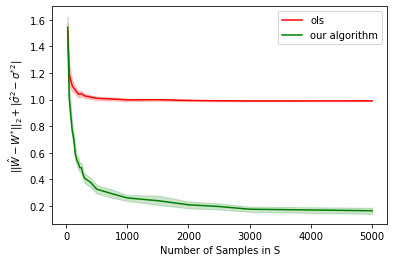

In [165]:
ax = sns.lineplot(data=ols_logs[ols_logs['num_samples'] >= 25], x='num_samples', y='ols_epsilon', label='ols', color='red')
ax = sns.lineplot(data=unknown_logs[unknown_logs['num_samples'] >= 25], x='num_samples', y='unknown_epsilon', label='our algorithm', color='green')
ax.set(xlabel='Number of Samples in S', ylabel='$||\hat W - W^{*}||_{2} + |\hat \sigma^{2} - \sigma^{*2}|$')

In [24]:
unknown_logs = unknown_logs[unknown_logs['num_samples'] > 150]
ols_logs = ols_logs[ols_logs['num_samples'] > 150]

[Text(0.5, 0, 'Number of Samples in S'),
 Text(0, 0.5, '$||\\hat W - W^{*}||_{2} + |\\hat \\sigma^{2} - \\sigma^{*2}|$')]

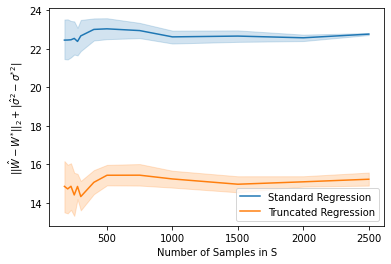

In [25]:
ax =sns.lineplot(data=ols_logs, x='num_samples', y='ols_epsilon', label='Standard Regression')
ax = sns.lineplot(data=unknown_logs, x='num_samples', y='unknown_epsilon', label='Truncated Regression')
ax.set(xlabel='Number of Samples in S', ylabel='$||\hat W - W^{*}||_{2} + |\hat \sigma^{2} - \sigma^{*2}|$')